In [11]:
!python train.py --model PCA --num_components 1 --dataset faces

> Initializing started
>> W shape:  (101, 240)
> Initializing ended
> Evaluating AT&T faces started
faces_count:  40
> Evaluating AT&T faces ended
Correct: 89.375%
> Evaluating PSNR (signal-to-noise ratio) started
> Evaluating AT&T faces ended
> Evaluating metrics: PSNR, MSE, SSIM started
/Users/allison.xiaxin.shen/Documents/GitHub/Deep-PCA/utils.py:63: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(compressed, original, multichannel =True)) # target, ref (original)
/Users/allison.xiaxin.shen/Documents/GitHub/Deep-PCA/utils.py:63: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(compressed, original, multichannel =True)) # target, ref (original)


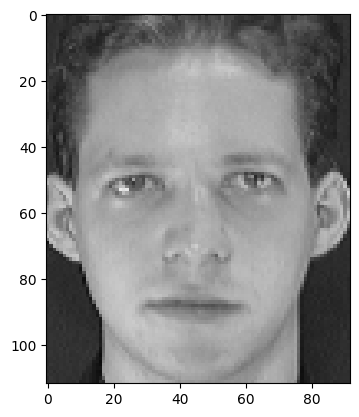

In [20]:


# Use the excellent matplotlib library

import matplotlib.pyplot as plt
im_original = plt.imread('/Users/allison.xiaxin.shen/Documents/GitHub/Deep-PCA/datasets/att_faces/s1/1.pgm')
plt.imshow(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))
# plt.close()



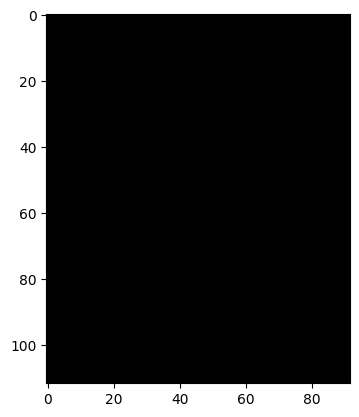

In [26]:
import matplotlib.pyplot as plt
im_compressed = plt.imread('/Users/allison.xiaxin.shen/Documents/GitHub/Deep-PCA/datasets/att_faces_compress/s1/1.pgm')
plt.imshow(cv2.cvtColor(im_compressed, cv2.COLOR_BGR2RGB))
# plt.close()


# plt.close()

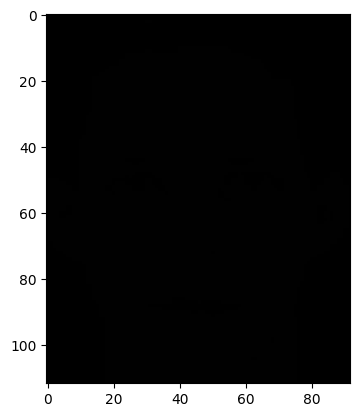

In [27]:
import matplotlib.pyplot as plt
im_restore = plt.imread('/Users/allison.xiaxin.shen/Documents/GitHub/Deep-PCA/datasets/att_faces_restore/s1/1.pgm')
plt.imshow(cv2.cvtColor(im_restore, cv2.COLOR_BGR2RGB))

In [15]:
def Display_images_as_subplots(original,compressed,restored):
    # display images as subplots
    plt.rcParams.update({'figure.max_open_warning': 0})

    original = cv2.imread(original)
    compressed = cv2.imread(compressed)
    restored = cv2.imread(restored) # 1 means read as color image

    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(compressed, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Compressed')
    axs[2].imshow(cv2.cvtColor(restored, cv2.COLOR_BGR2RGB))
    axs[2].set_title('DeepPCA Restored')

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

In [3]:
import argparse
from cmath import log10, sqrt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils, datasets, transforms
import time
import scipy
from numpy.linalg import inv
import sys
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim


In [4]:
%pwd

'/Users/allison.xiaxin.shen/Documents/GitHub/Deep-PCA'

In [1]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils, datasets, transforms
import time
import scipy
from numpy.linalg import inv
import sys
import matplotlib.pyplot as plt
import os
import cv2
import shutil
import random
from utils import PSNR, compare_images, Display_images_as_subplots

from DPCA import run_single_img, run_cifar, run_faces, CPCA
from model import DPCA_eig, STEM

class Eigenfaces(object):                                                       # *** COMMENTS ***
    faces_count = 40

    faces_dir = '.'                                                             # directory path to the AT&T faces

    train_faces_count = 6                                                       # number of faces used for training
    test_faces_count = 4                                                       # number of faces used for testing

    l = train_faces_count * faces_count                                         # training images count
    m = 92                                                                      # number of columns of the image
    n = 112                                                                     # number of rows of the image
    mn = m * n                                                                  # length of the column vector

    """
    Initializing the Eigenfaces model.
    """
    def __init__(self, _faces_dir = '.'):
        print('> Initializing started')

        self.faces_dir = _faces_dir
        self.energy = 0.85
        self.training_ids = []                                                  # train image id's for every at&t face

        L = np.empty(shape=(self.mn, self.l), dtype='float64')                  # each row of L represents one train image

        cur_img = 0
        for face_id in range(1, self.faces_count + 1):

            training_ids = random.sample(range(1, 11), self.train_faces_count)  # the id's of the 6 random training images
            self.training_ids.append(training_ids)                              # remembering the training id's for later

            for training_id in training_ids:
                path_to_img = os.path.join(self.faces_dir,
                        's' + str(face_id), str(training_id) + '.pgm')          # relative path
                #print '> reading file: ' + path_to_img

                img = cv2.imread(path_to_img, 0)                                # read a grayscale image
                img_col = np.array(img, dtype='float64').flatten()              # flatten the 2d image into 1d

                L[:, cur_img] = img_col[:]                                      # set the cur_img-th column to the current training image
                cur_img += 1

        self.mean_img_col = np.sum(L, axis=1) / self.l                          # get the mean of all images / over the rows of L

        for j in range(0, self.l):                                             # subtract from all training images
            L[:, j] -= self.mean_img_col[:]

        C = np.matrix(L.transpose()) * np.matrix(L)                             # instead of computing the covariance matrix as
        C /= self.l                                                             # L*L^T, we set C = L^T*L, and end up with way
                                                                                # smaller and computentionally inexpensive one
                                                                                # we also need to divide by the number of training
        # data = torch.from_numpy(np.matrix(L.transpose())).reshape(self.l, 92, 112).unsqueeze(1)   #[320, 1, 92, 112]
        # stem = STEM(data, channel=1)  #[3297280, 9]
        # X = stem.reshape(self.l, 92*112, 9).reshape(self.l,-1).t()  #[HW9, 320]
        # Y = torch.from_numpy(np.matrix(L))                                 #[HW, 320]
        
        # XYt = torch.mm(X, Y.t())
        # # RM = torch.mm(torch.inverse(torch.mm(X, X.t())+1e-3*torch.eye(X.shape[0])),
        # #                 torch.mm(XYt, XYt.t()))
        # RM_ = torch.mm(X.t(),torch.inverse(torch.mm(X, X.t())+1e-3*torch.eye(X.shape[0])),
        #                 torch.mm(XYt, Y))
        # eigenvalues, eigenvectors = torch.linalg.eig(RM_)
        
        # values, indices = torch.sort(eigenvalues.real, descending=True)
        
        # m=50
        # U = (eigenvectors[:, indices[:m]]).t().real  #(m,HW9)
        
        values, eigenvectors = np.linalg.eig(C)                          # eigenvectors/values of the covariance matrix
        indices = values.argsort()[::-1]                             # getting their correct order - decreasing
        self.evalues = values[indices]                               # puttin the evalues in that order
        self.evectors = eigenvectors[:,indices]                             # same for the evectors

        evalues_sum = sum(self.evalues[:])                                      # include only the first k evectors/values so
        evalues_count = 0                                                       # that they include approx. 85% of the energy
        evalues_energy = 0.0
        for evalue in self.evalues:
            evalues_count += 1
            evalues_energy += evalue / evalues_sum

            if evalues_energy >= self.energy:
                break

        self.evalues = self.evalues[0:evalues_count]                            # reduce the number of eigenvectors/values to consider
        self.evectors = self.evectors[:,0:evalues_count]

        self.evectors = L * self.evectors    #(HW,62)
        norms = np.linalg.norm(self.evectors, axis=0)                           # find the norm of each eigenvector
        self.evectors = self.evectors / norms                                   # normalize all eigenvectors

        self.W = self.evectors.transpose() * L       #(62,320) 
        print(">> W shape: ", self.W.shape) # (101,240)

        print('> Initializing ended')
    """
    Classify an image to one of the eigenfaces.
    """
    def classify(self, path_to_img):
        img = cv2.imread(path_to_img, 0)                                        # read as a grayscale image
        img_col = np.array(img, dtype='float64').flatten()                      # flatten the image
        img_col -= self.mean_img_col                                            # subract the mean column
        img_col = np.reshape(img_col, (self.mn, 1))                             # from row vector to col vector

        S = self.evectors.transpose() * img_col                                 # projecting the normalized probe onto the
                                                                                # Eigenspace, to find out the weights

        diff = self.W - S                                                       # finding the min ||W_j - S||
        norms = np.linalg.norm(diff, axis=0)

        closest_face_id = np.argmin(norms)                                      # the id [0..240) of the minerror face to the sample
        return int(closest_face_id / self.train_faces_count) + 1                   # return the faceid (1..40)
    def all_metrics(self):
        # scores = compare_images(target, ref)
        print('> Evaluating metrics: PSNR, MSE, SSIM started')
        original_dir = os.path.join('datasets', 'att_faces')
        compressed_dir = os.path.join('datasets', 'att_faces_compress')
        if not os.path.exists(compressed_dir):   
            assert("commpresed_dis does not exist")  #assert a message "no path error"  
        restored_dir = os.path.join('datasets', 'att_faces_restore')
        if not os.path.exists(restored_dir):                                           # create a folder where to store the results
            assert("restored_dir does not exist")  #assert a message "no path error"")                                 
        results_file = os.path.join('results', 'three_metrics_results.txt')
        f = open(results_file, 'w')                                       # the actual file

        for face_id in range(1, self.faces_count + 1):
            for test_id in range(1, 11):
                # if (test_id in self.training_ids[face_id-1]) == False:          # we skip the image if it is part of the training set
                path_to_img_original = os.path.join(original_dir,
                        's' + str(face_id), str(test_id) + '.pgm')   
                path_to_img_compressed = os.path.join(compressed_dir,
                        's' + str(face_id), str(test_id) + '.pgm') 
                path_to_img_restore = os.path.join(restored_dir,
                        's' + str(face_id), str(test_id) + '.pgm') 
                scores_ori_comp = compare_images(path_to_img_original, path_to_img_compressed)
                print(f"Image: {face_id}_{test_id} scores_ori_comp\nPSNR: {scores_ori_comp[0]}, MSE: {scores_ori_comp[1]}, SSIM: {scores_ori_comp[2]}\n")
                scores_ori_rest = compare_images(path_to_img_original, path_to_img_restore)
                print(f"Image: {face_id}_{test_id} scores_ori_rest\nPSNR: {scores_ori_rest[0]}, MSE: {scores_ori_rest[1]}, SSIM: {scores_ori_rest[2]}\n")
                scores_rest_comp = compare_images(path_to_img_restore, path_to_img_compressed)
                print(f"Image: {face_id}_{test_id} scores_rest_comp\nPSNR: {scores_rest_comp[0]}, MSE: {scores_rest_comp[1]}, SSIM: {scores_rest_comp[2]}\n")
                Display_images_as_subplots(path_to_img_original,path_to_img_compressed,path_to_img_restore)
                # scores_rest_ori = compare_images(path_to_img_restore, path_to_img_original)
                # f.write(f"Image: {face_id}_{test_id} scores_rest_ori\nPSNR: {scores_rest_ori[0]}, MSE: {scores_rest_ori[1]}, SSIM: {scores_rest_ori[2]}\n")
        f.close()                                                               # closing the file

    def compute_psnr(self):
        print('> Evaluating PSNR (signal-to-noise ratio) started')
        original_dir = os.path.join('datasets', 'att_faces')
        compressed_dir = os.path.join('datasets', 'att_faces_compress')
        if not os.path.exists(compressed_dir):   
            assert("commpresed_dis does not exist")  #assert a message "no path error"  
        restored_dir = os.path.join('datasets', 'att_faces_restore')
        if not os.path.exists(restored_dir):                                           # create a folder where to store the results
            assert("restored_dir does not exist")  #assert a message "no path error"")                                 
        results_file = os.path.join('results', 'psnr_results.txt')
        f = open(results_file, 'w')                                       # the actual file

        for face_id in range(1, self.faces_count + 1):
            for test_id in range(1, 11):
                # if (test_id in self.training_ids[face_id-1]) == False:          # we skip the image if it is part of the training set
                path_to_img_original = os.path.join(original_dir,
                        's' + str(face_id), str(test_id) + '.pgm')   
                path_to_img_compressed = os.path.join(compressed_dir,
                        's' + str(face_id), str(test_id) + '.pgm') 
                path_to_img_restore = os.path.join(restored_dir,
                        's' + str(face_id), str(test_id) + '.pgm') 
                psnr_ori_comp = PSNR(path_to_img_original,path_to_img_compressed)
                psnr_ori_rest = PSNR(path_to_img_original,path_to_img_restore)
                psnr_rest_comp = PSNR(path_to_img_restore,path_to_img_compressed)
                # psnr_rest_ori = PSNR(path_to_img_restore,path_to_img_original)
                # write the result to a csv file
                # f.write(f"Image: {face_id}_{test_id}\npsnr_ori_comp: {psnr_ori_comp}\npsnr_ori_rest: {psnr_ori_rest}\npsnr_rest_comp: {psnr_rest_comp}\npsnr_rest_ori: {psnr_rest_ori}\n\n")
                f.write(f"Image: {face_id}_{test_id}\npsnr_ori_comp: {psnr_ori_comp}\npsnr_ori_rest: {psnr_ori_rest}\npsnr_rest_comp: {psnr_rest_comp}\n\n")
                # f.write('image: %s\npsnr_ori_comp: %.2f\npsnr_ori_rest: %.2f\npsnr_rest_comp: %.2f\n\n' %
                                # ("Image: "+str(face_id)+"_"+str(test_id), psnr_ori_comp, psnr_ori_rest, psnr_rest_comp))
                # f.write('image: %s\nresult: correct\n\n' % path_to_img)
                # Display_images_as_subplots(path_to_img_original,path_to_img_compressed,path_to_img_restore)

        print('> Evaluating AT&T faces ended')
        f.close()                                                               # closing the file

                
    """
    Evaluate the model using the 4 test faces left
    from every different face in the AT&T set.
    """
    def evaluate(self):
        print('> Evaluating AT&T faces started')
        results_file = os.path.join('results', 'att_restore_results.txt')               # filename for writing the evaluating results in
        f = open(results_file, 'w')                                             # the actual file

        test_count = self.test_faces_count * self.faces_count                   # number of all AT&T test images/faces
        test_correct = 0
        print("faces_count: ", self.faces_count)
        for face_id in range(1, self.faces_count + 1):
            for test_id in range(1, 11):
                if (test_id in self.training_ids[face_id-1]) == False:          # we skip the image if it is part of the training set
                    path_to_img = os.path.join(self.faces_dir,
                            's' + str(face_id), str(test_id) + '.pgm')          # relative path

                    result_id = self.classify(path_to_img)
                    # print("result_id: ", result_id, "face_id: ", face_id, "test_id: ", test_id)
                    result = (result_id == face_id)

                    if result == True:
                        test_correct += 1
                        f.write('image: %s\nresult: correct\n\n' % path_to_img)
                    else:
                        f.write('image: %s\nresult: wrong, got %2d\n\n' %
                                (path_to_img, result_id))

        print('> Evaluating AT&T faces ended')
        self.accuracy = float(100. * test_correct / test_count)
        print('Correct: ' + str(self.accuracy) + '%')
        f.write('Correct: %.2f\n' % (self.accuracy))
        f.close()                                                               # closing the file


> Initializing started
>> W shape:  (101, 240)
> Initializing ended
> Evaluating metrics: PSNR, MSE, SSIM started
Image: 1_1 scores_ori_comp
PSNR: (27.433550410291694+0j), MSE: 117.4154697204969, SSIM: 0.00394173679067079

Image: 1_1 scores_ori_rest
PSNR: (27.433500155362623+0j), MSE: 117.41682841614907, SSIM: 0.003942706476879281

Image: 1_1 scores_rest_comp
PSNR: (67.61628221656727+0j), MSE: 0.01125776397515528, SSIM: 0.9997510134603447



/Users/allison.xiaxin.shen/Documents/GitHub/Deep-PCA/utils.py:63: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(compressed, original, multichannel =True)) # target, ref (original)


Image: 1_2 scores_ori_comp
PSNR: (27.44599922276737+0j), MSE: 117.07938664596273, SSIM: 0.005792927877164396

Image: 1_2 scores_ori_rest
PSNR: (27.450670886353702+0j), MSE: 116.95351319875776, SSIM: 0.005792972224128051

Image: 1_2 scores_rest_comp
PSNR: (67.65388370530034+0j), MSE: 0.011160714285714286, SSIM: 0.9997449356324141

Image: 1_3 scores_ori_comp
PSNR: (27.51373603889842+0j), MSE: 115.26746894409938, SSIM: 0.004466065854823062

Image: 1_3 scores_ori_rest
PSNR: (27.51117355236549+0j), MSE: 115.33550077639751, SSIM: 0.004463506198532234

Image: 1_3 scores_rest_comp
PSNR: (67.96702433198436+0j), MSE: 0.010384316770186336, SSIM: 0.9997660550724302

Image: 1_4 scores_ori_comp
PSNR: (27.85496527988096+0j), MSE: 106.55745341614907, SSIM: 0.004710733899767923

Image: 1_4 scores_ori_rest
PSNR: (27.857829961891618+0j), MSE: 106.48718944099379, SSIM: 0.004716542320663058

Image: 1_4 scores_rest_comp
PSNR: (67.1214285857681+0j), MSE: 0.012616459627329192, SSIM: 0.999716747277235

Image: 

KeyboardInterrupt: 

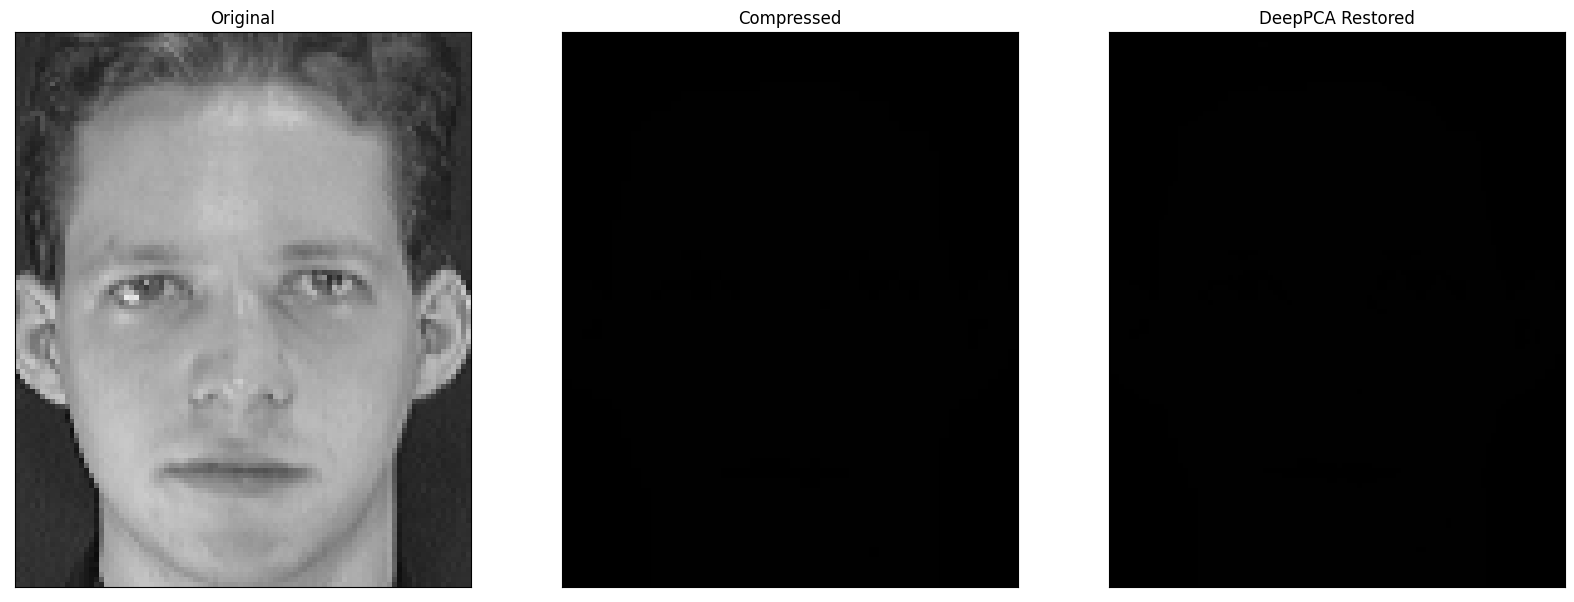

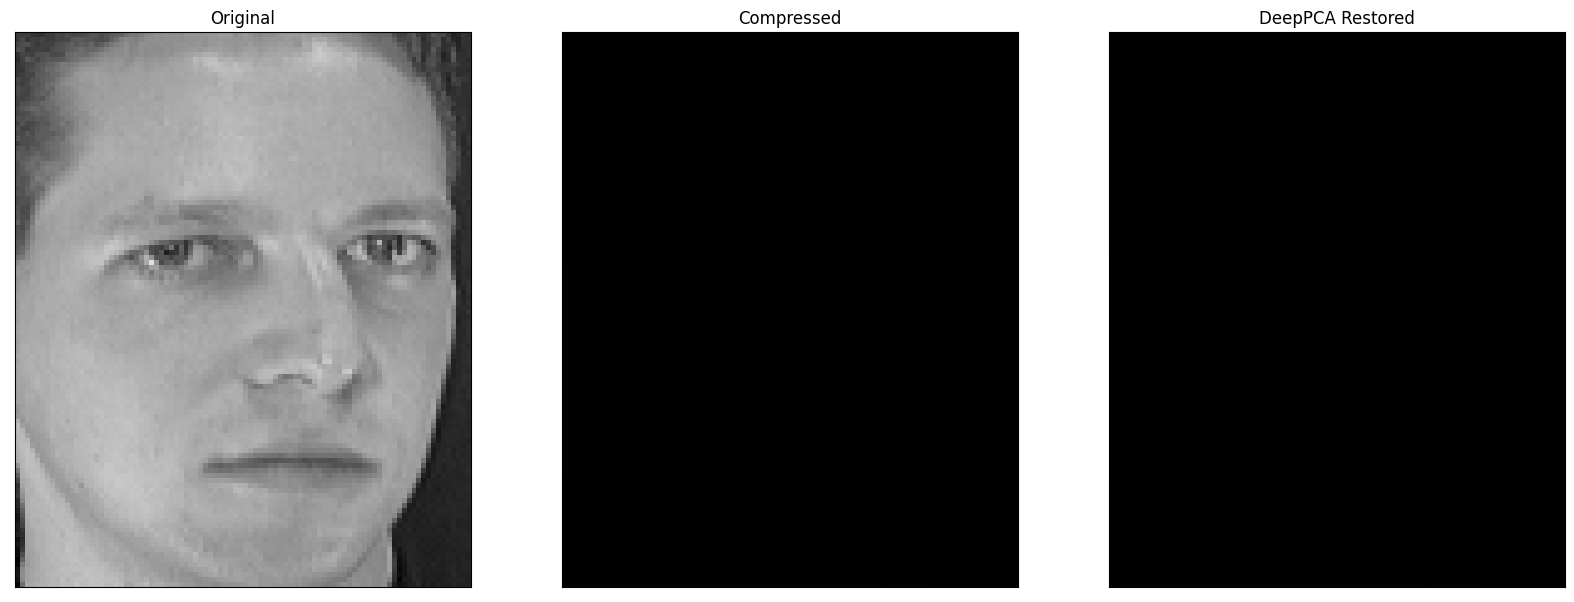

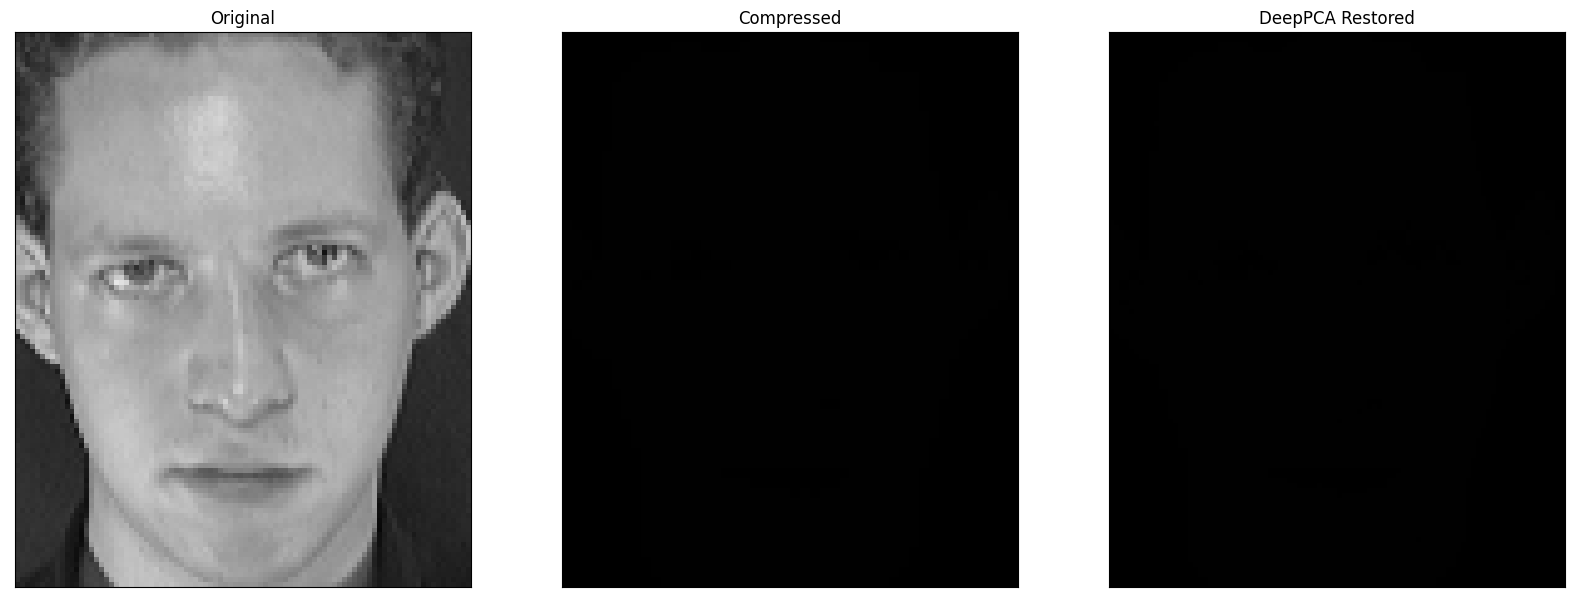

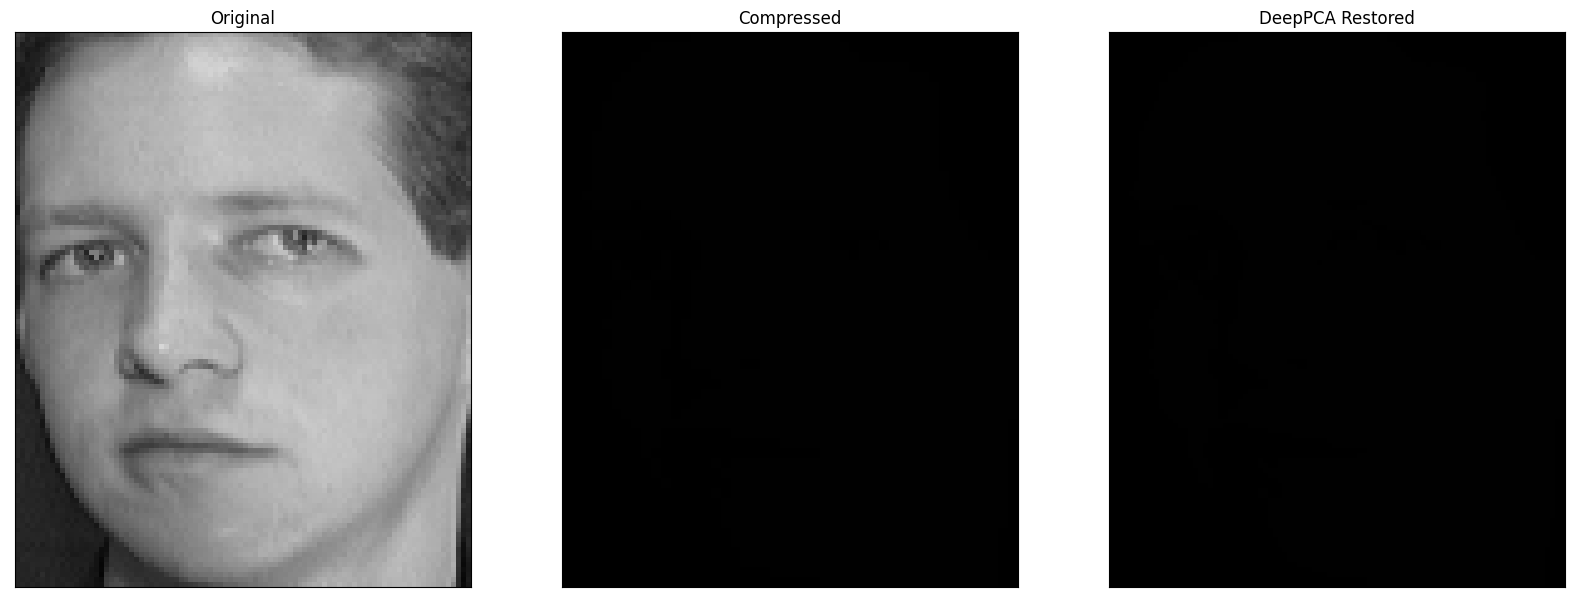

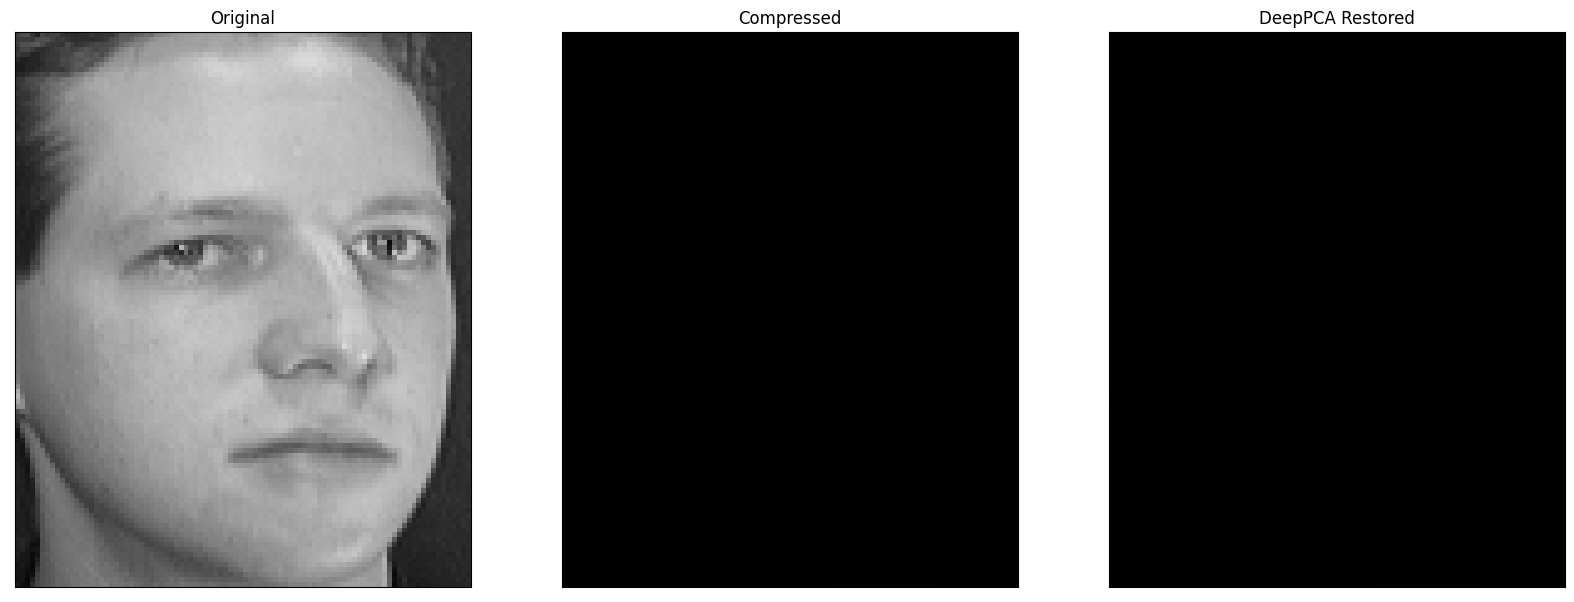

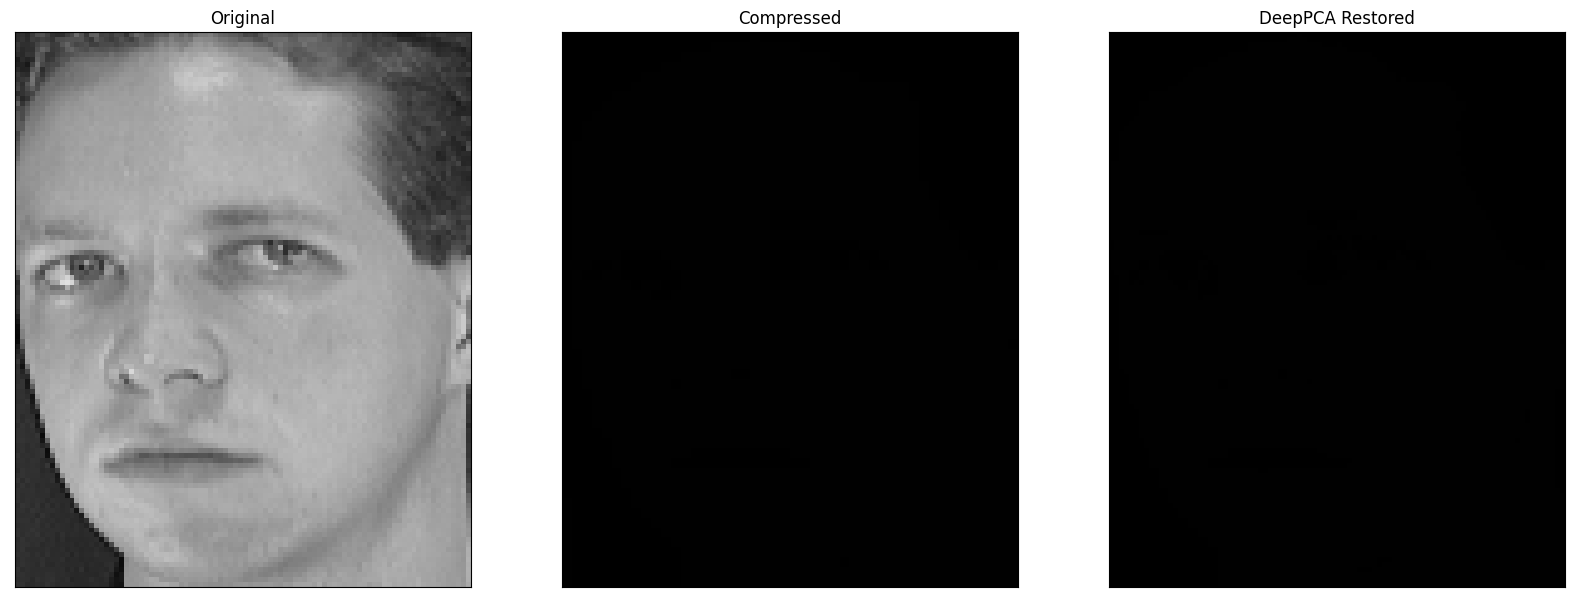

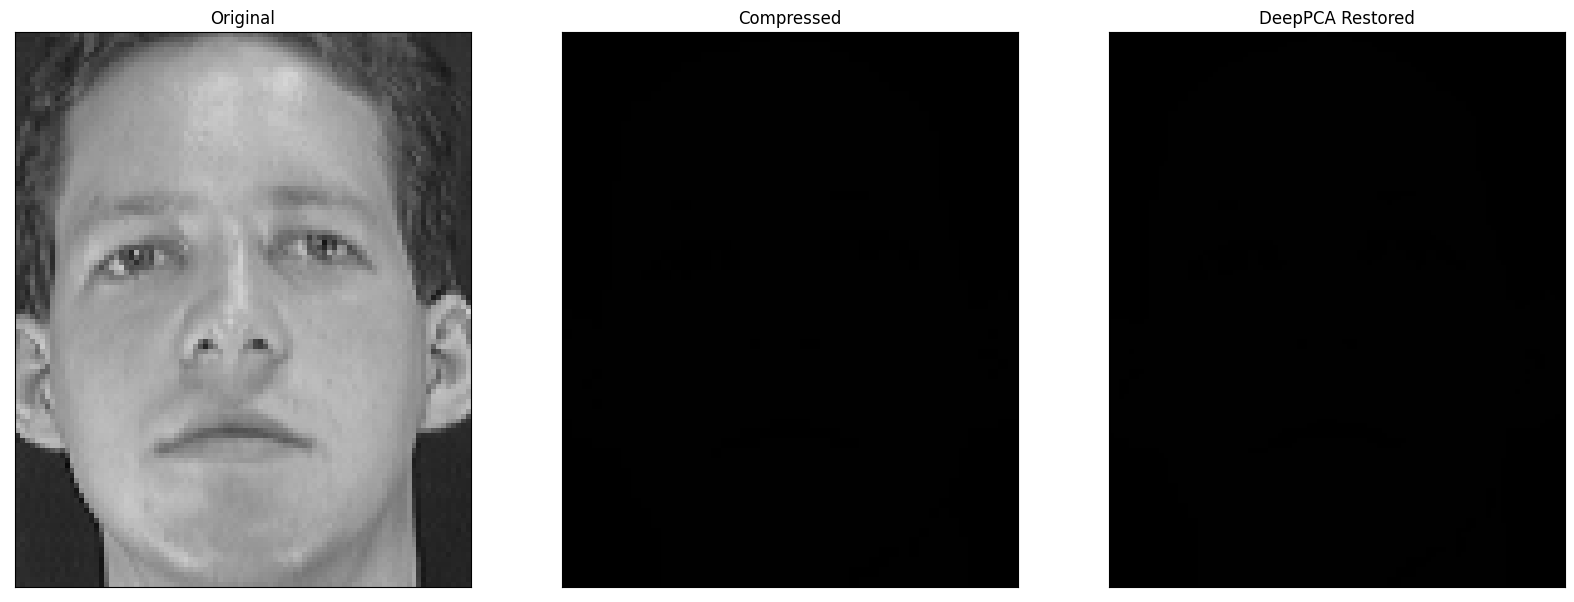

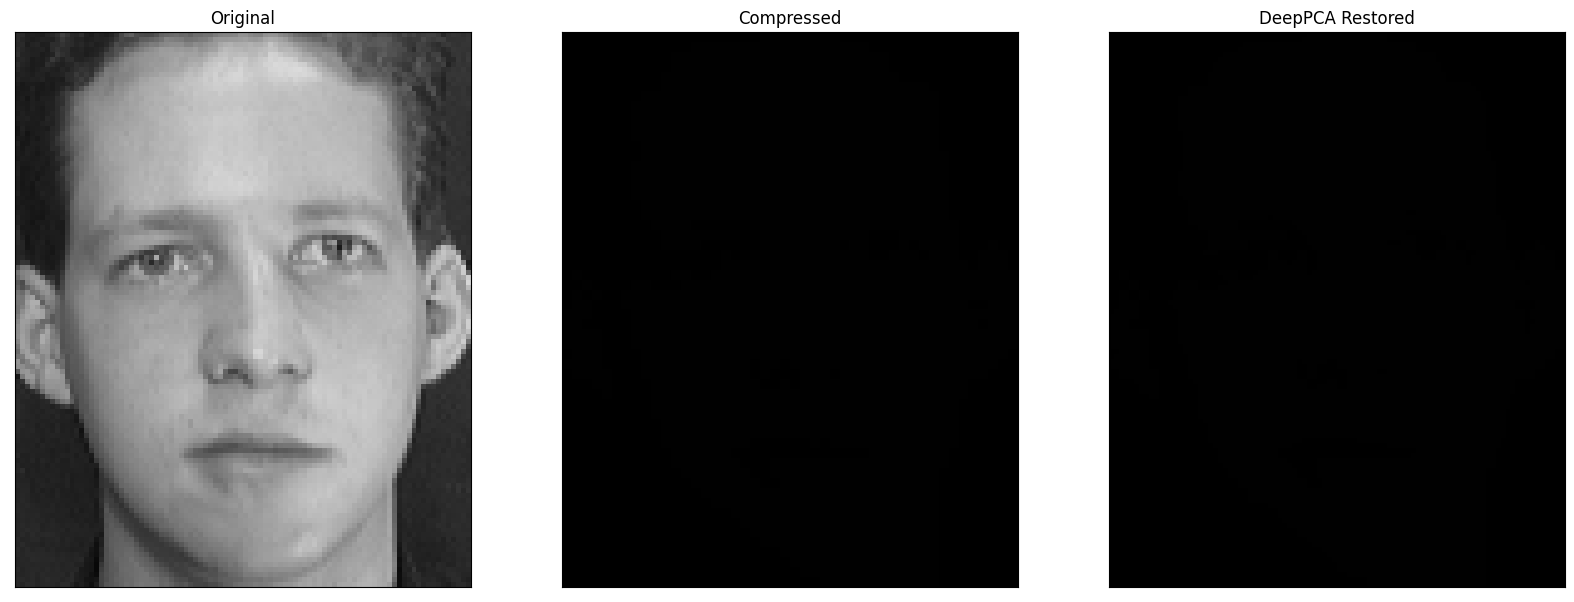

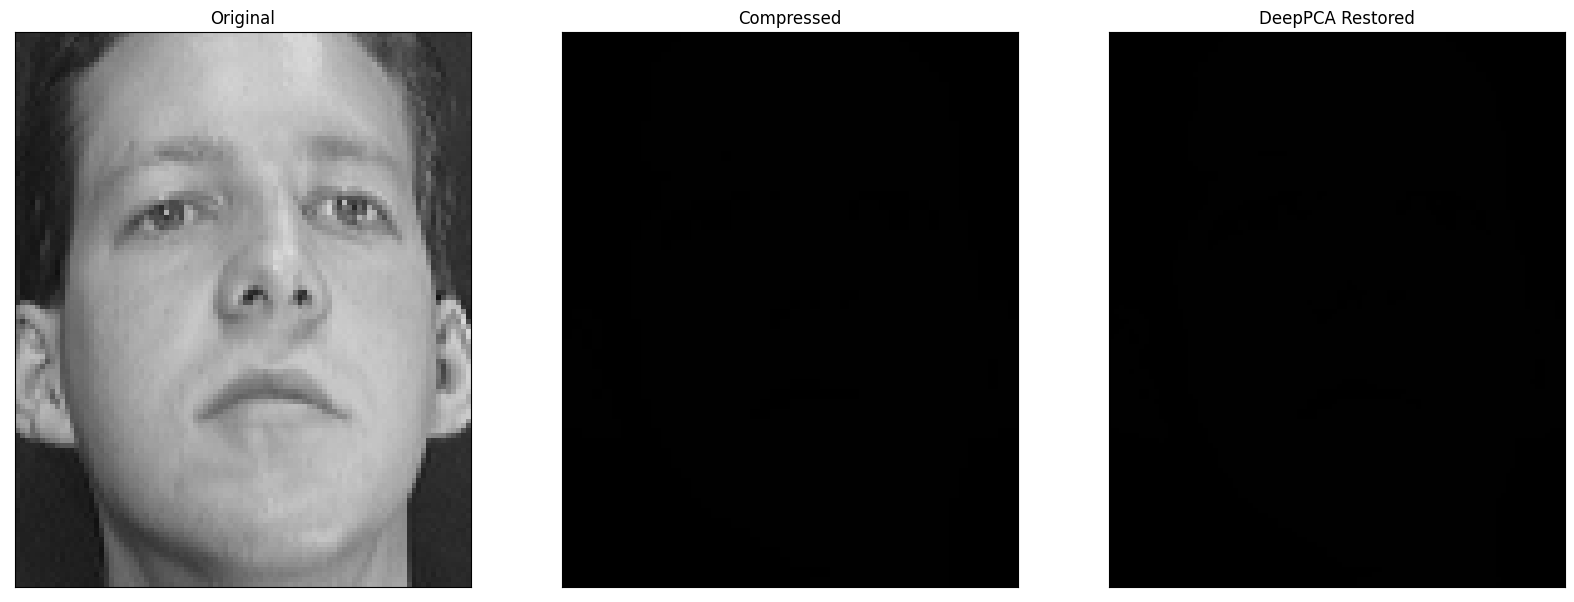

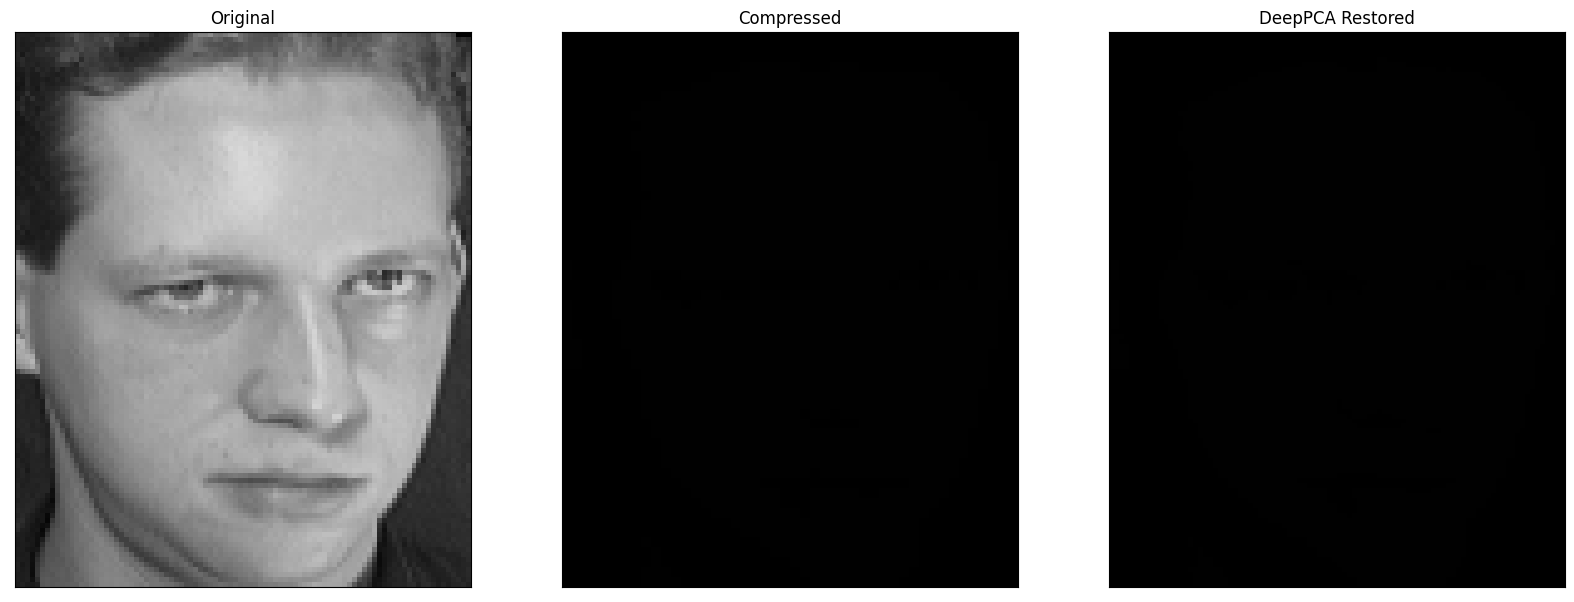

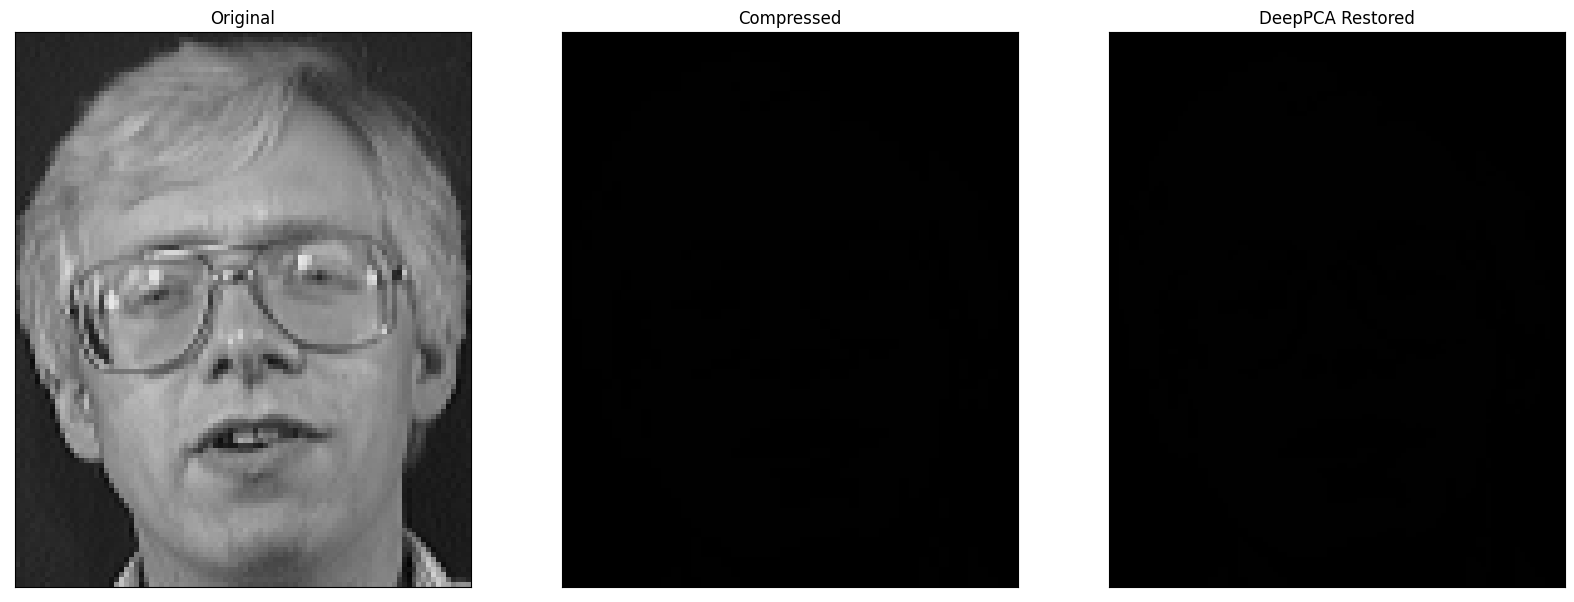

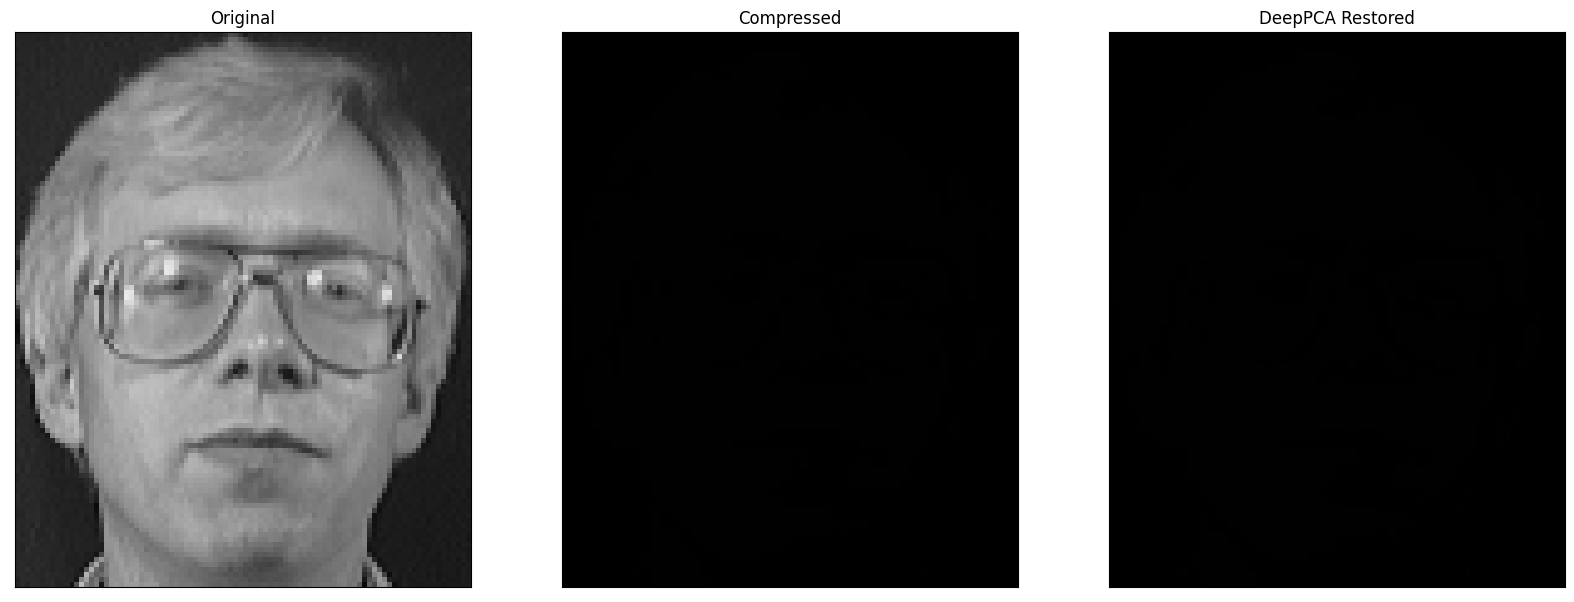

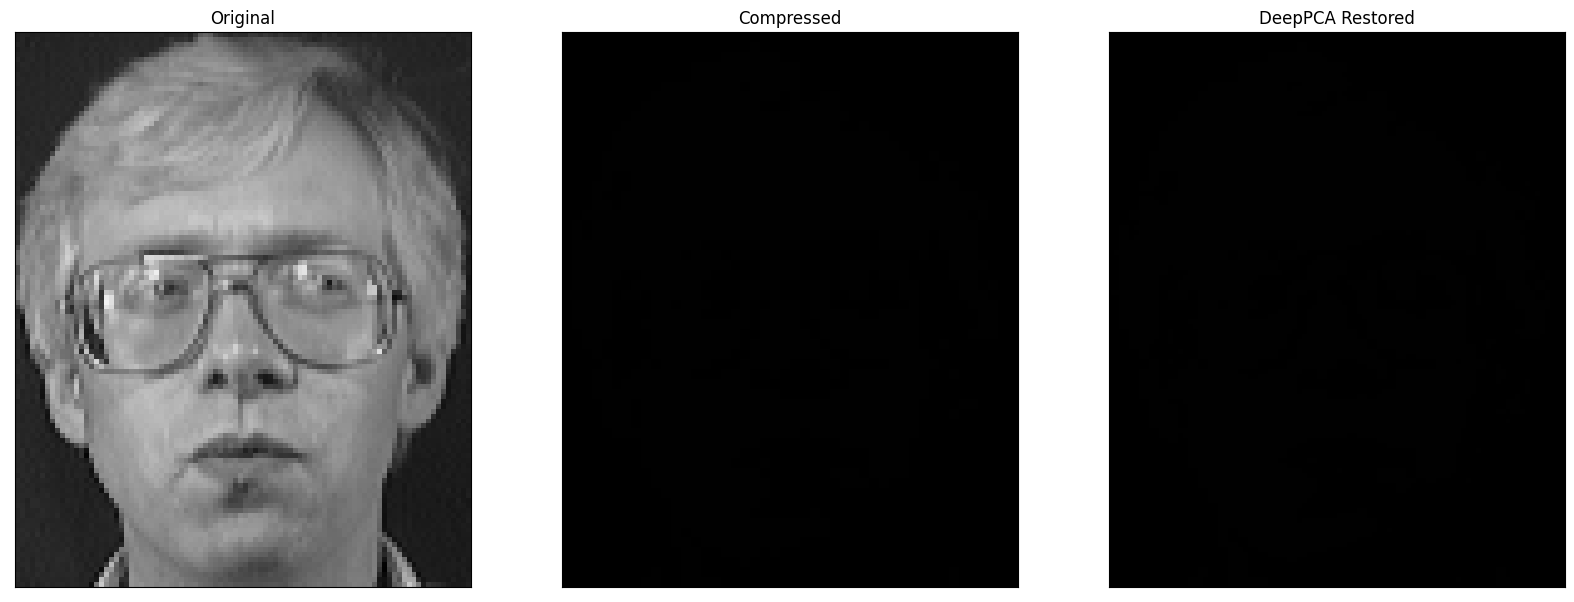

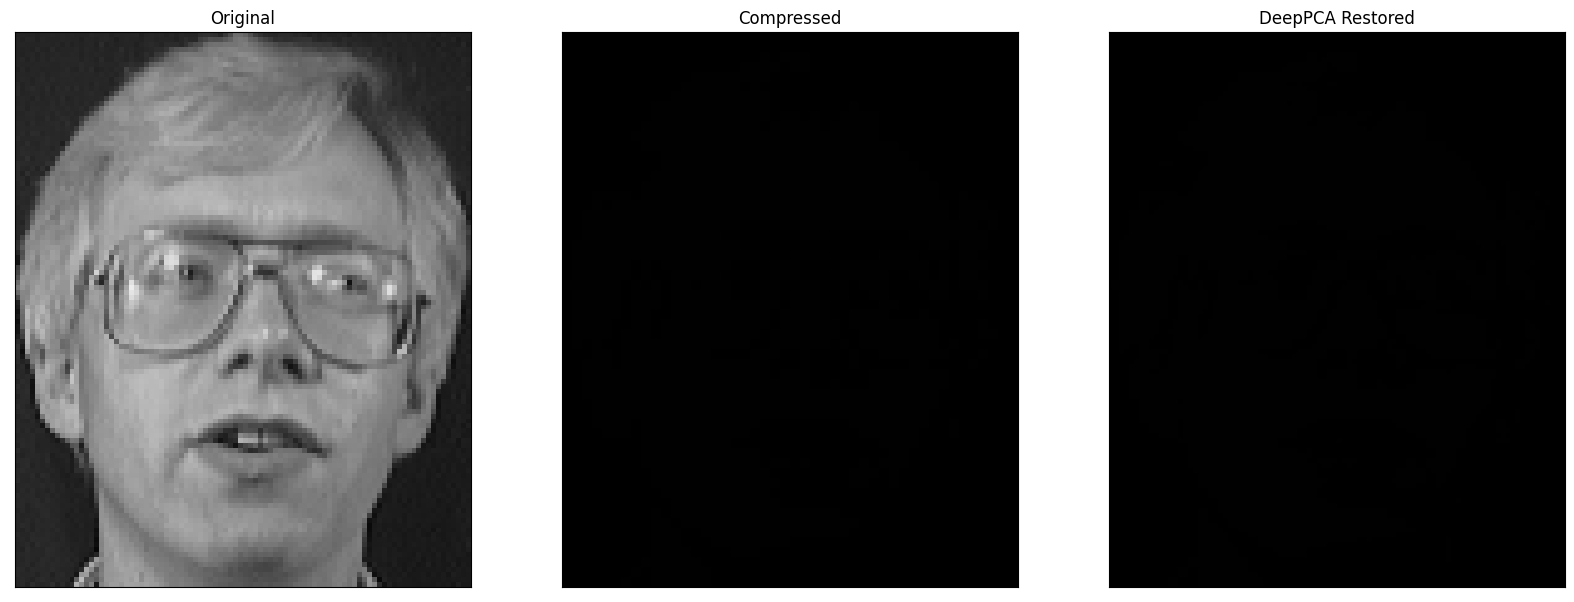

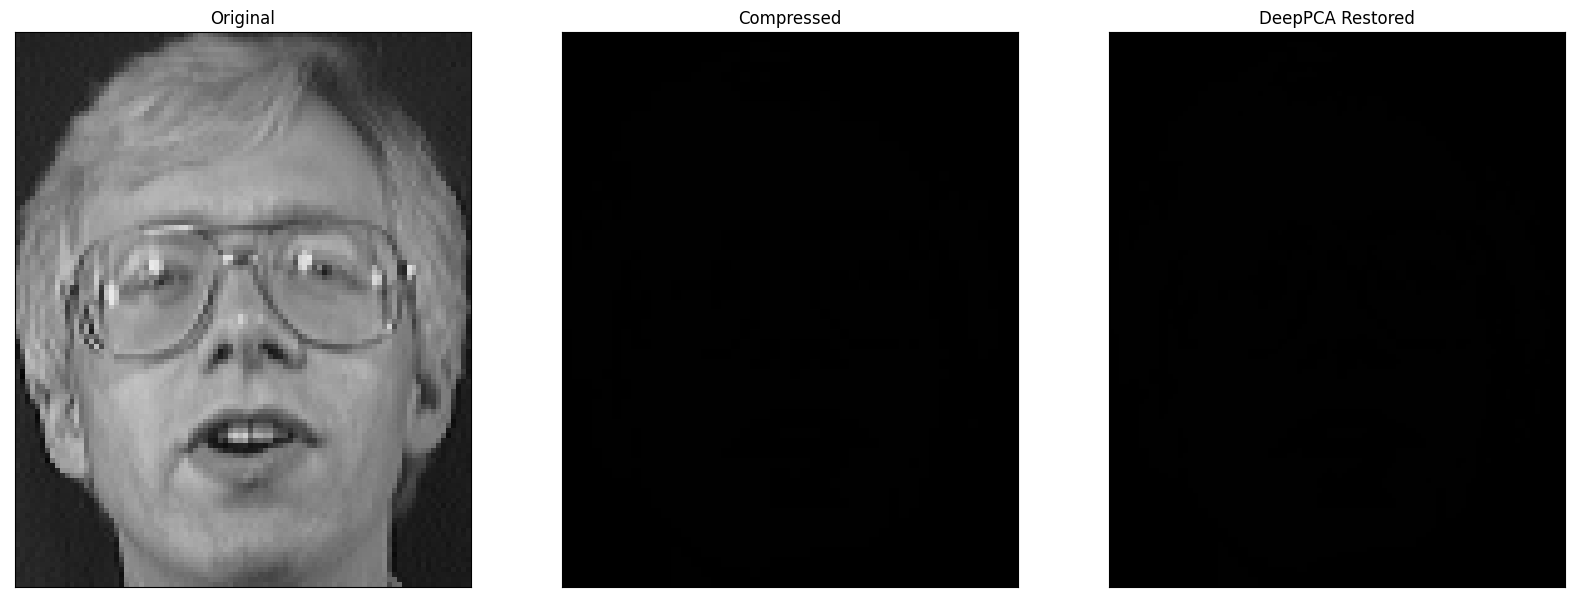

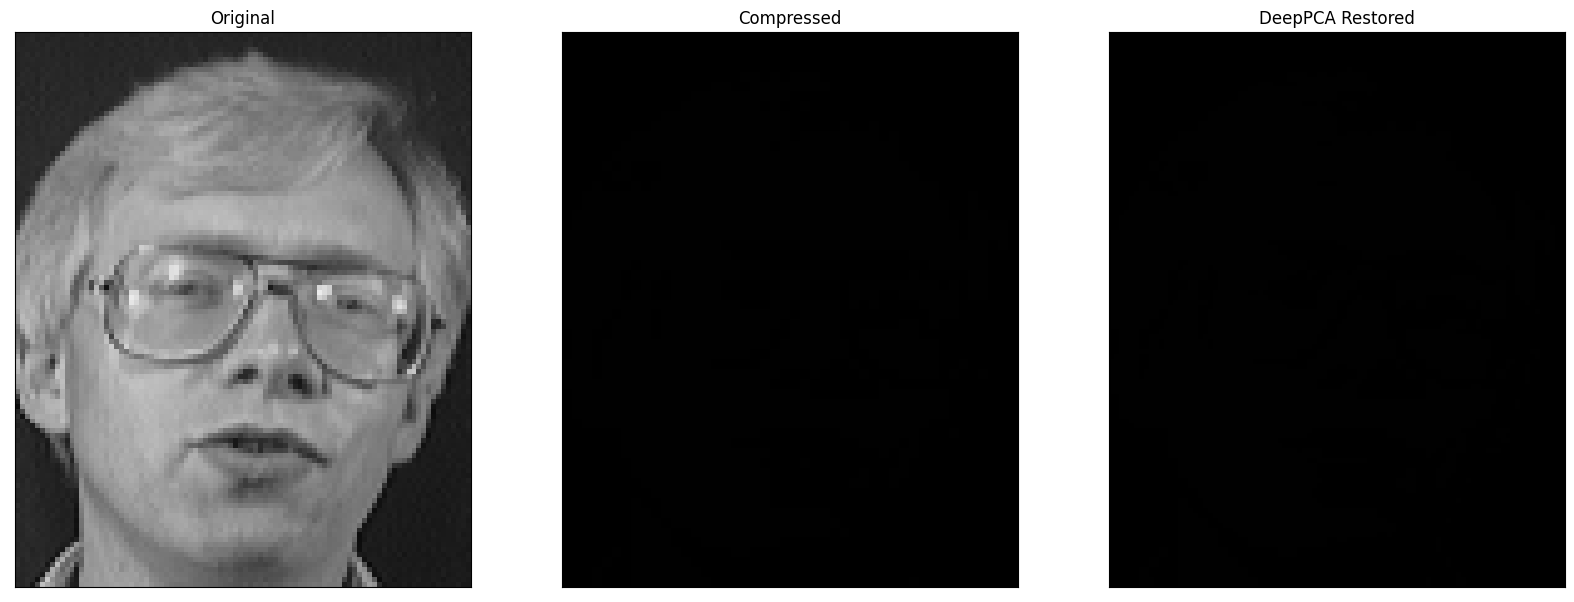

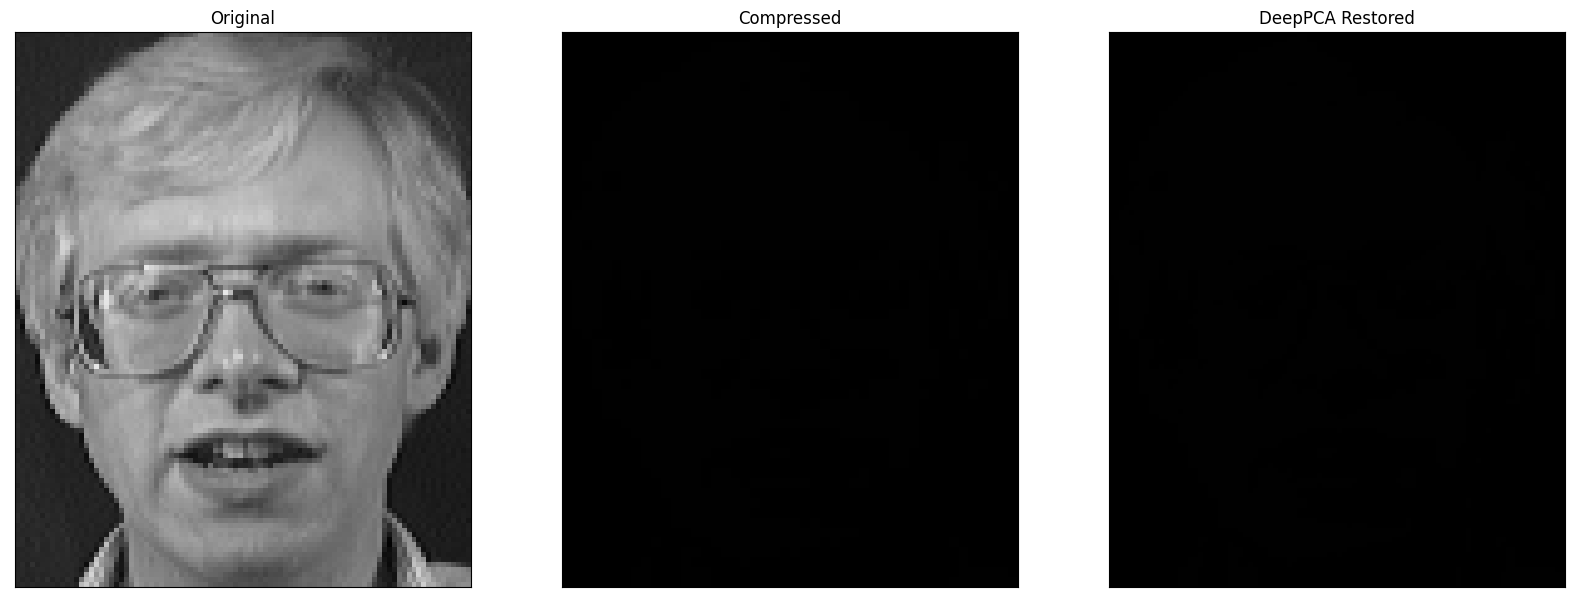

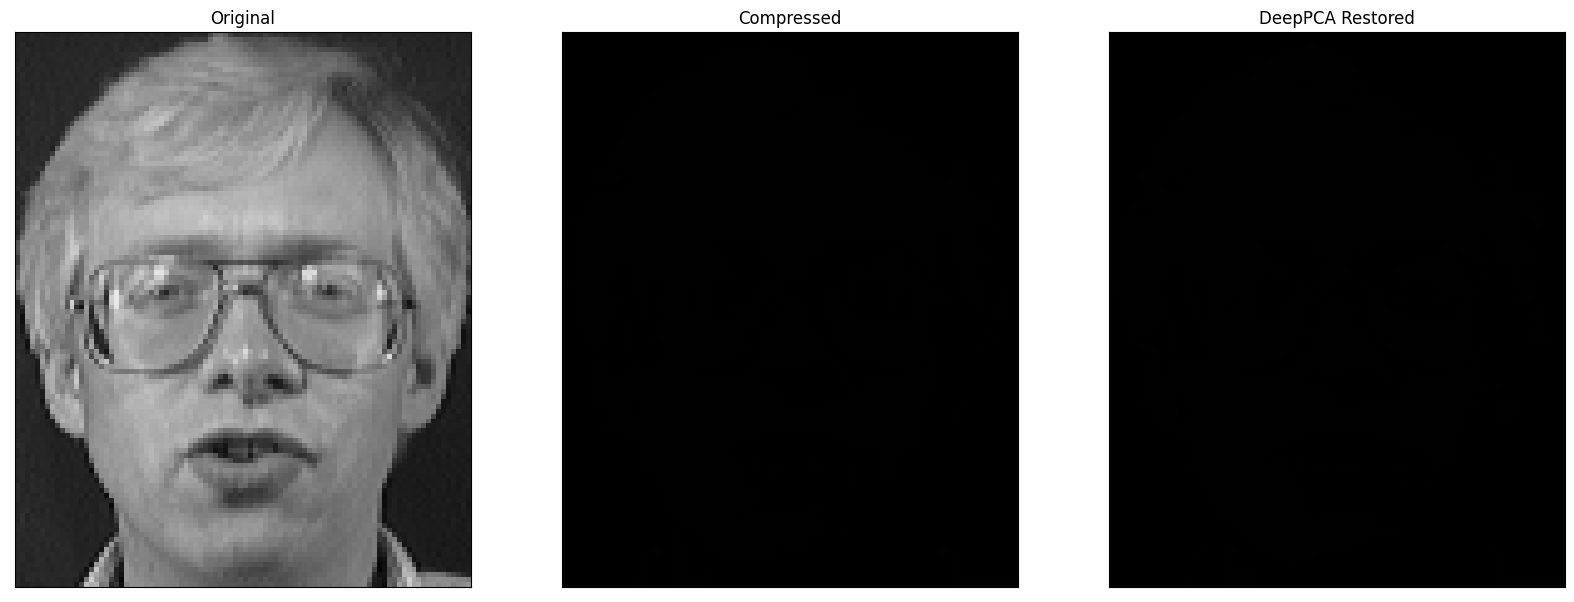

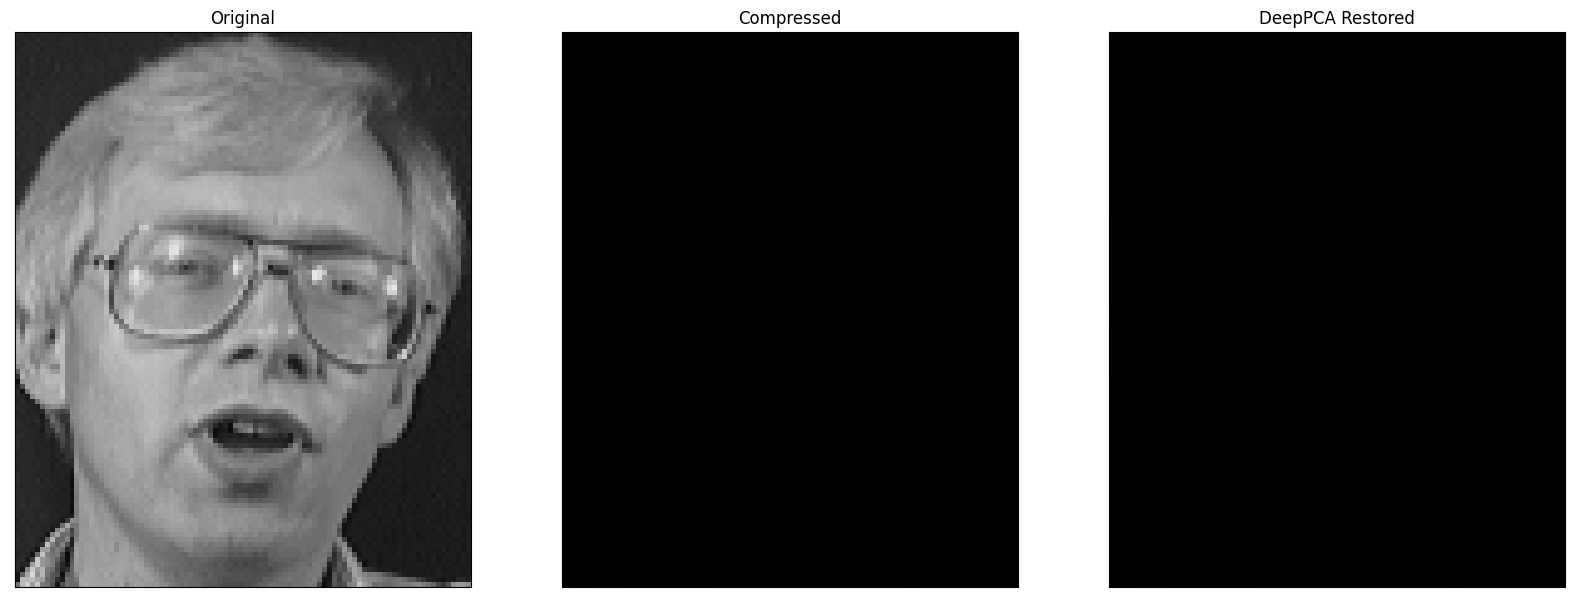

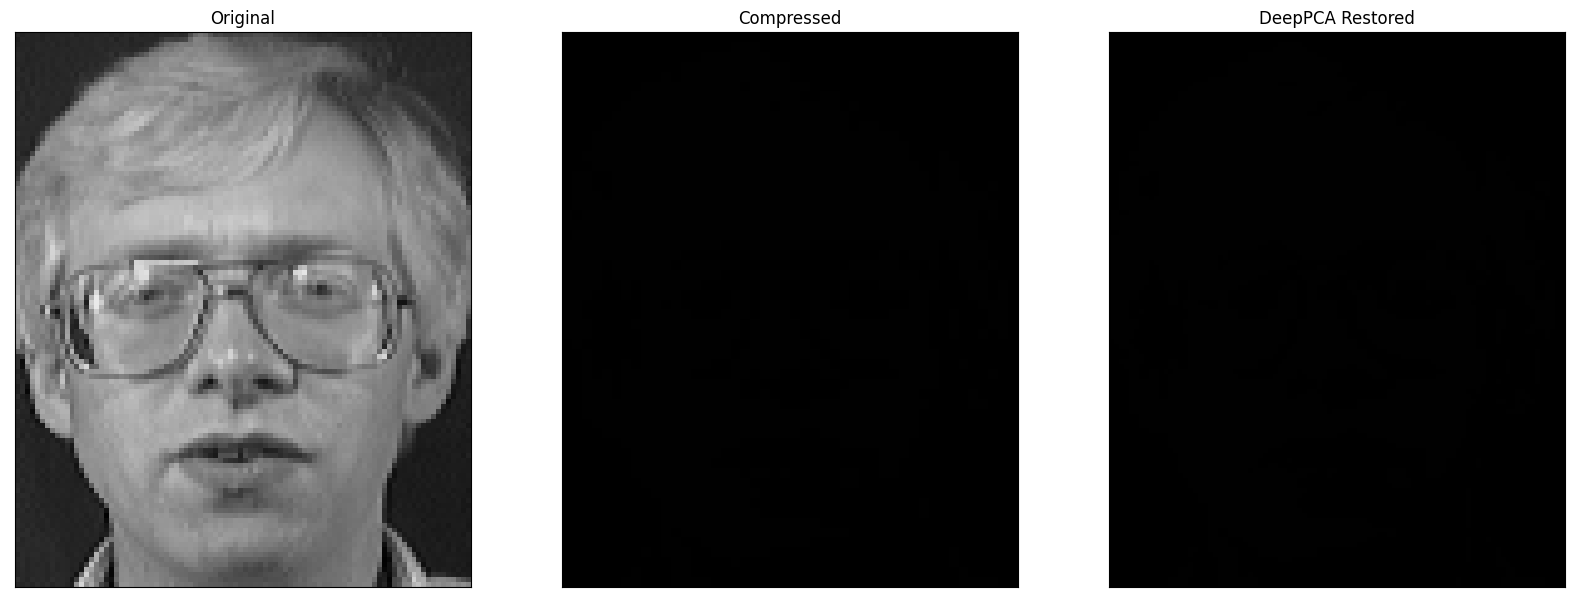

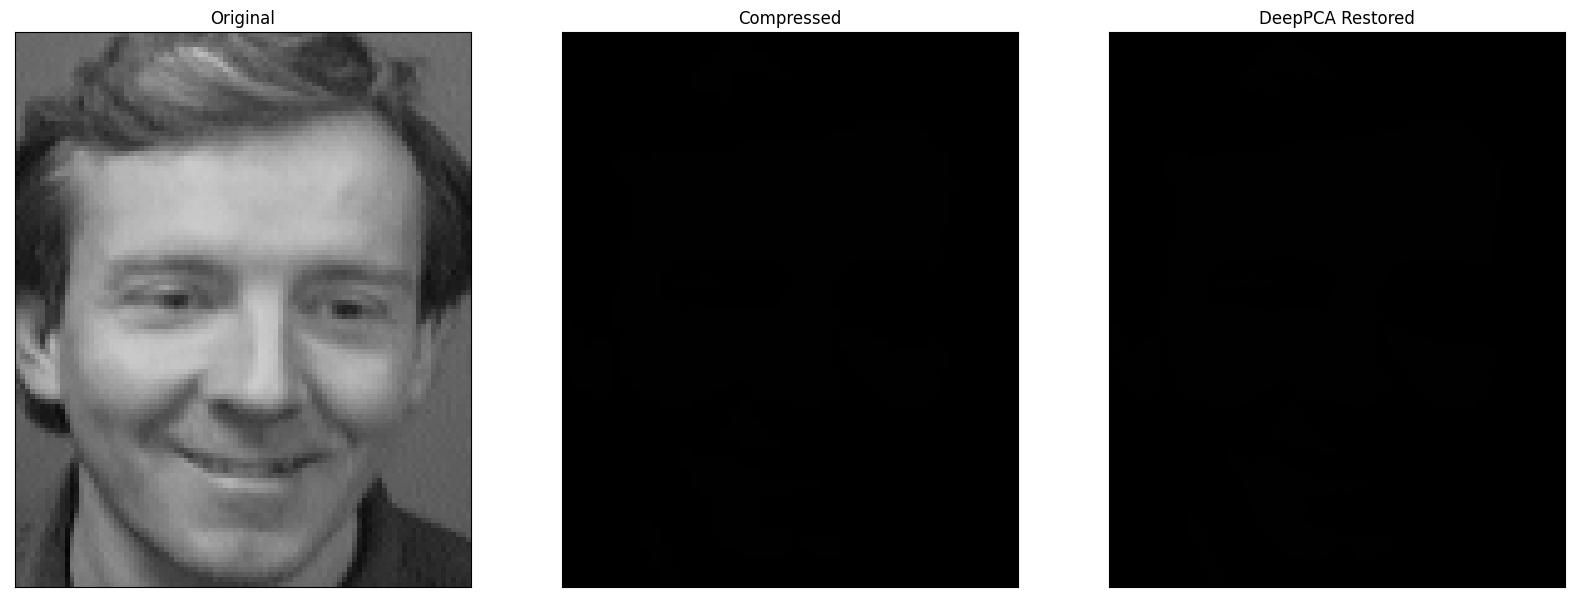

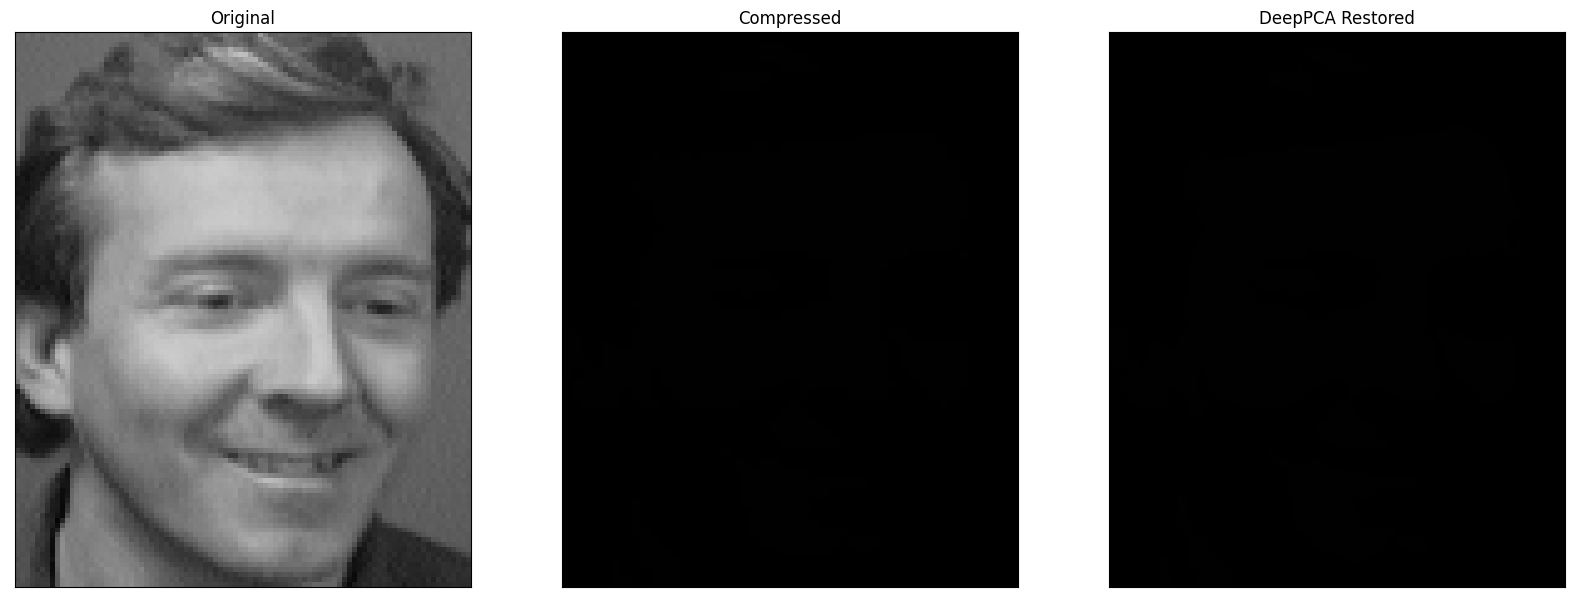

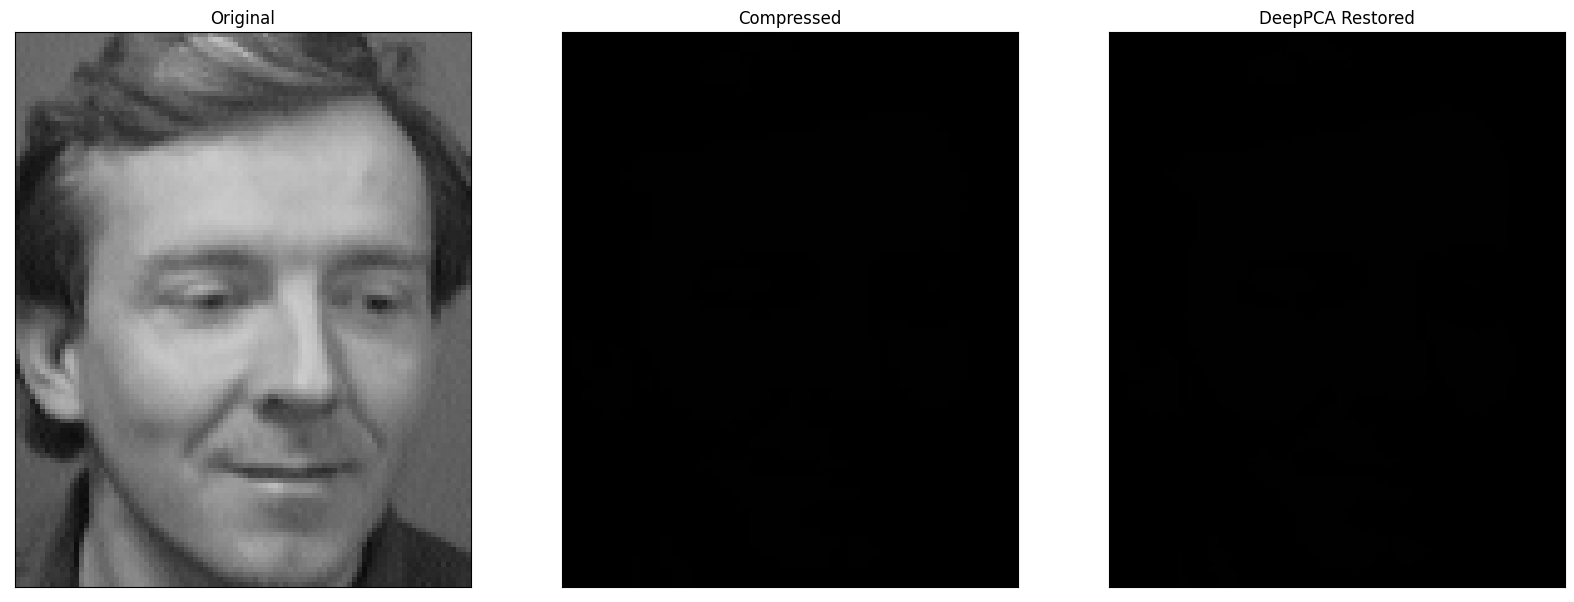

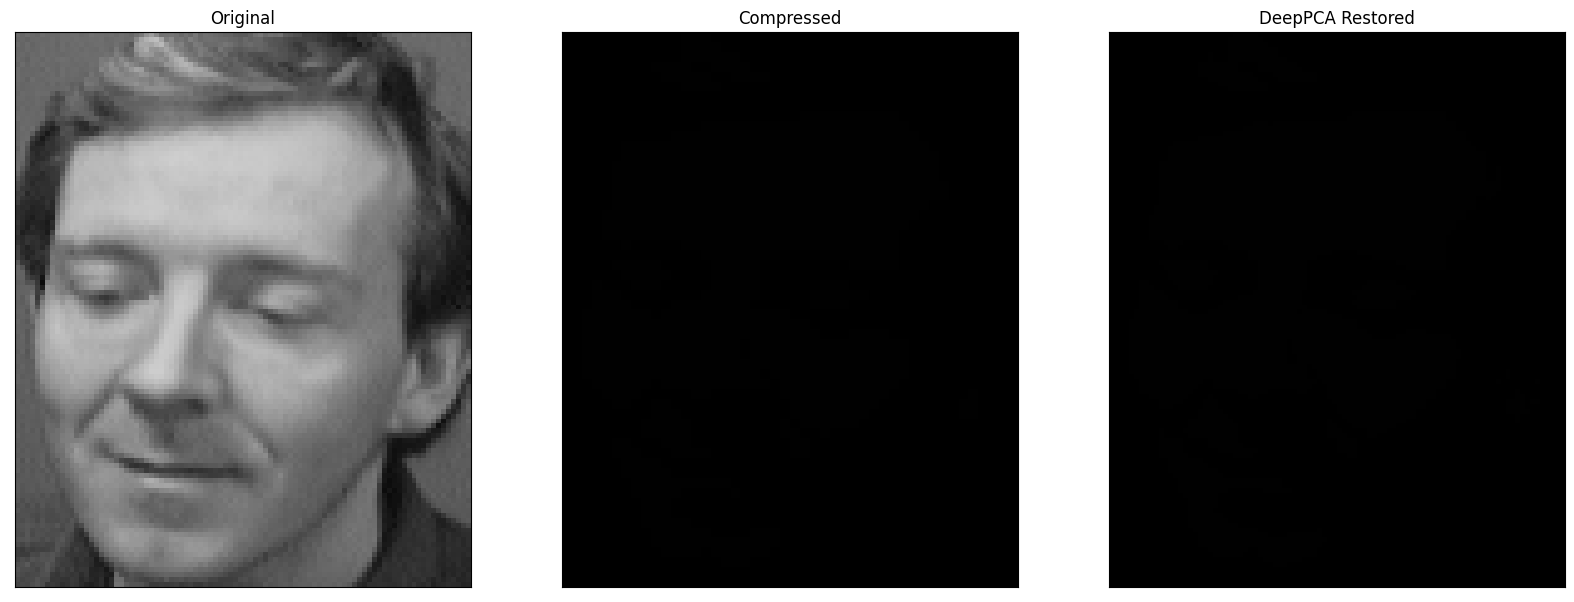

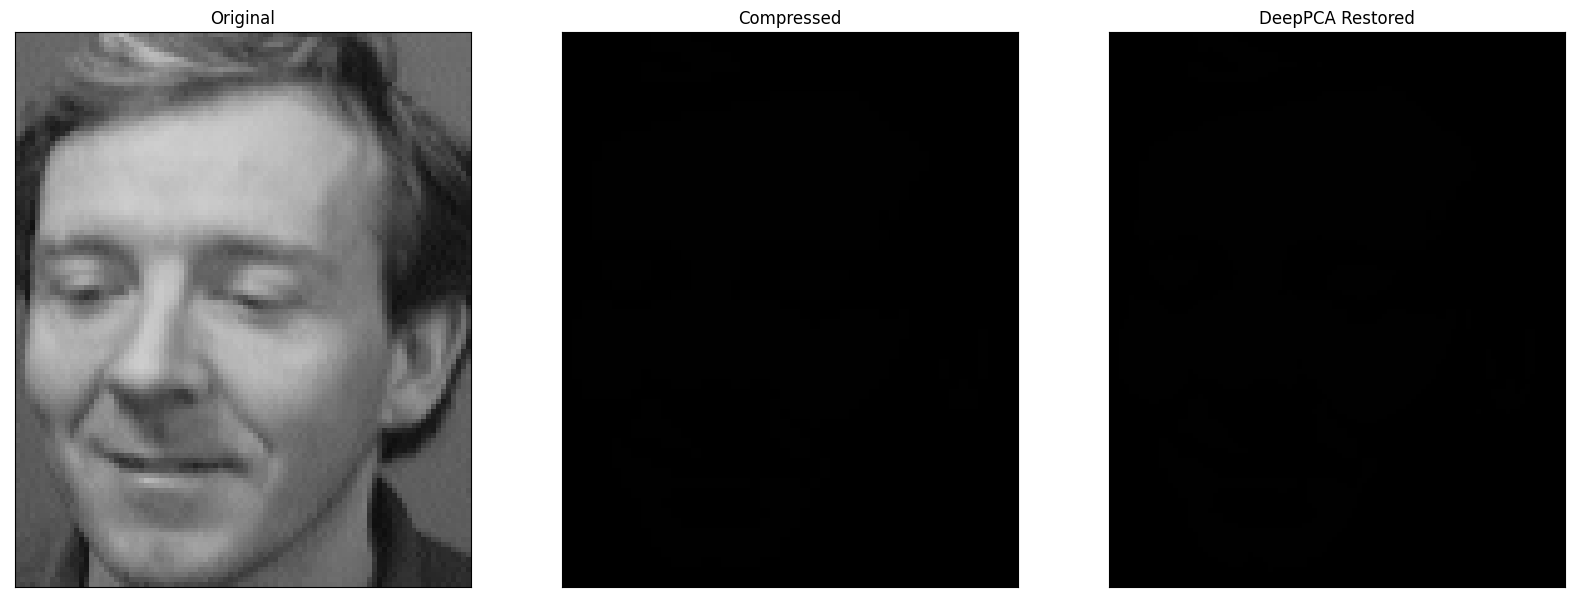

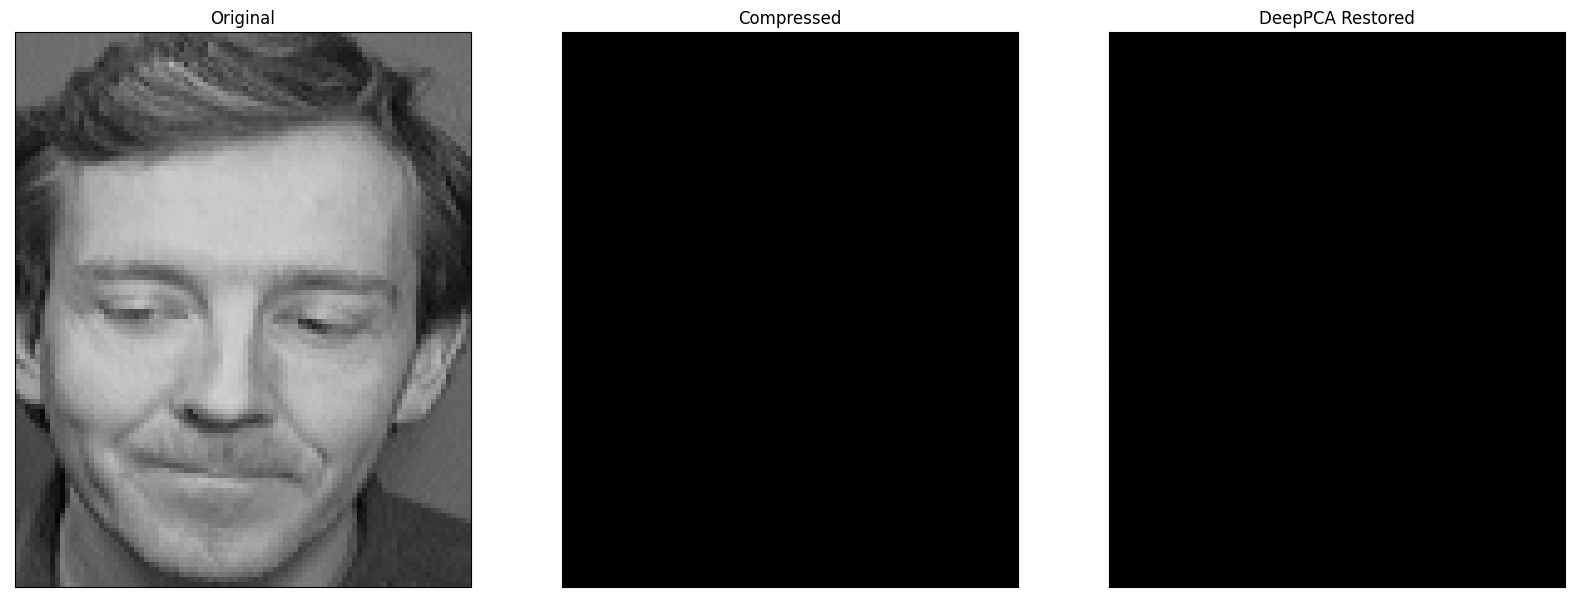

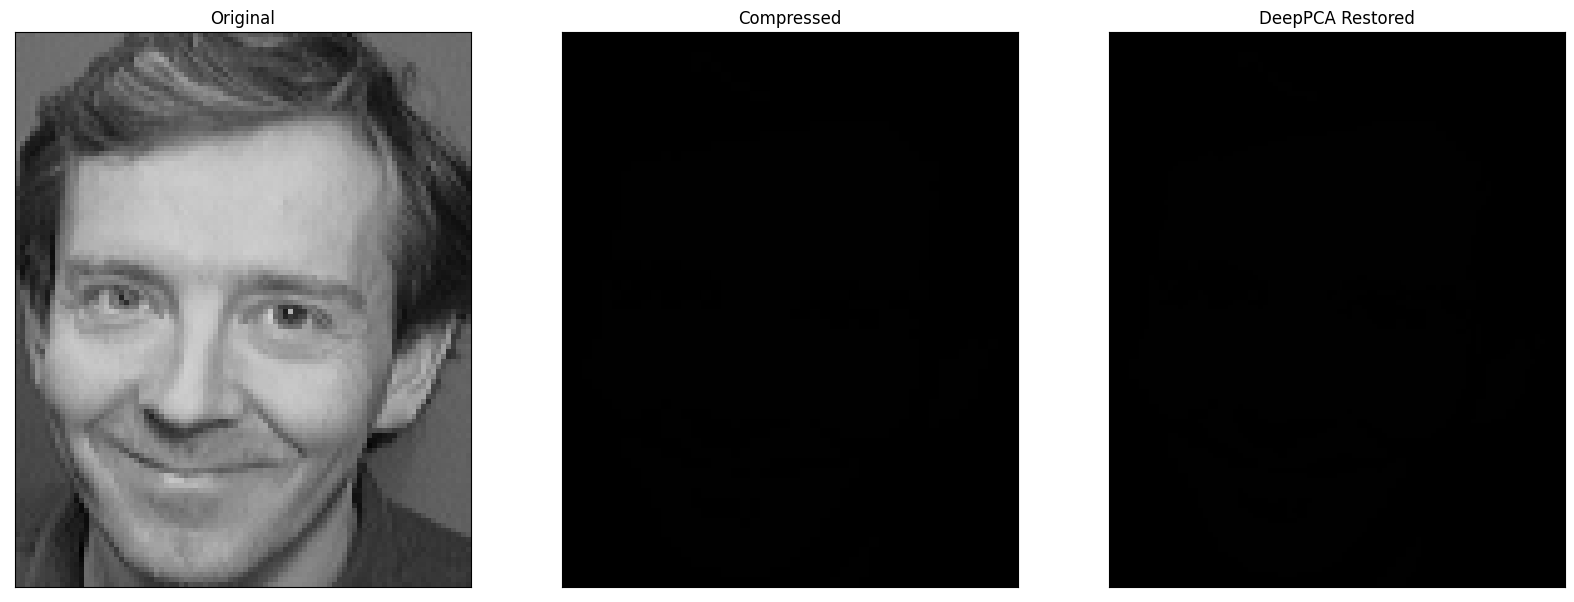

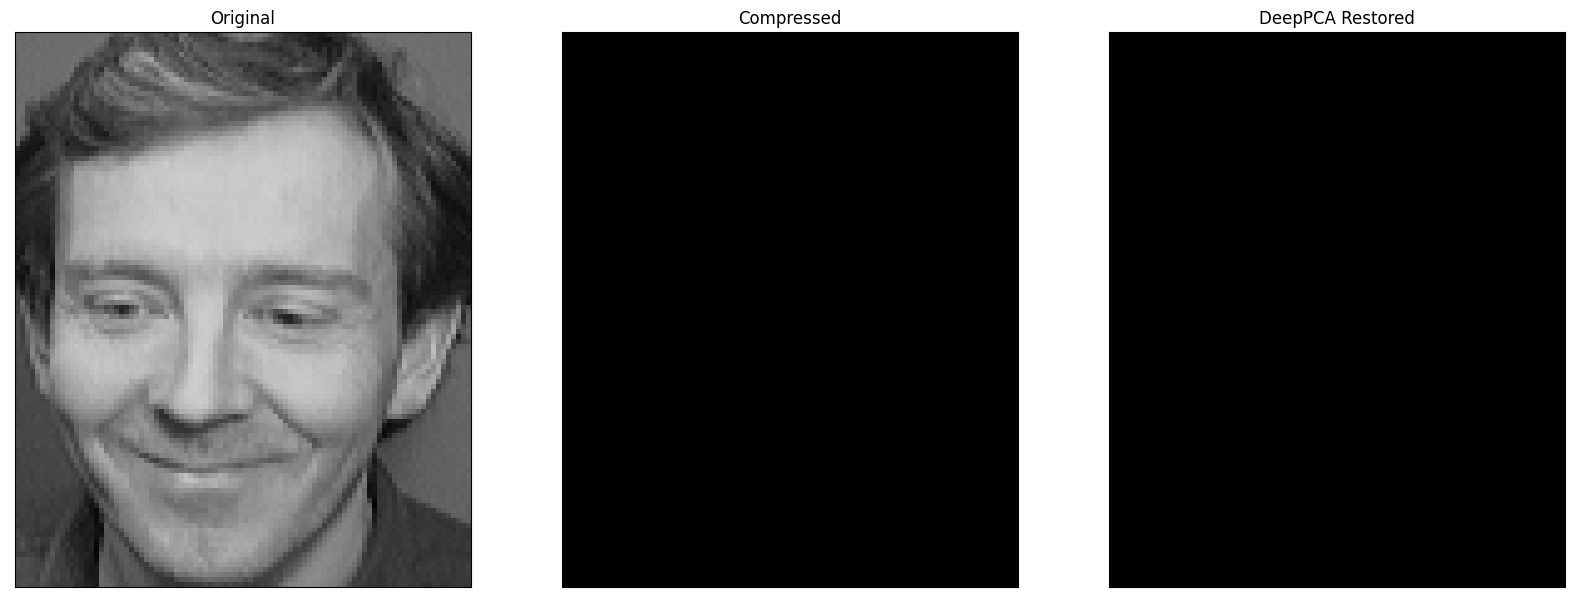

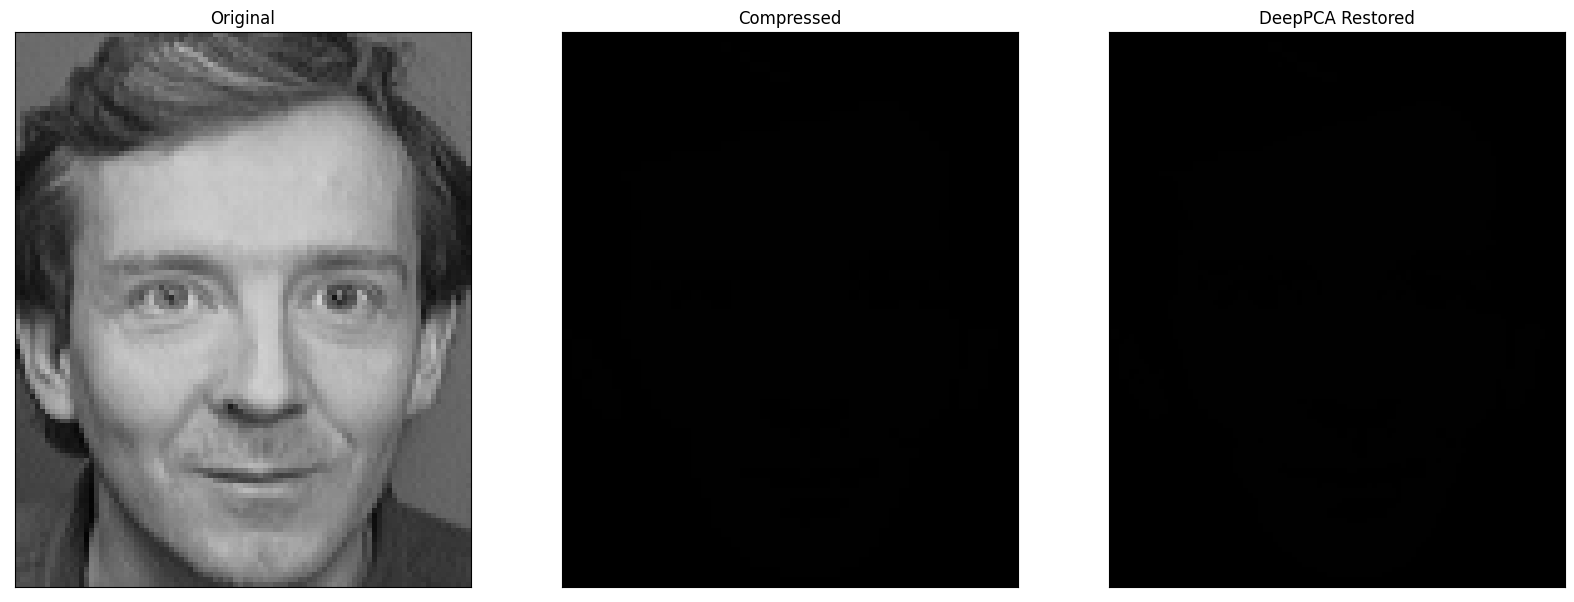

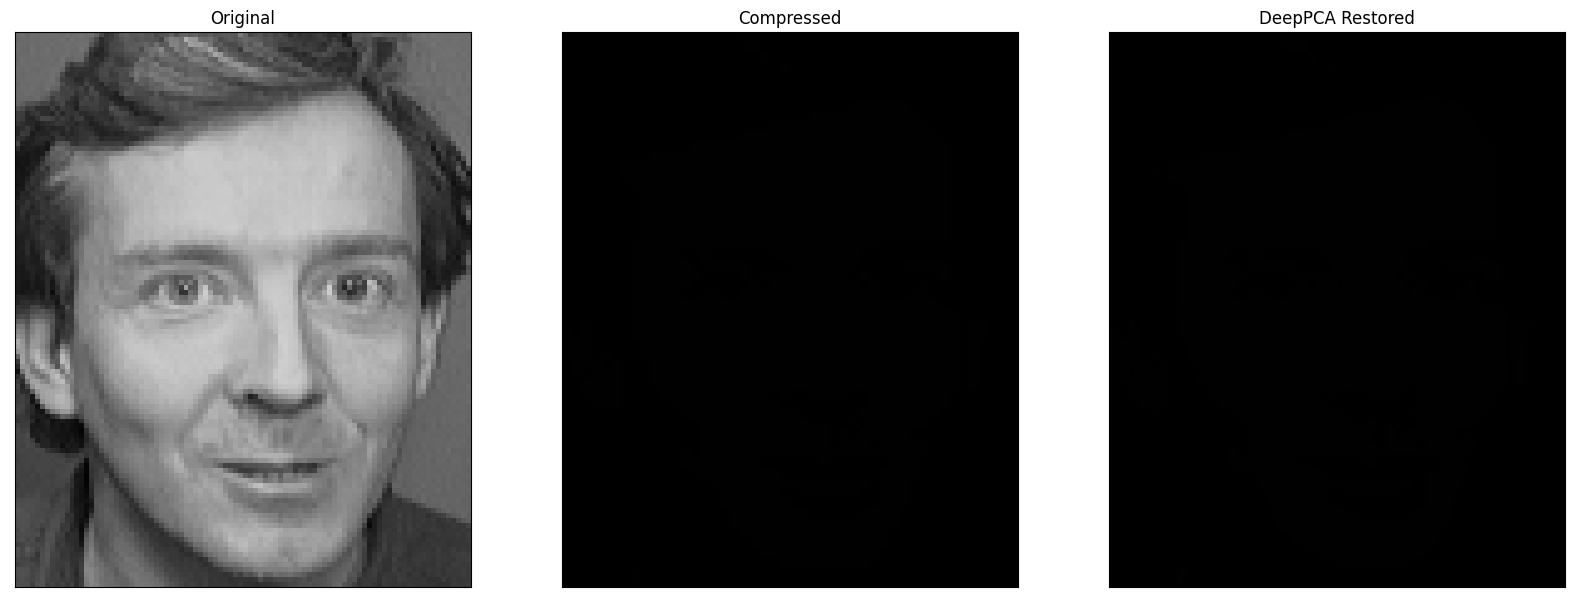

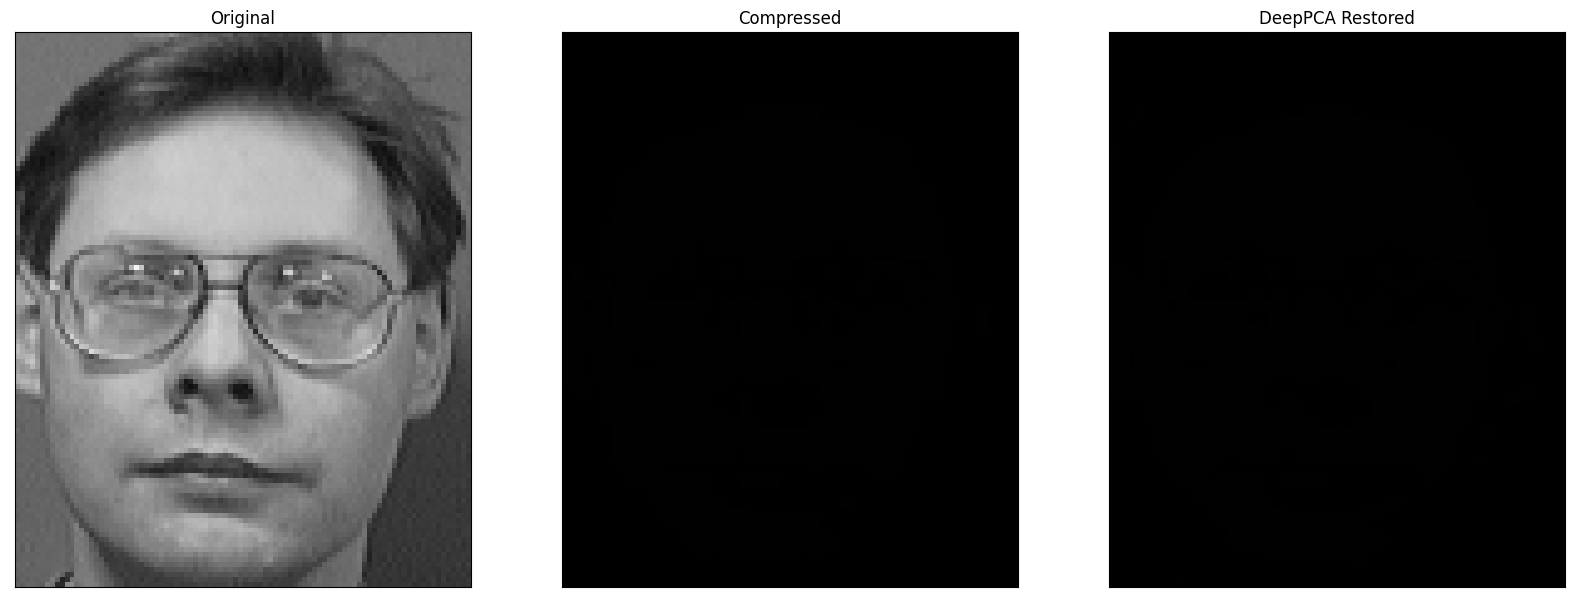

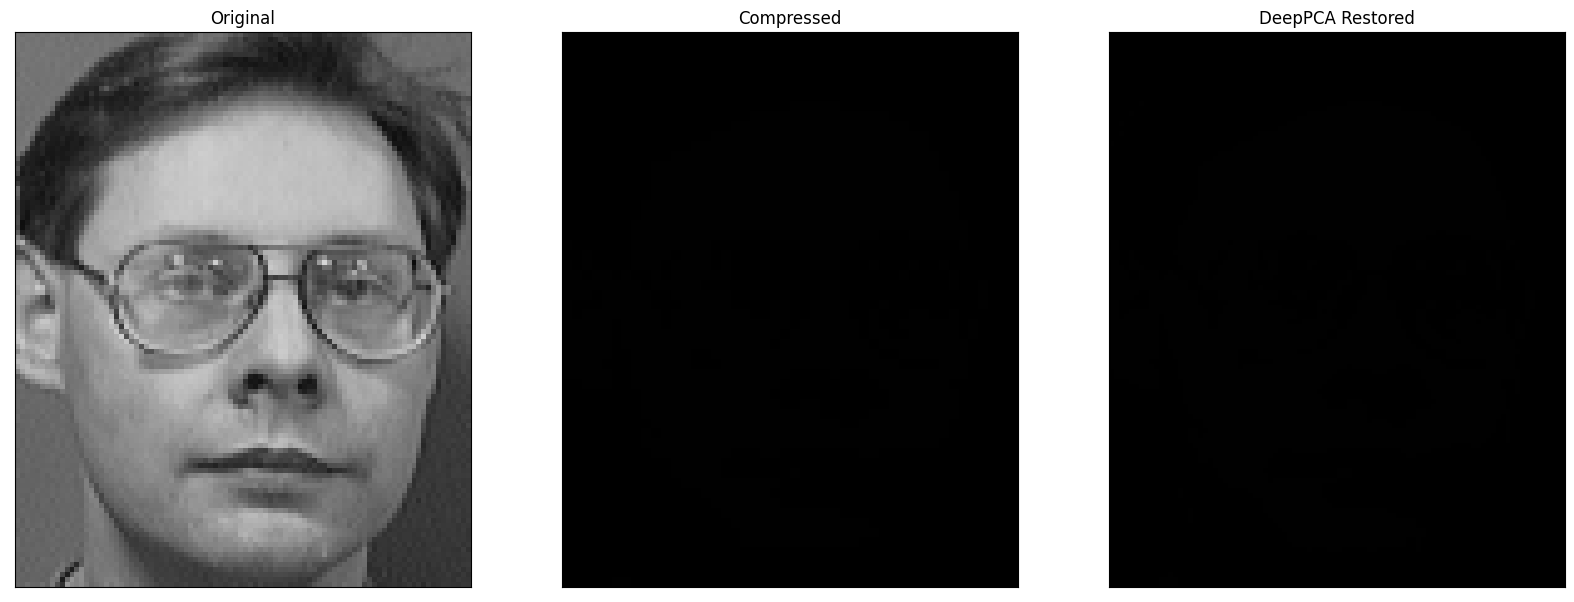

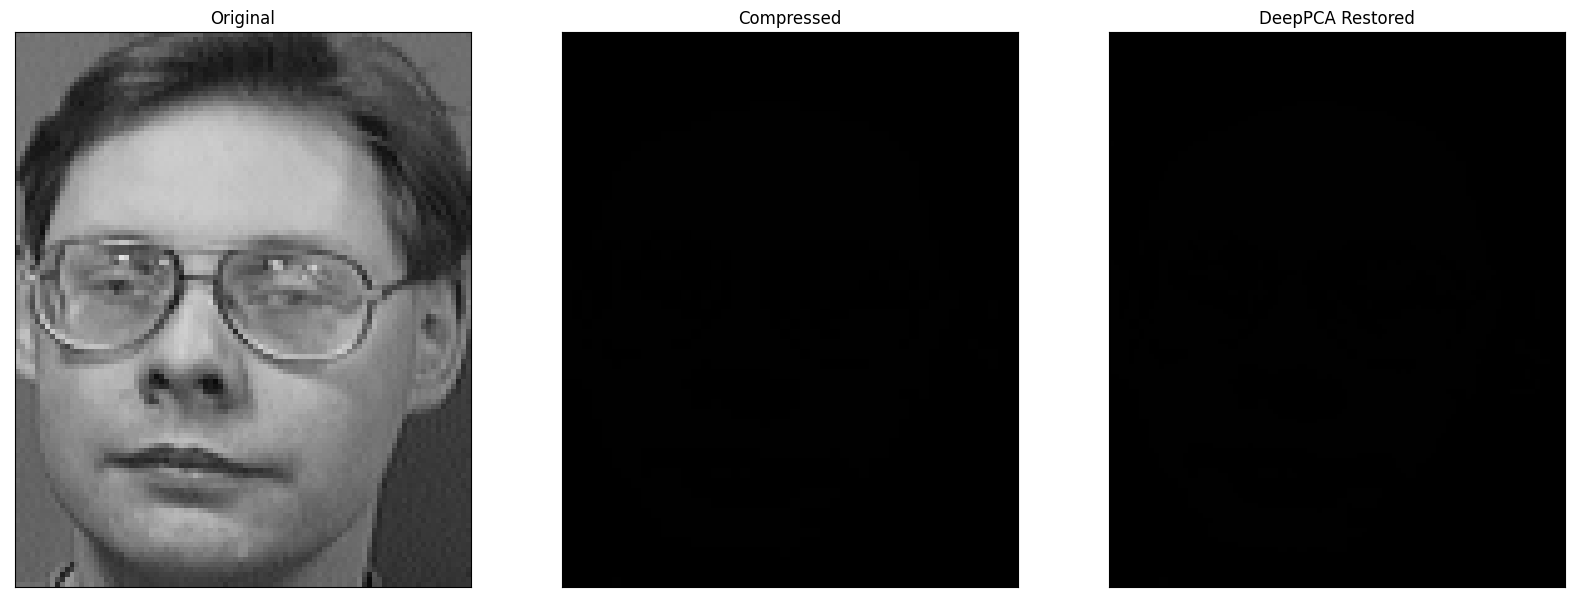

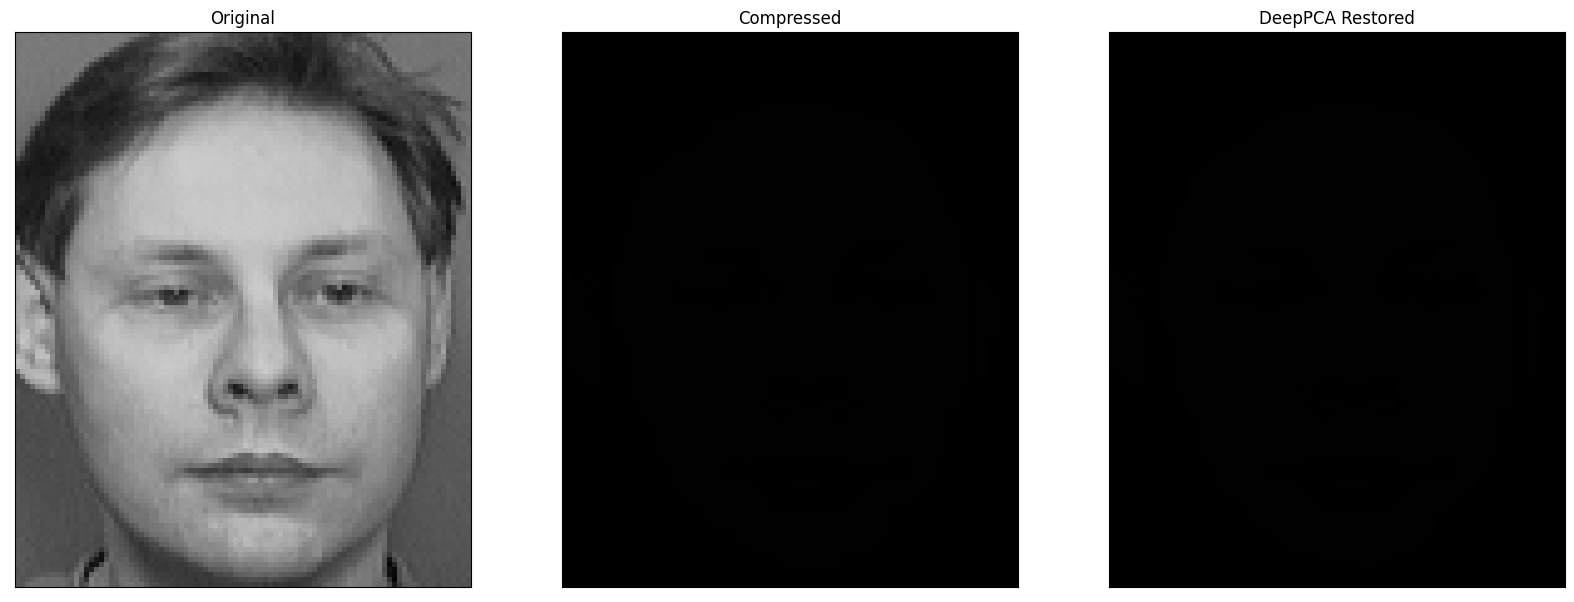

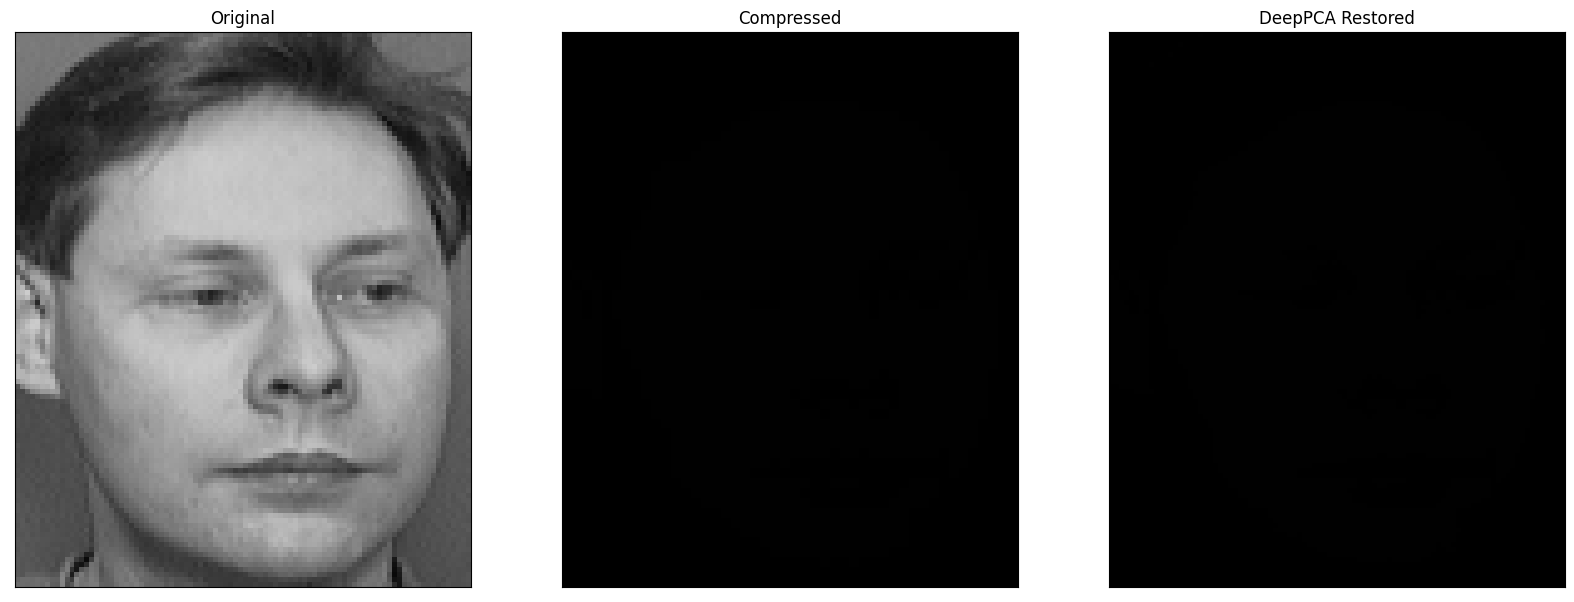

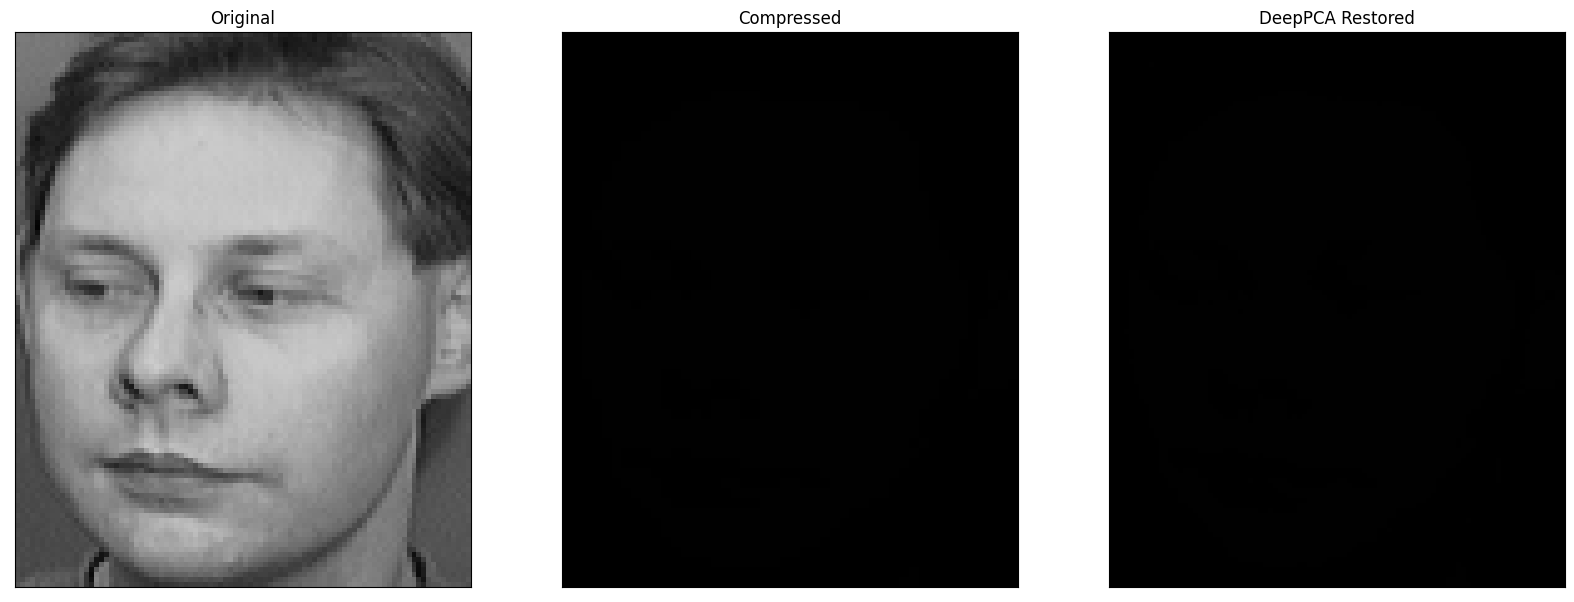

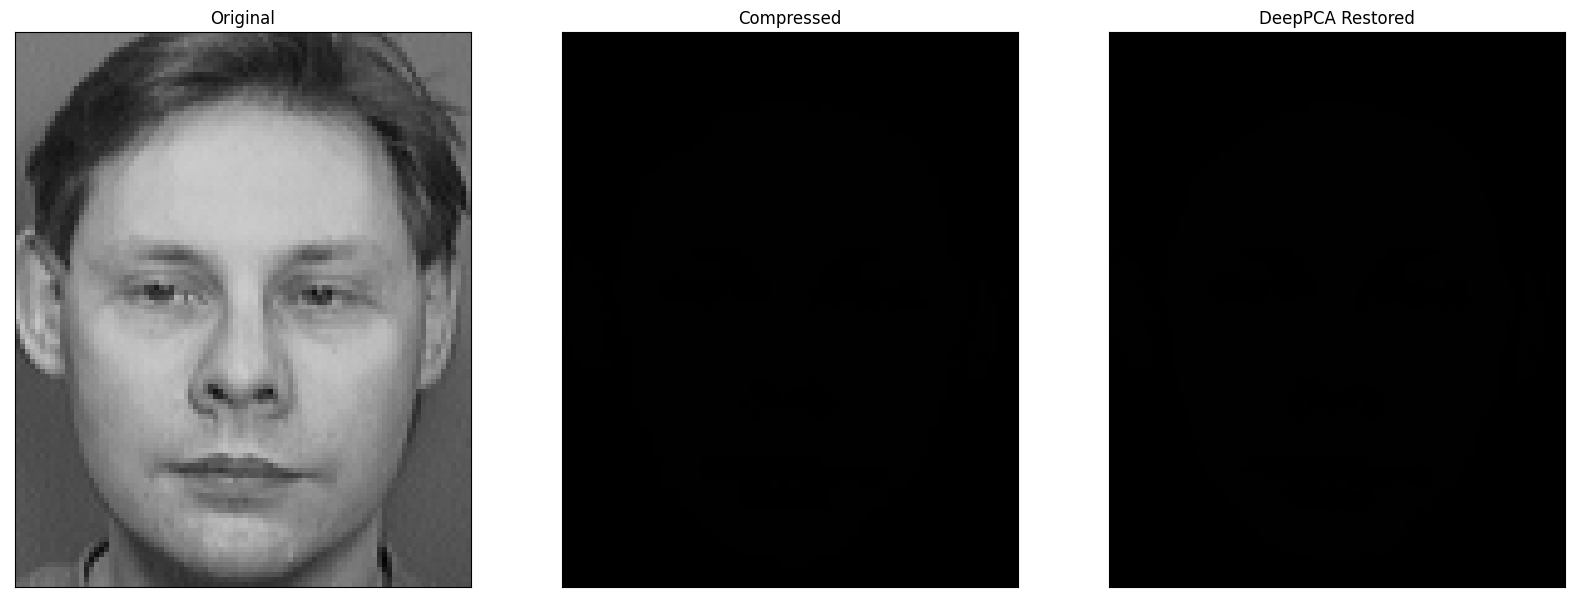

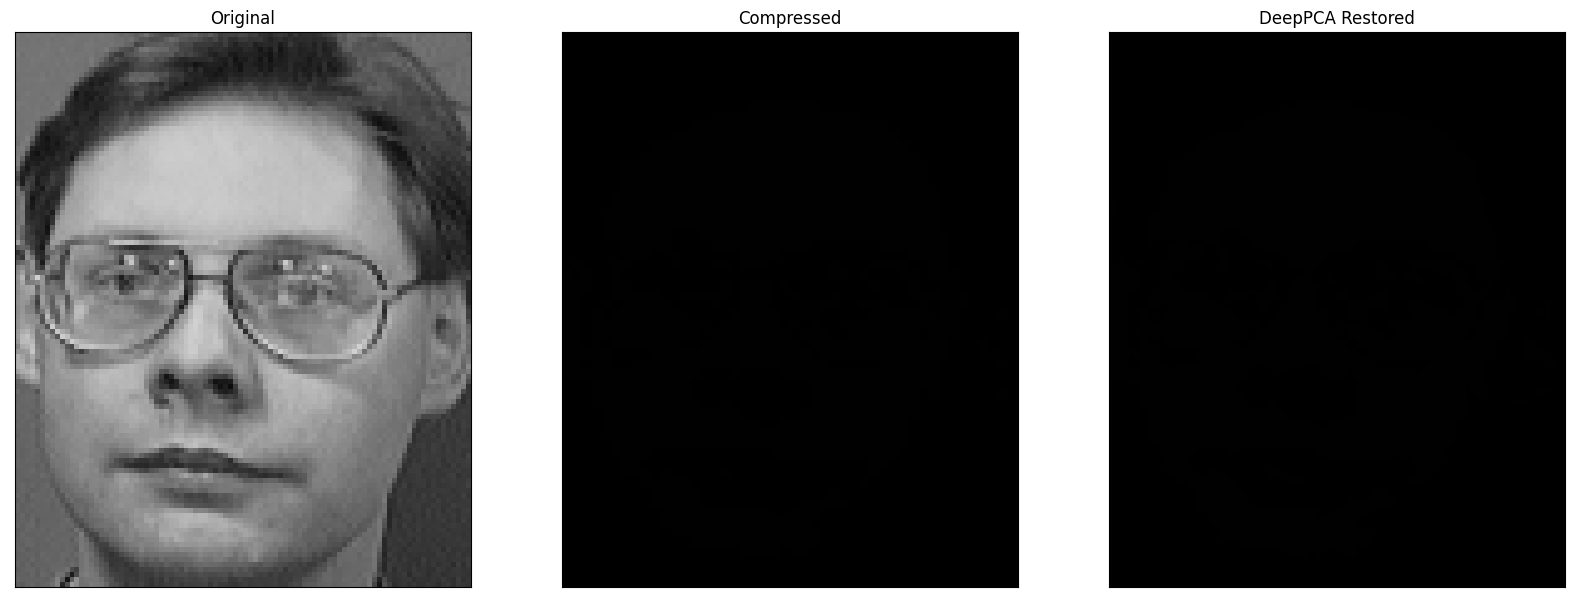

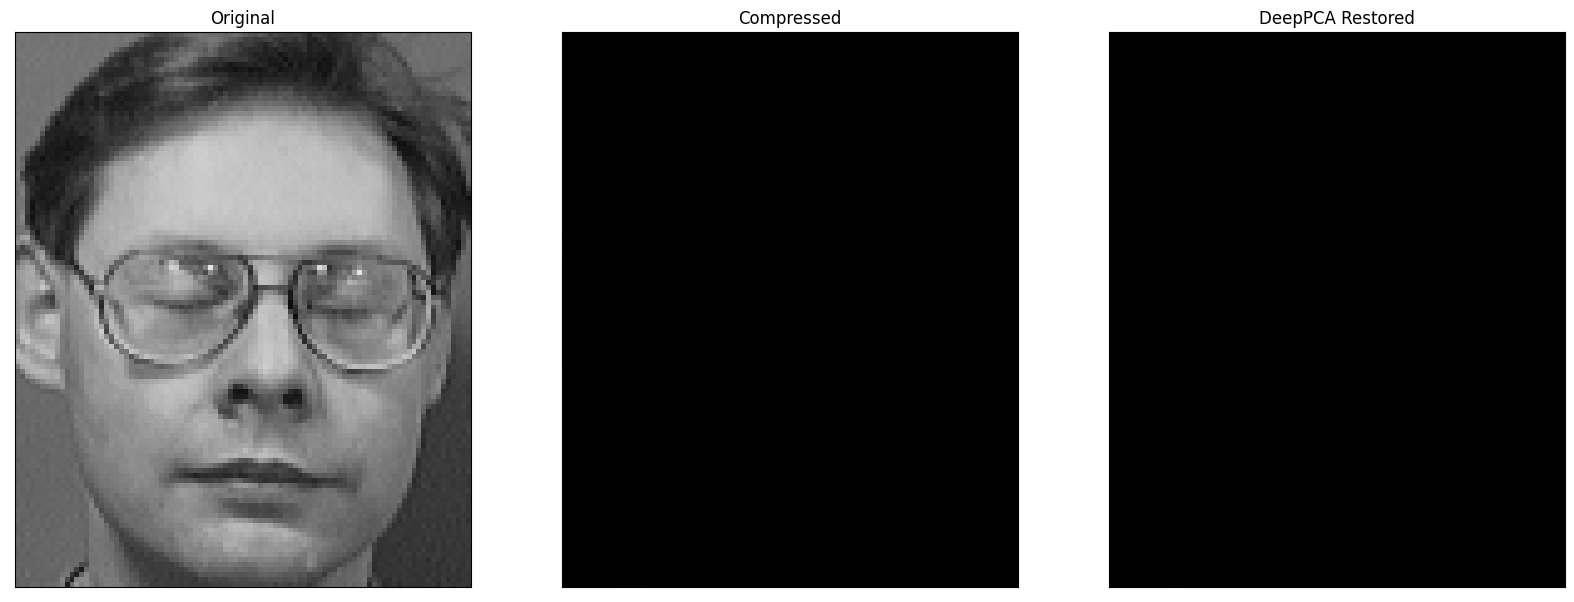

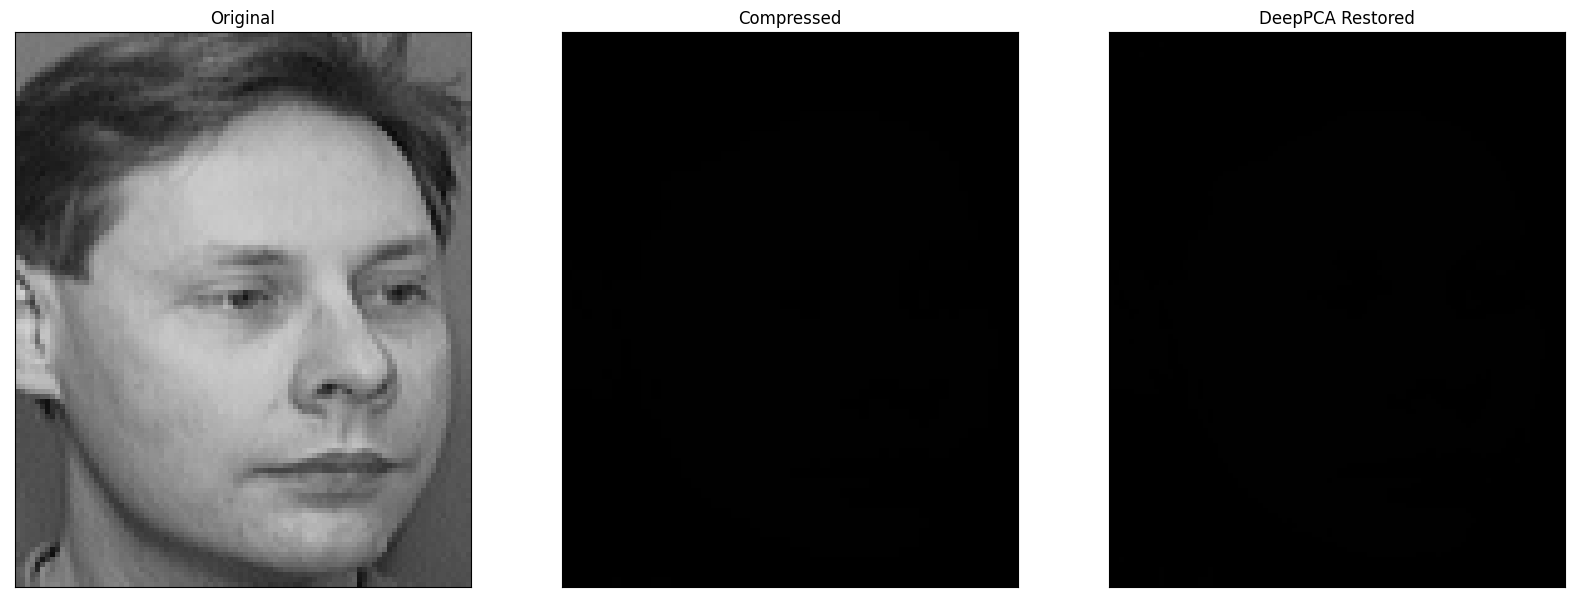

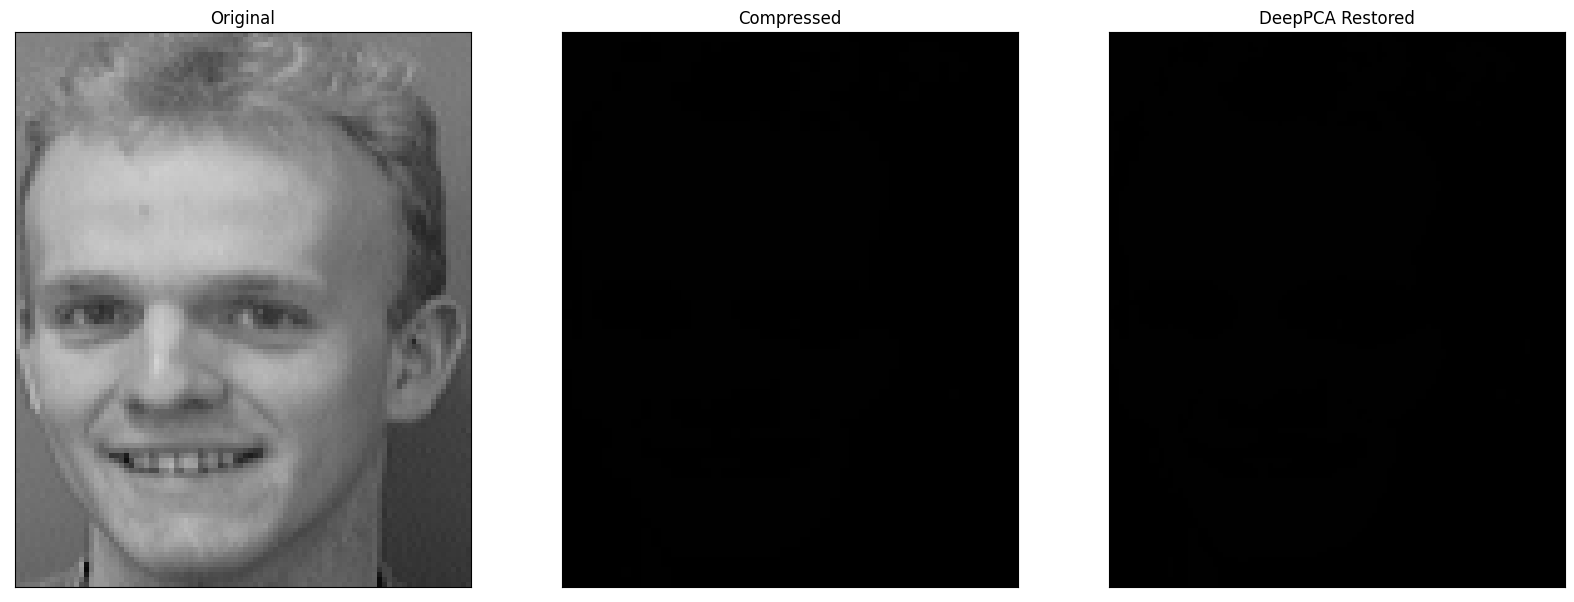

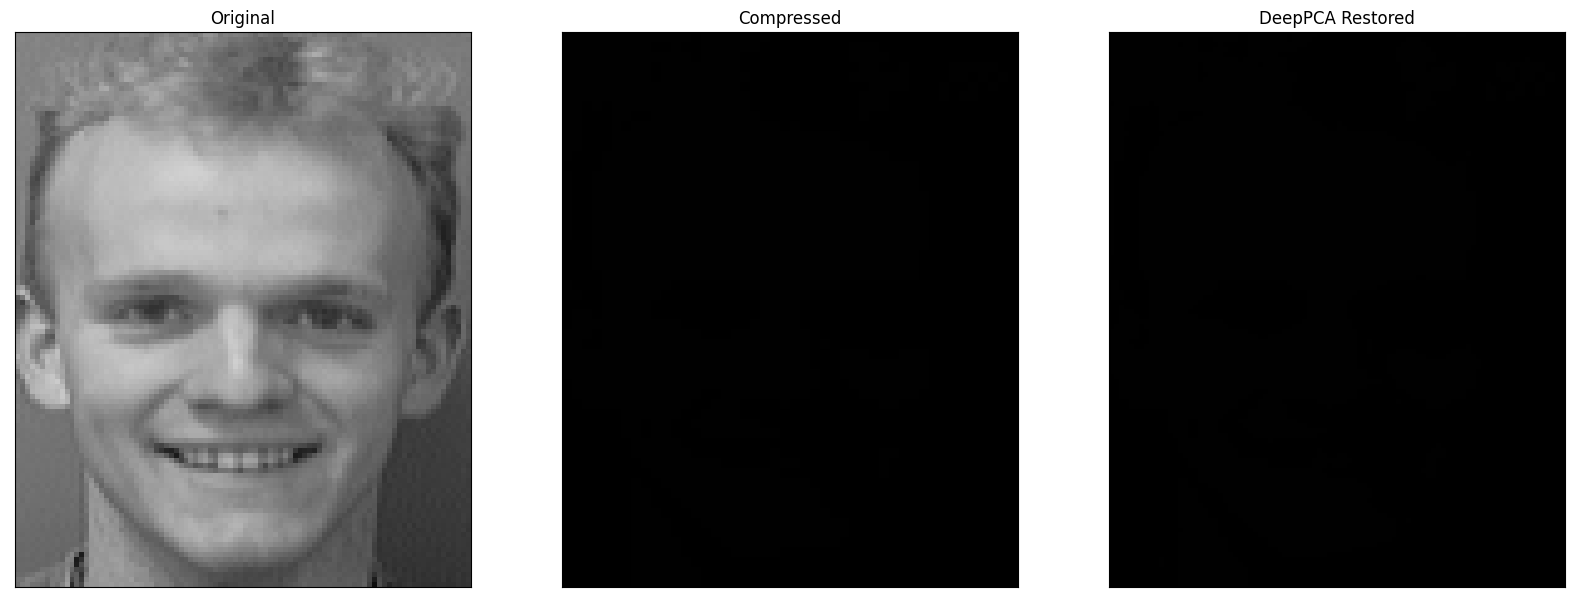

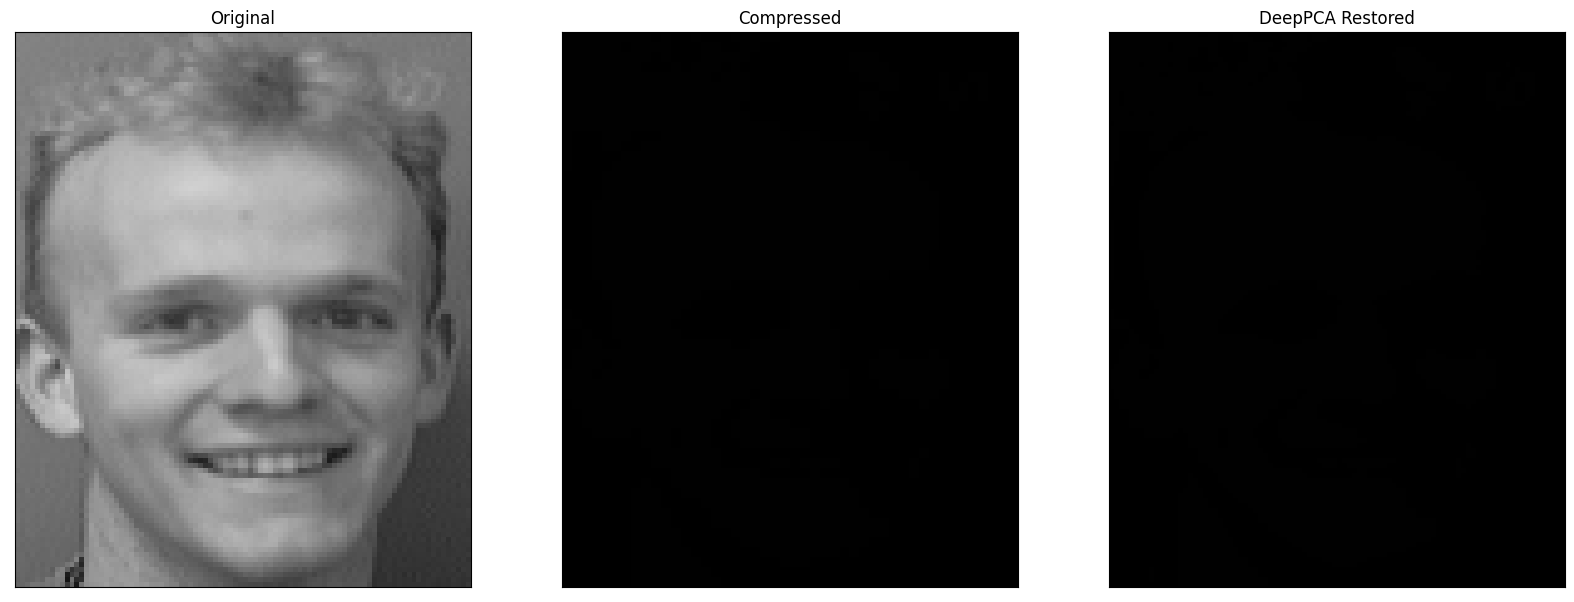

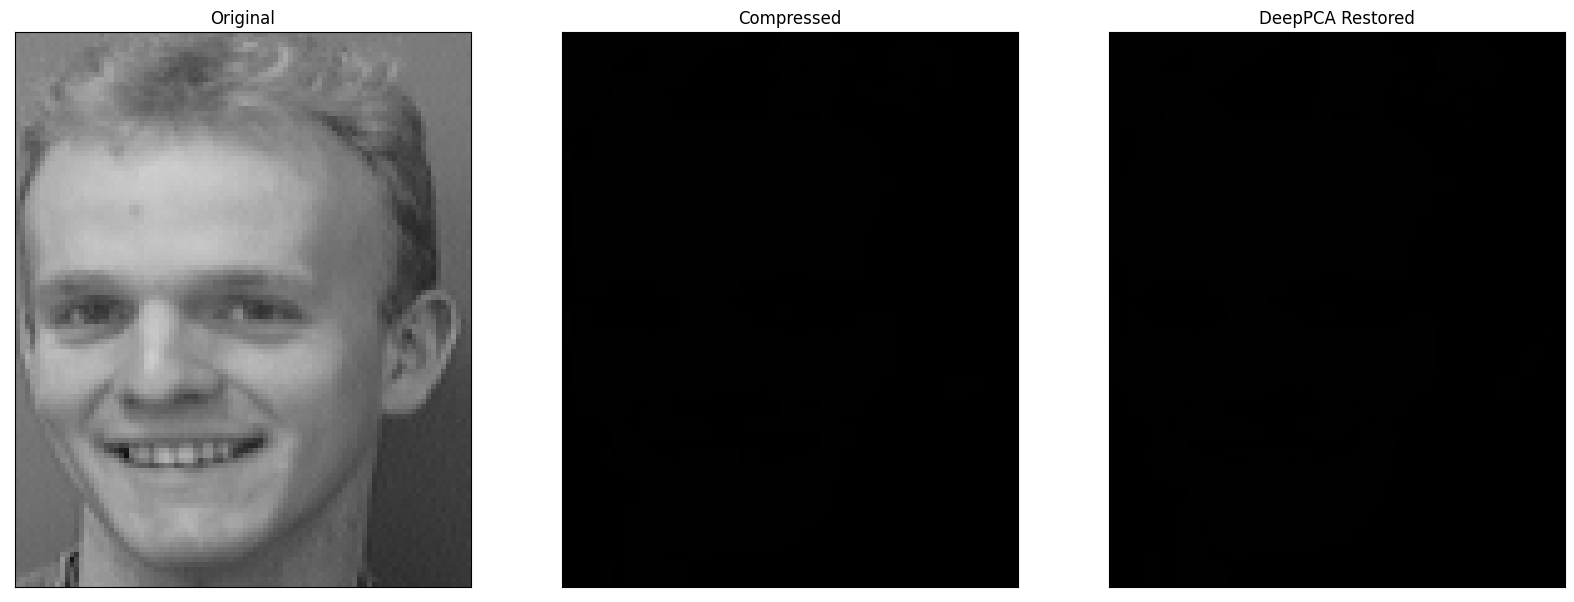

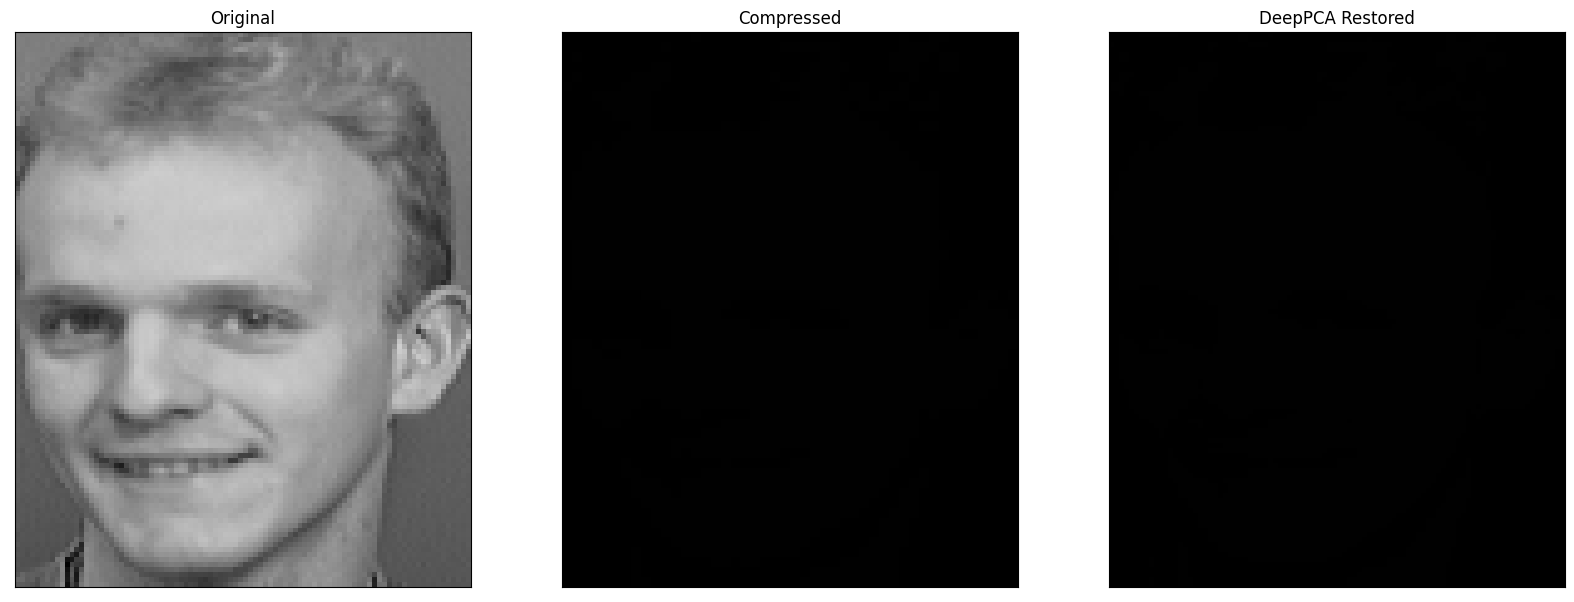

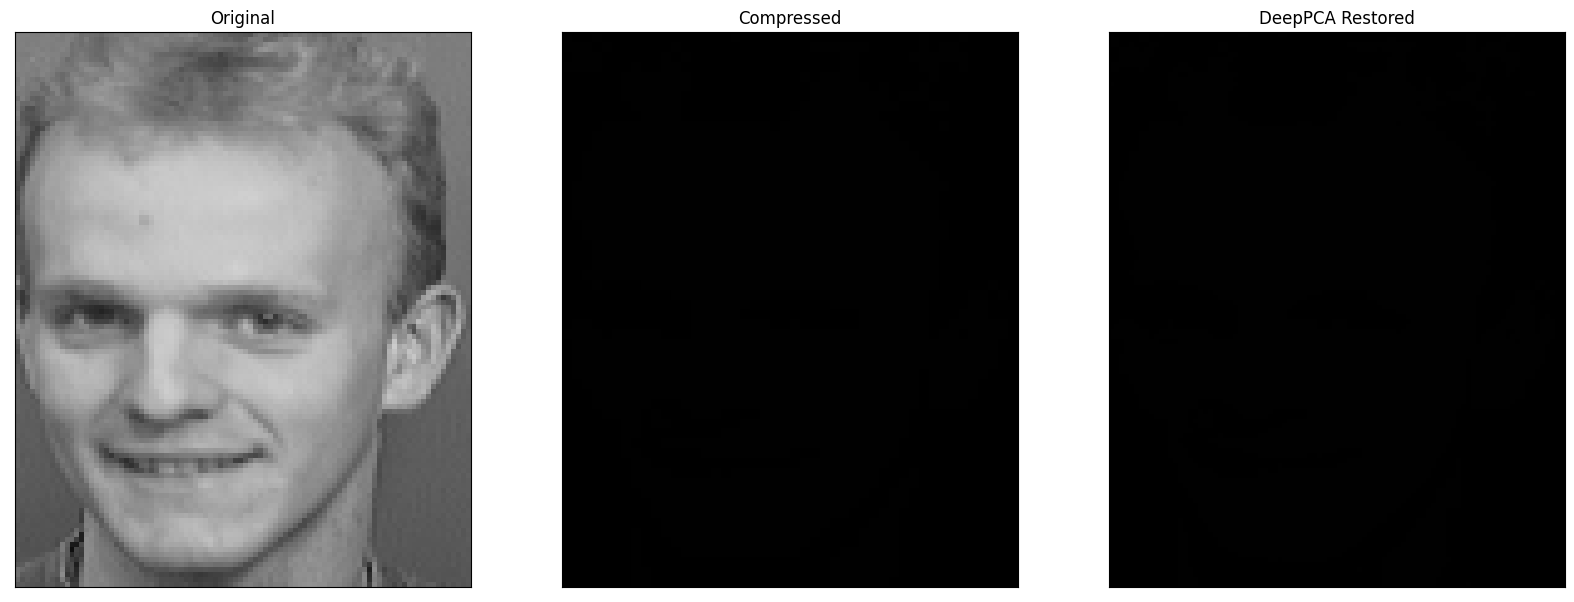

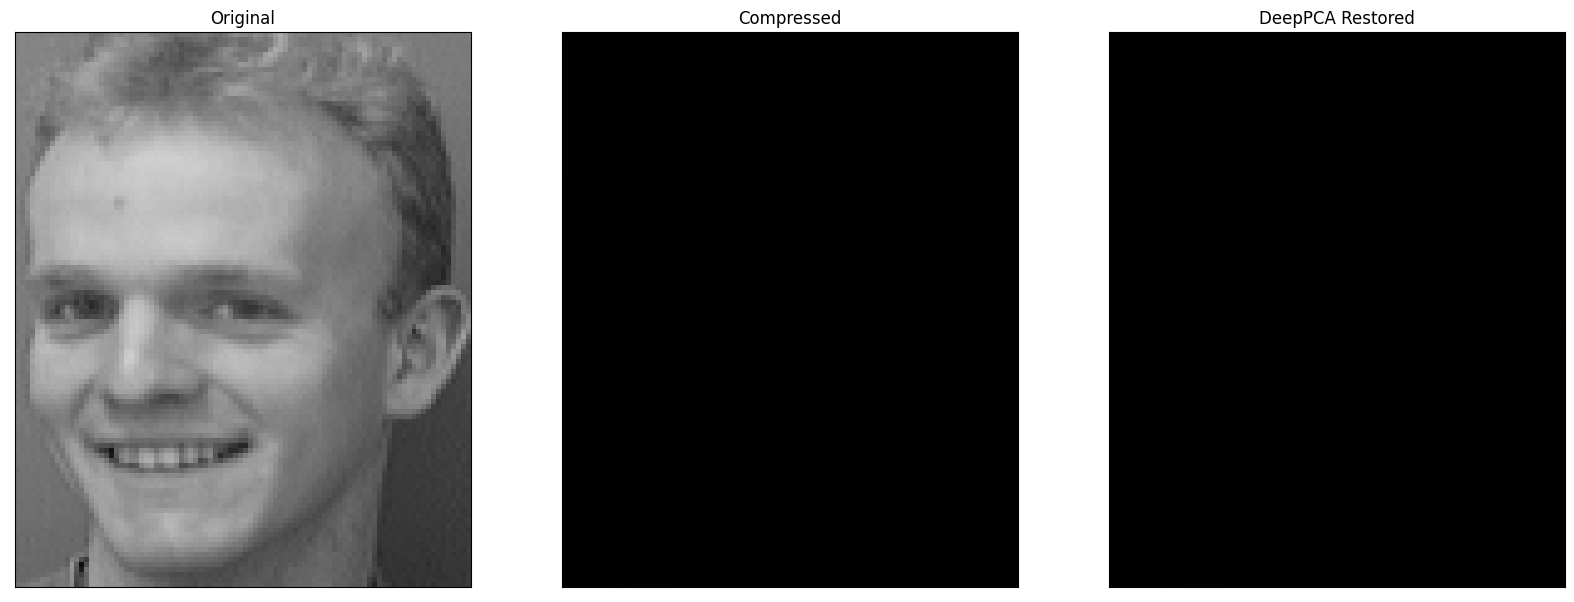

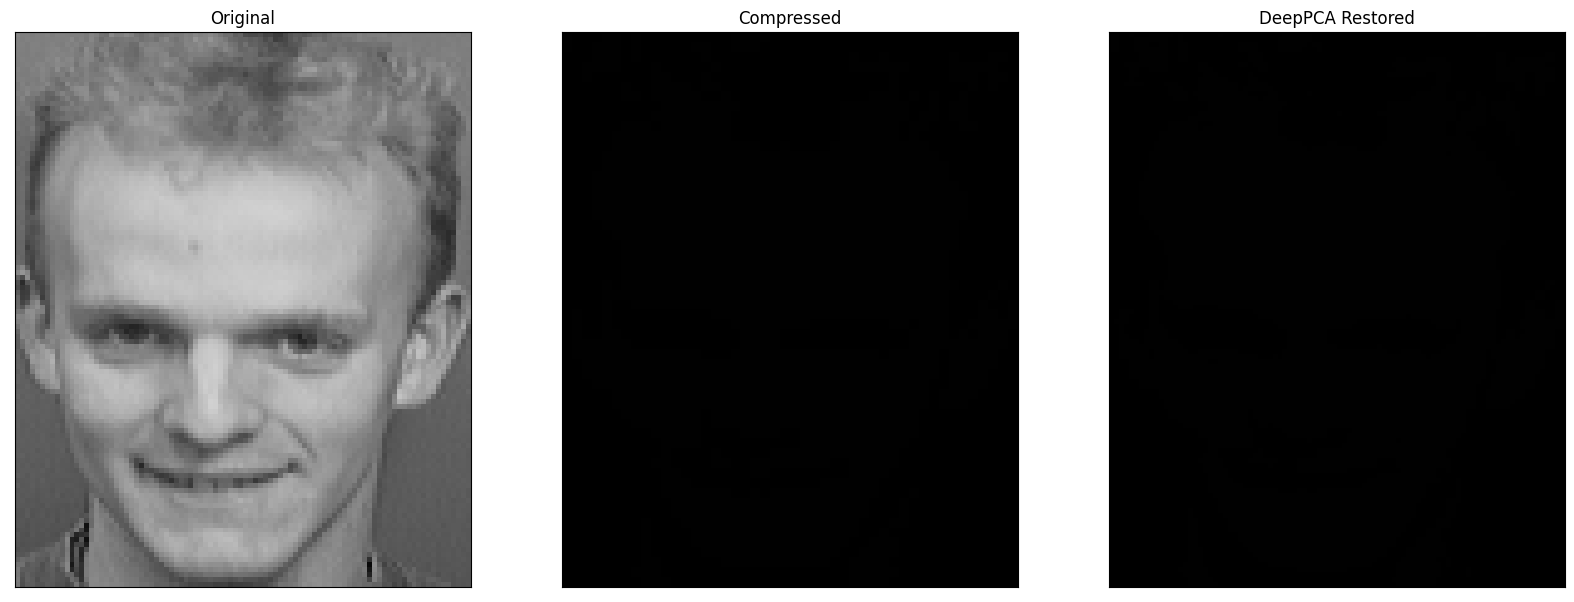

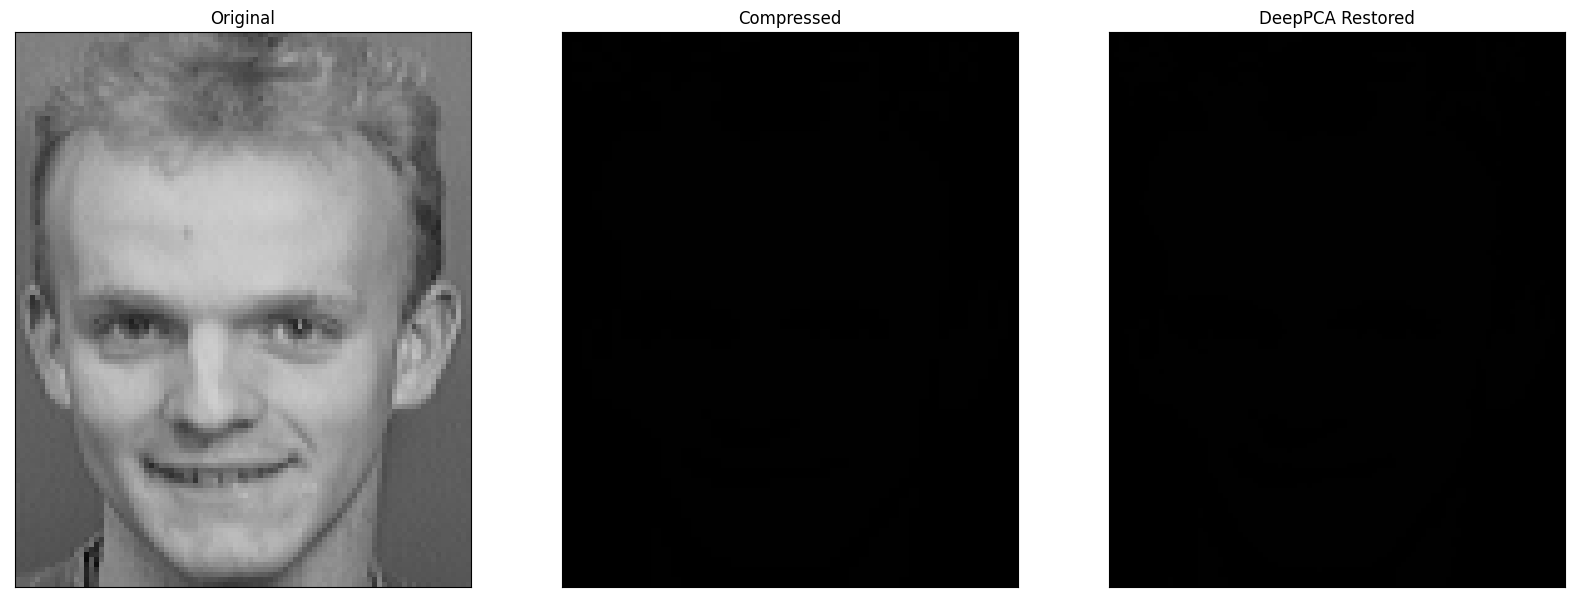

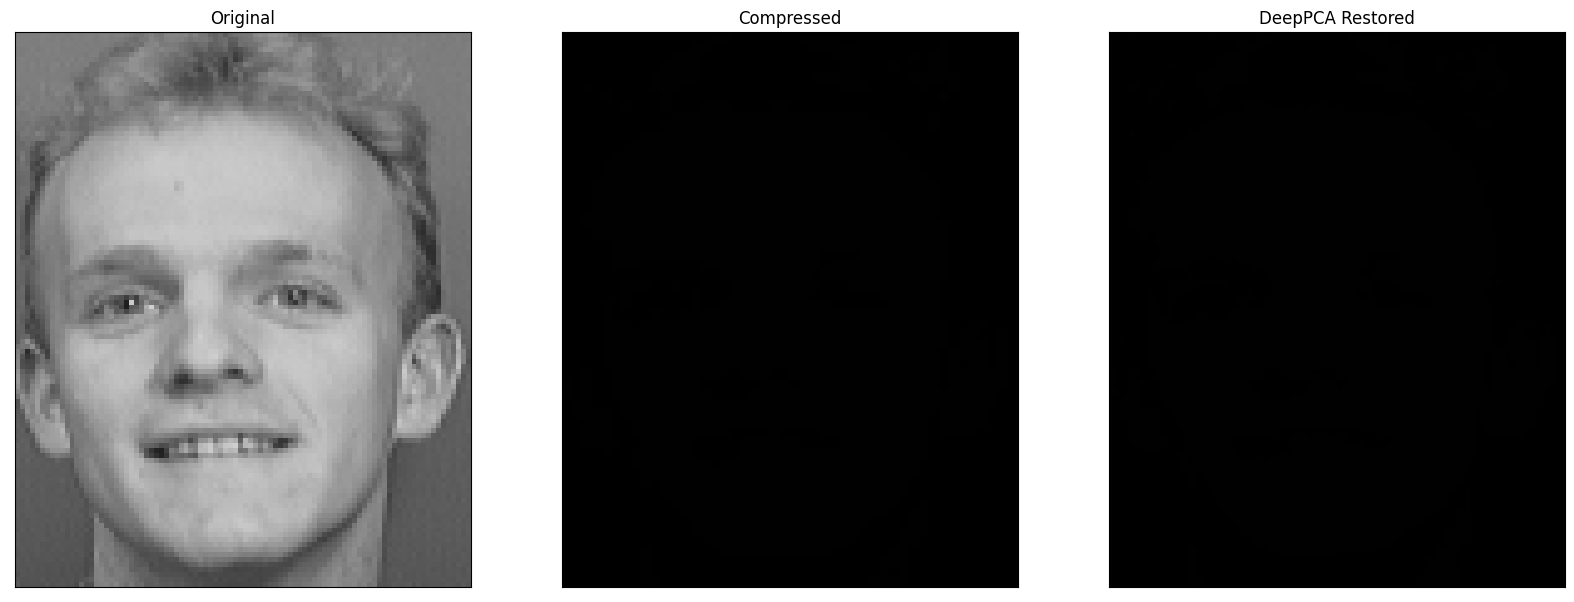

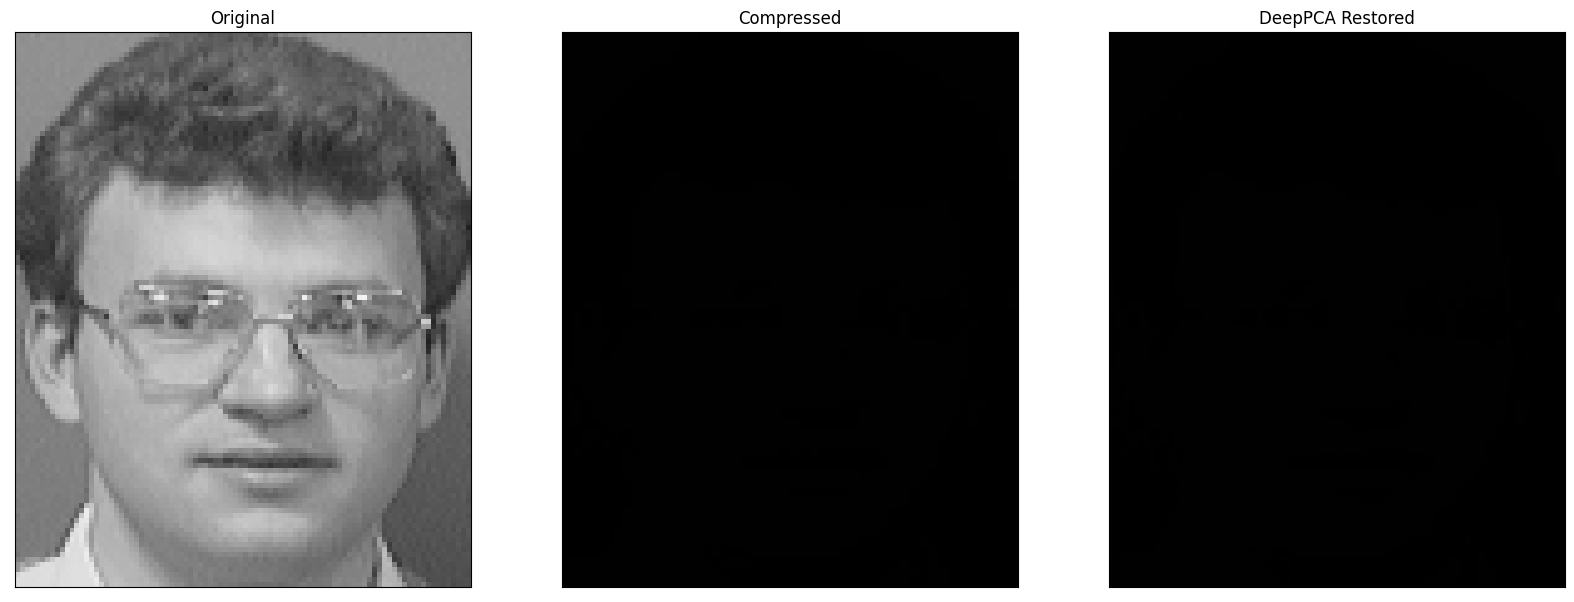

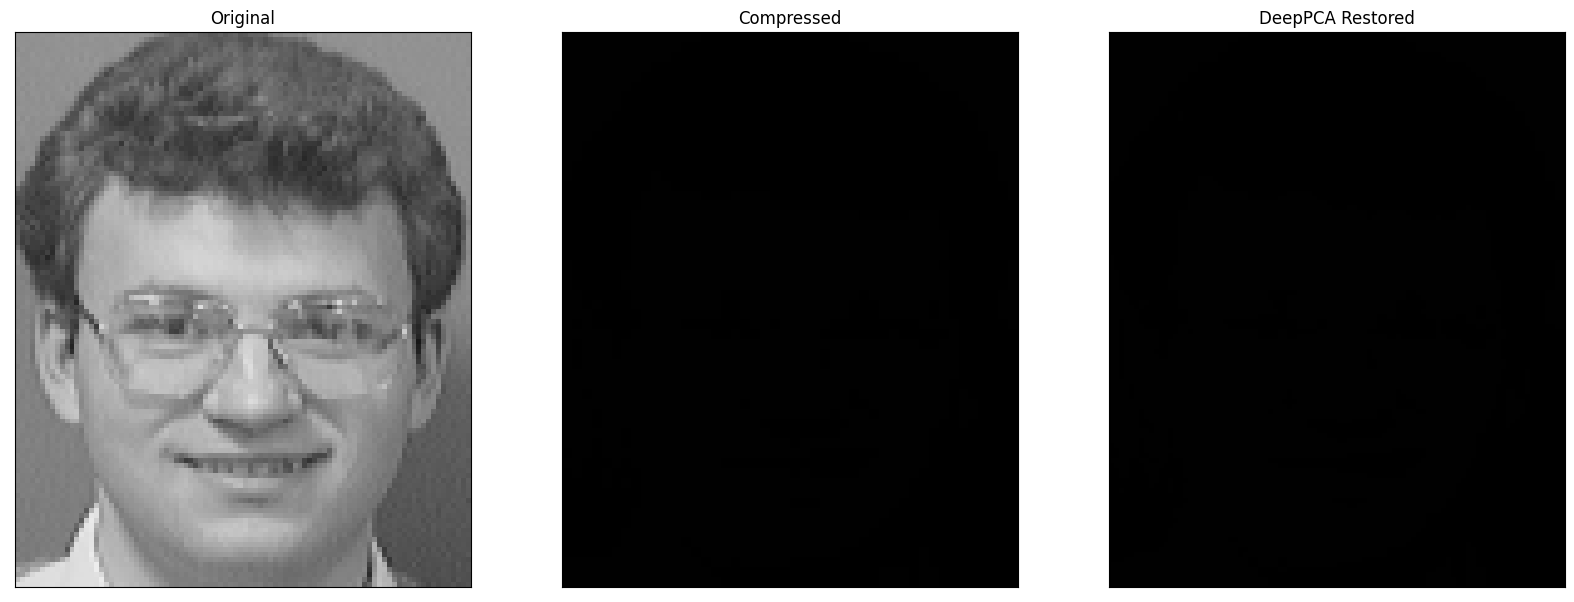

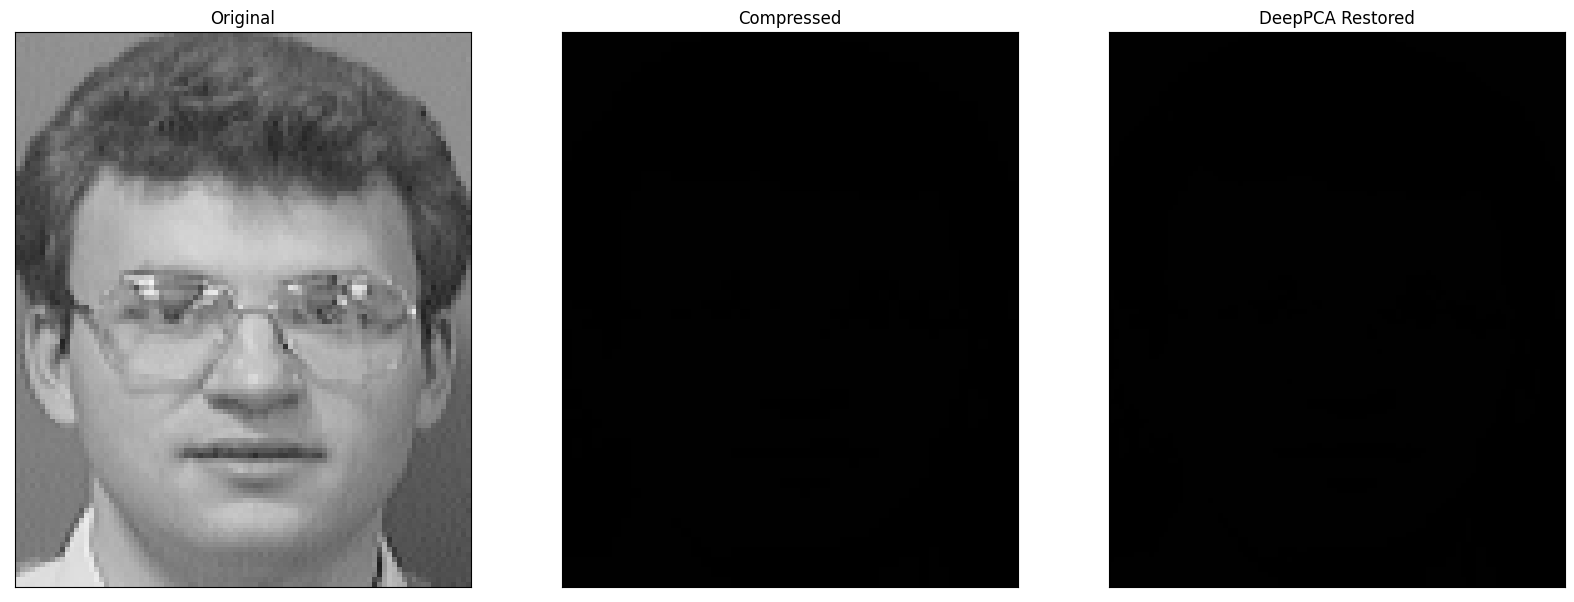

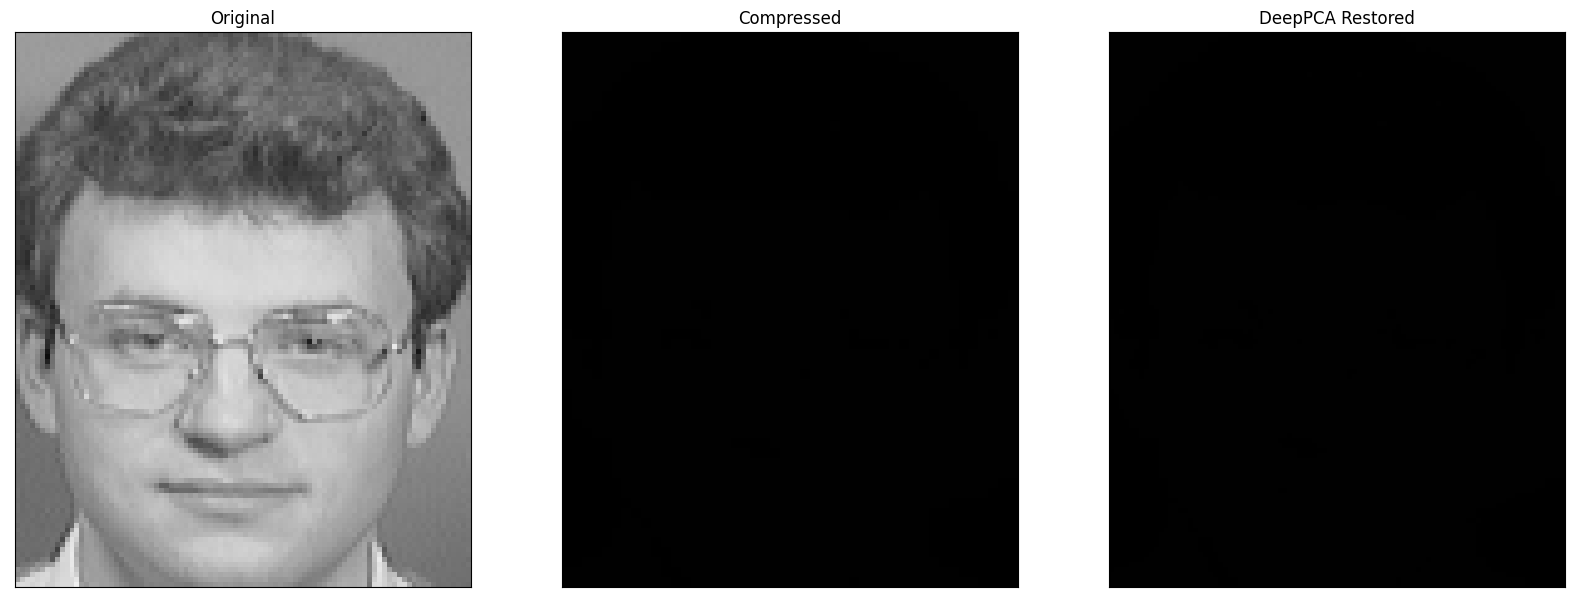

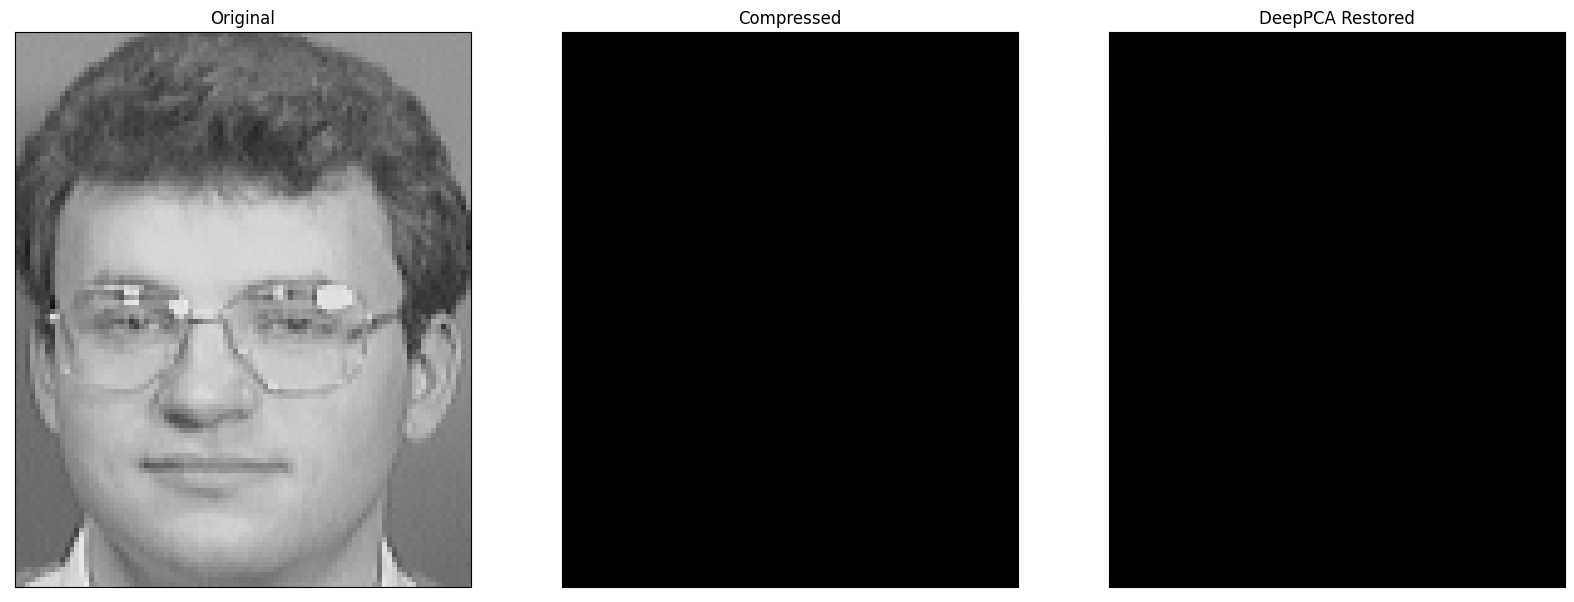

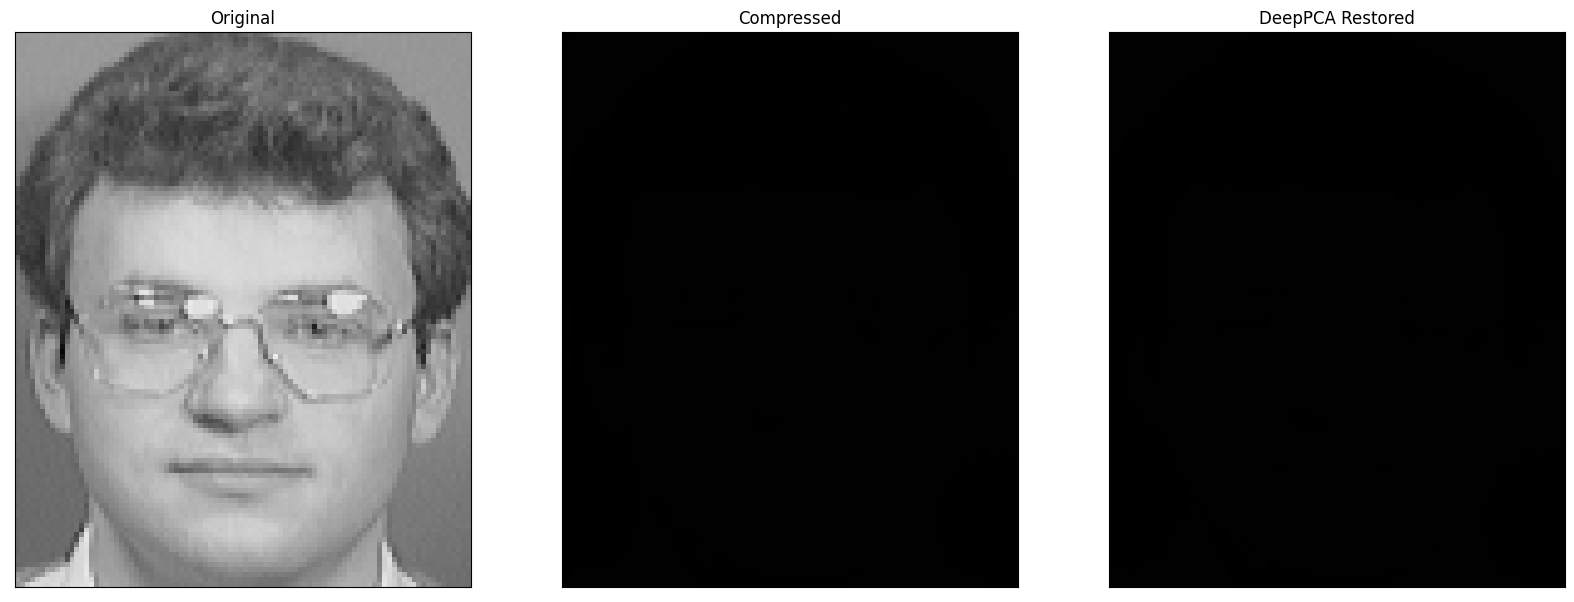

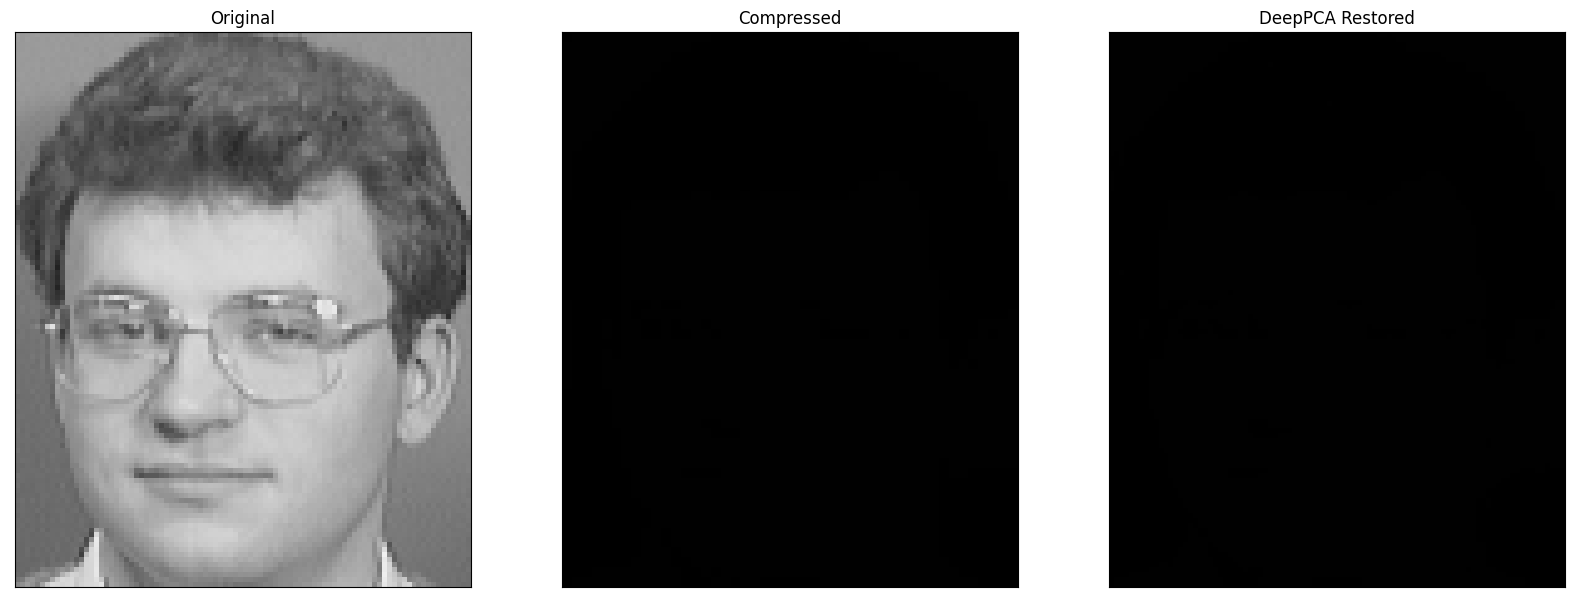

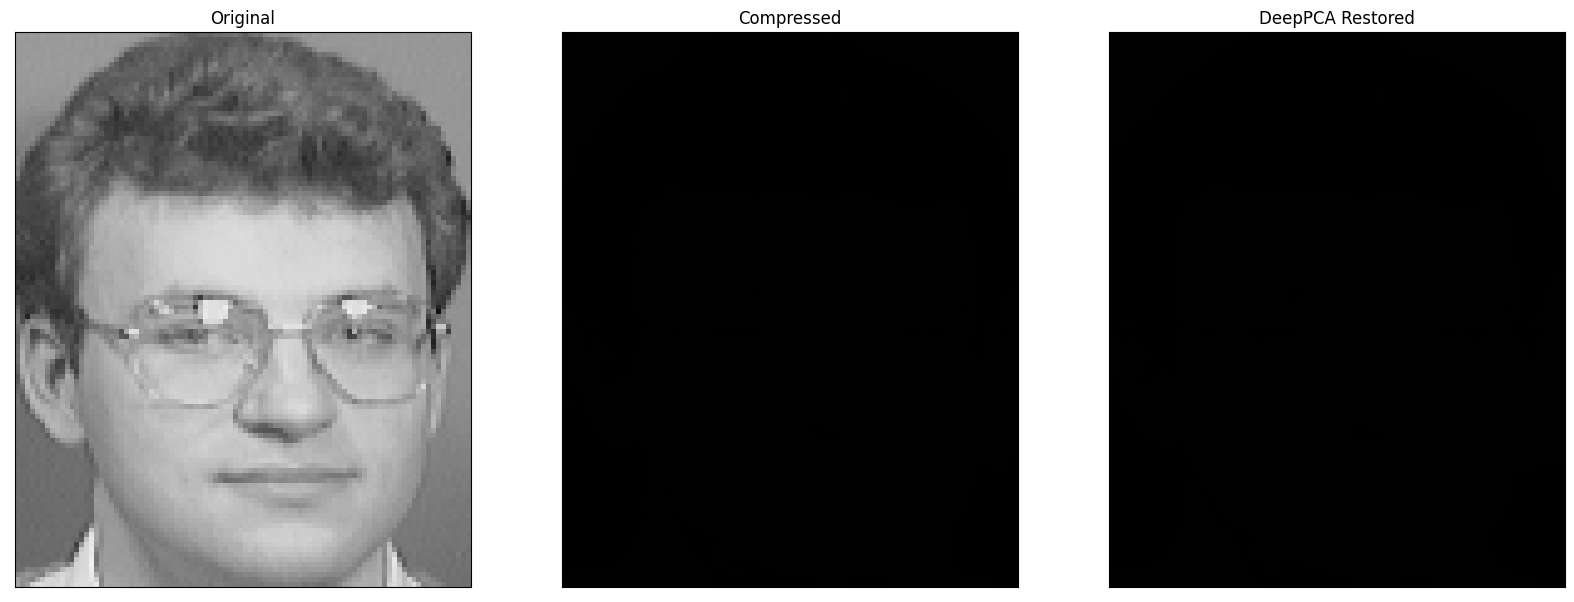

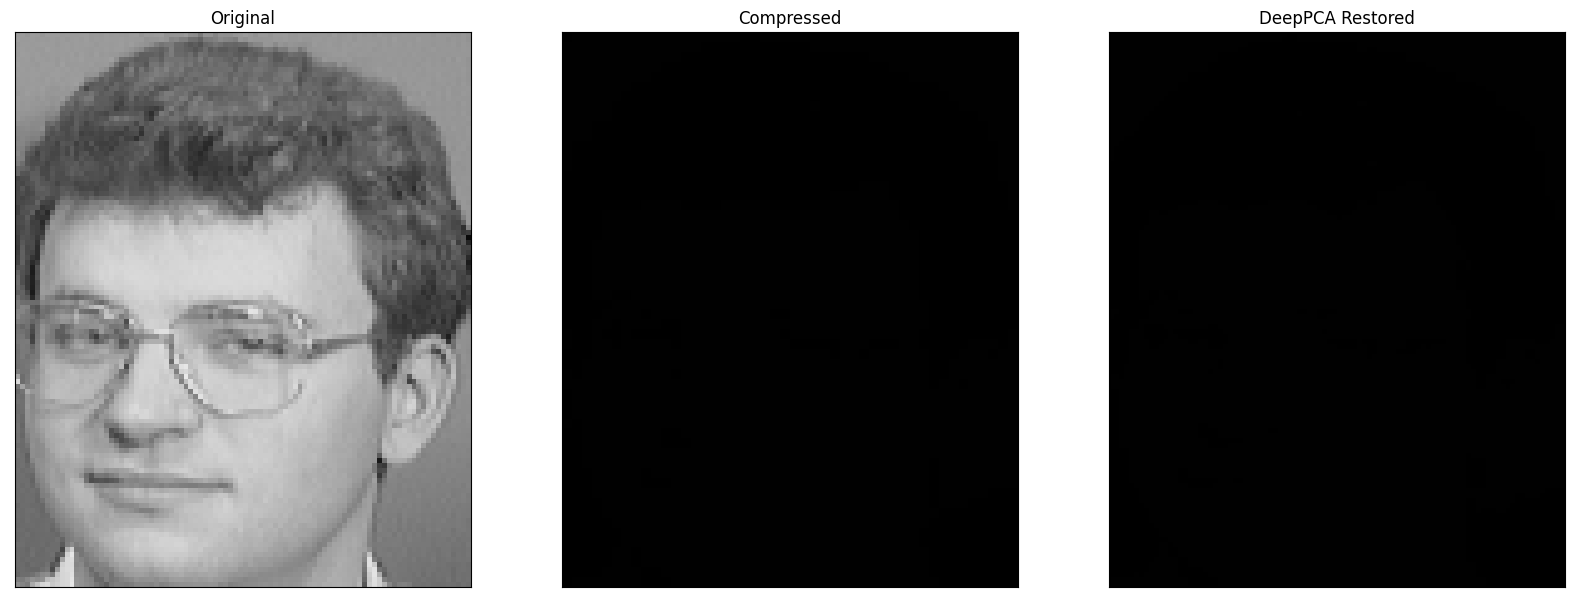

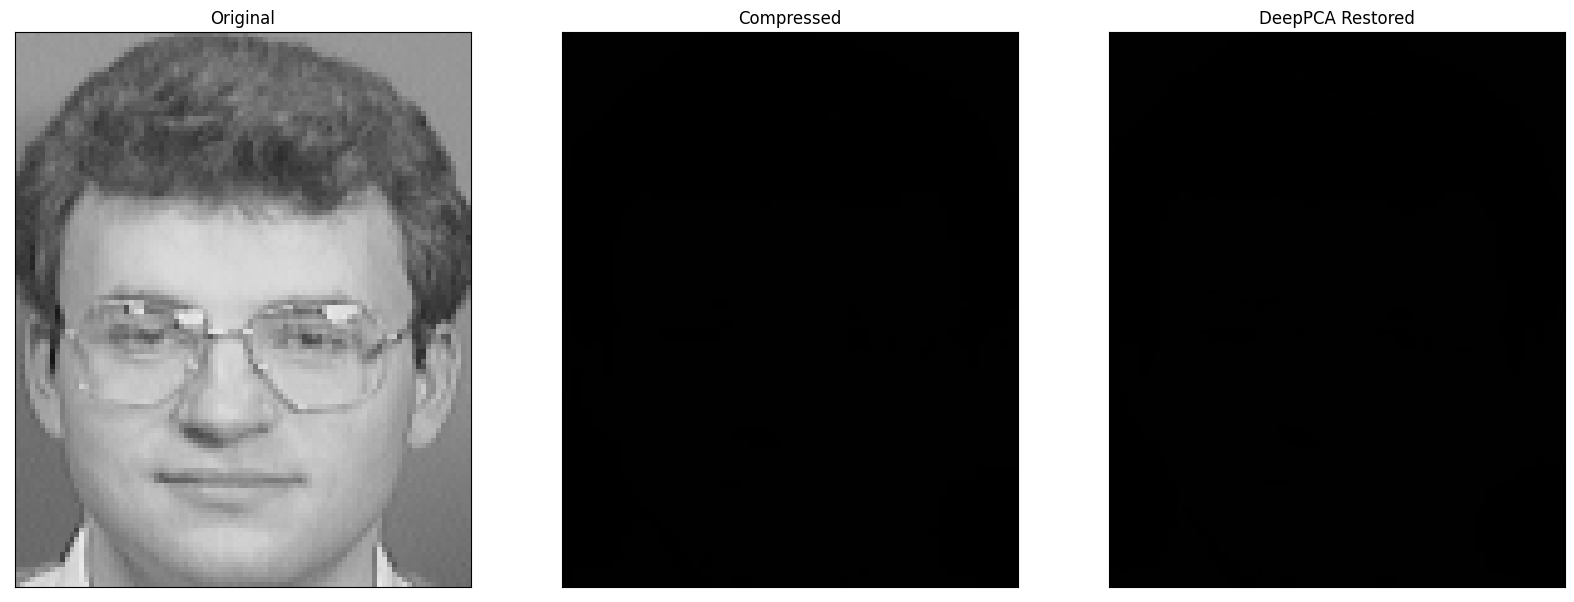

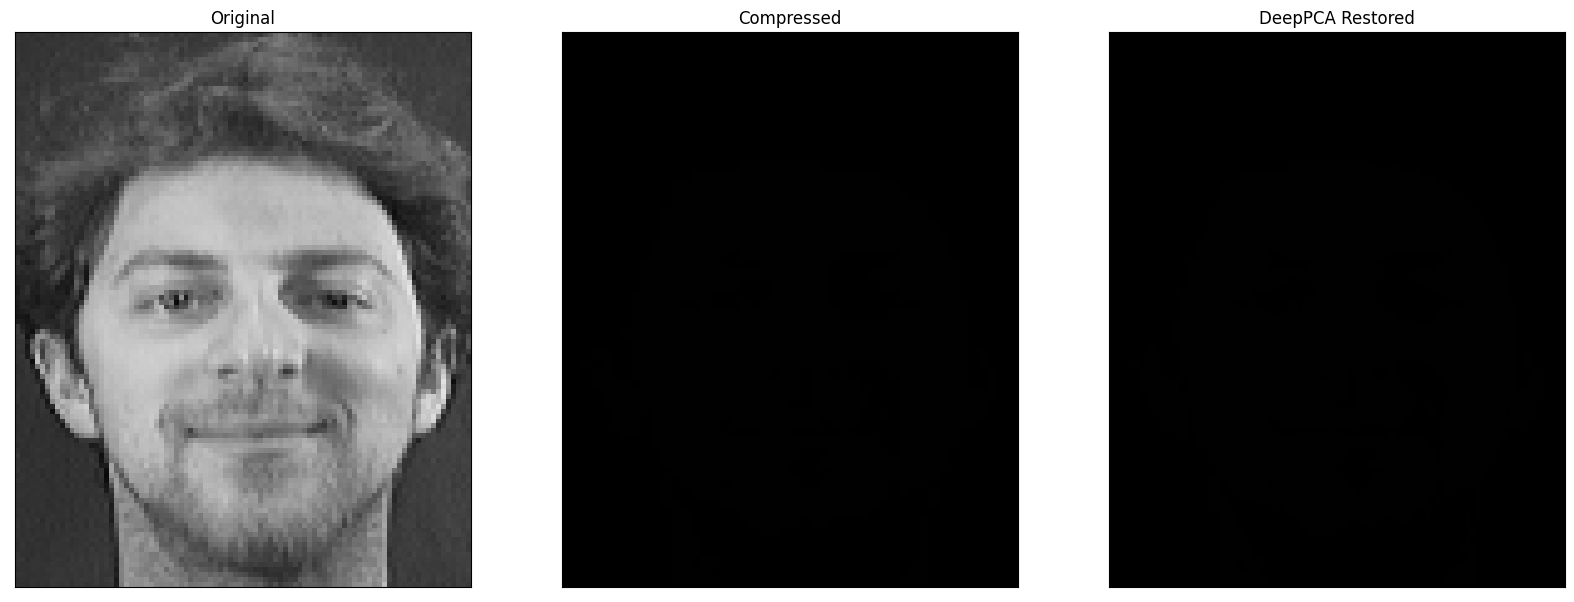

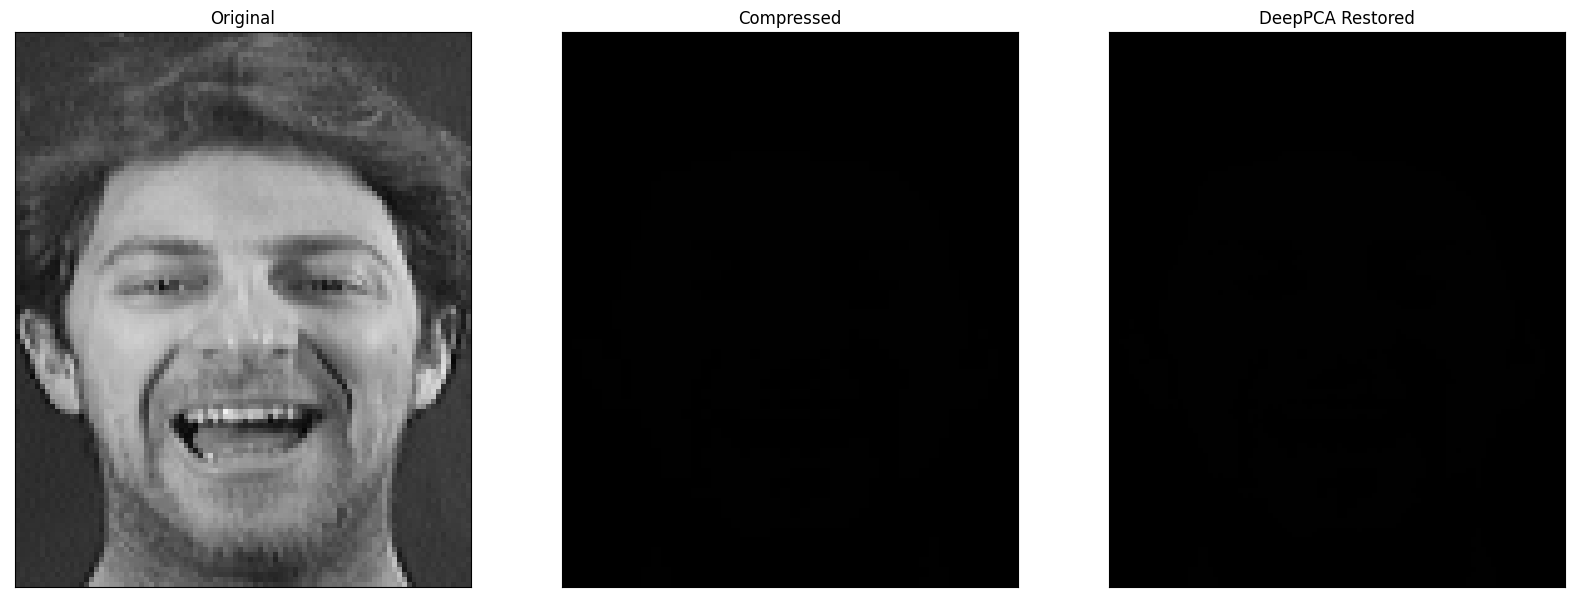

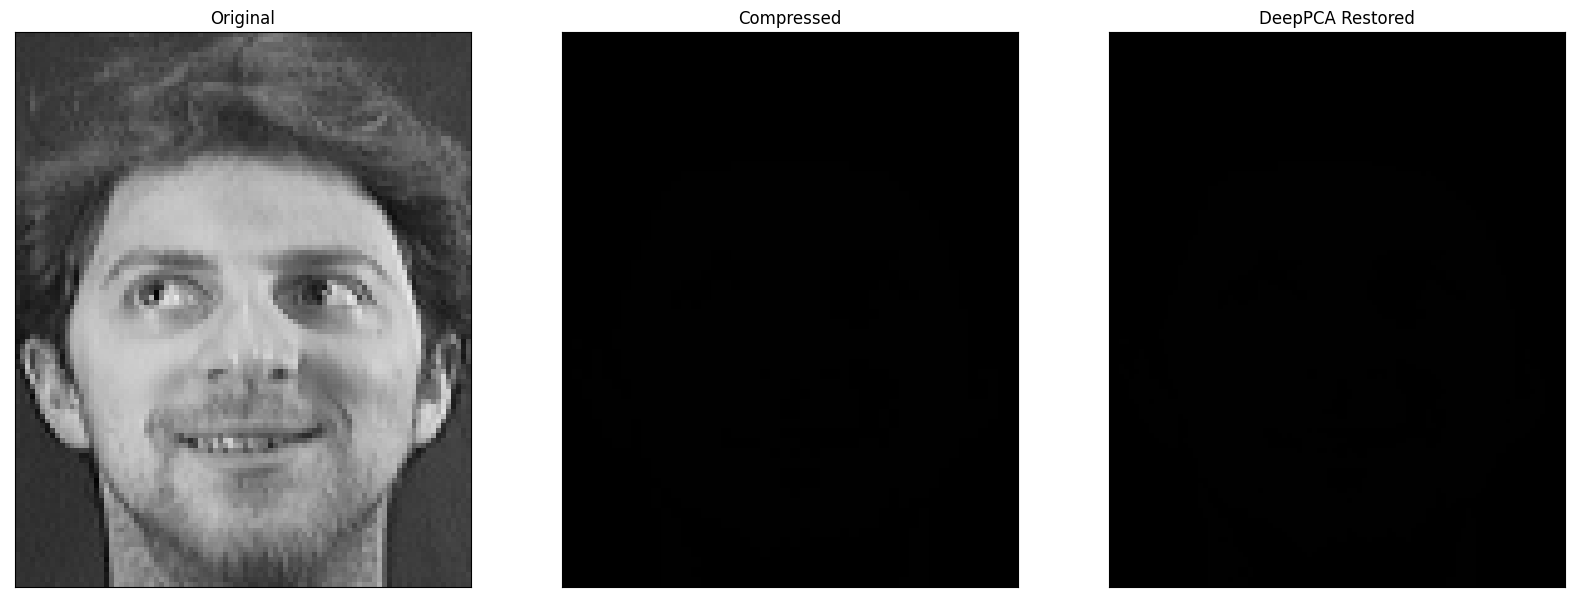

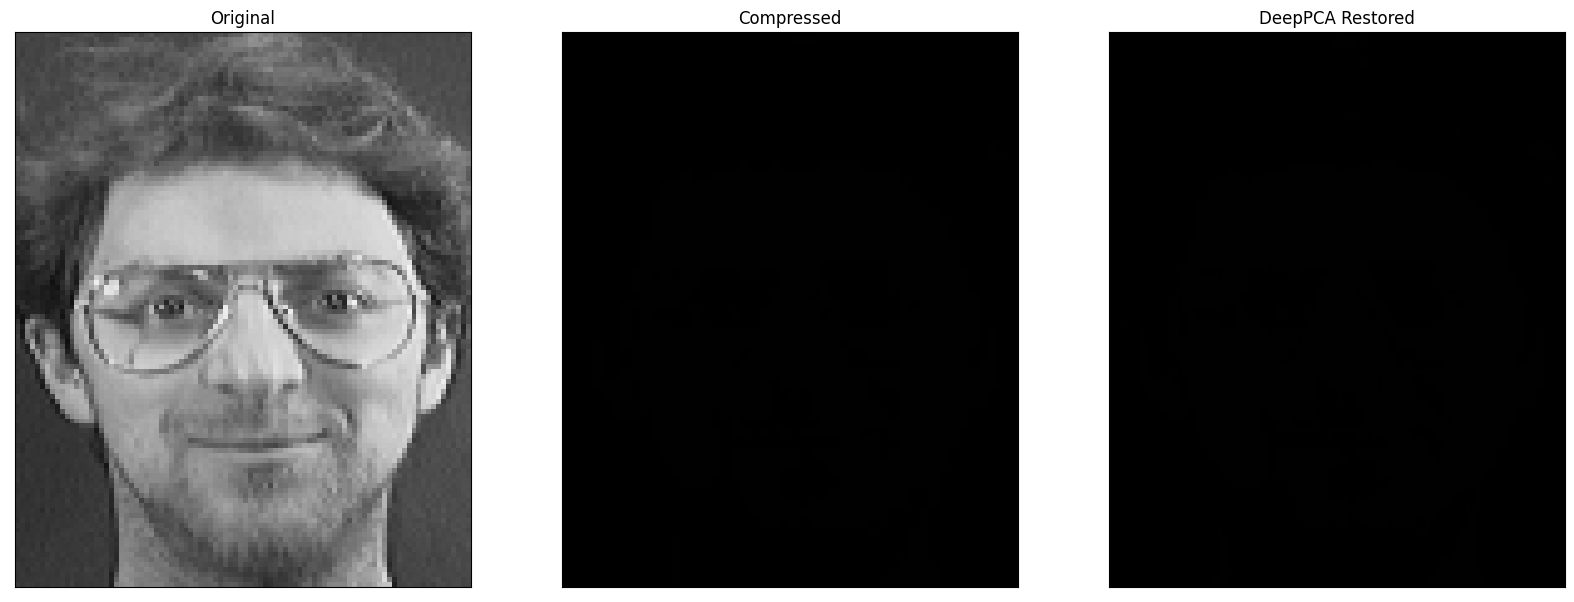

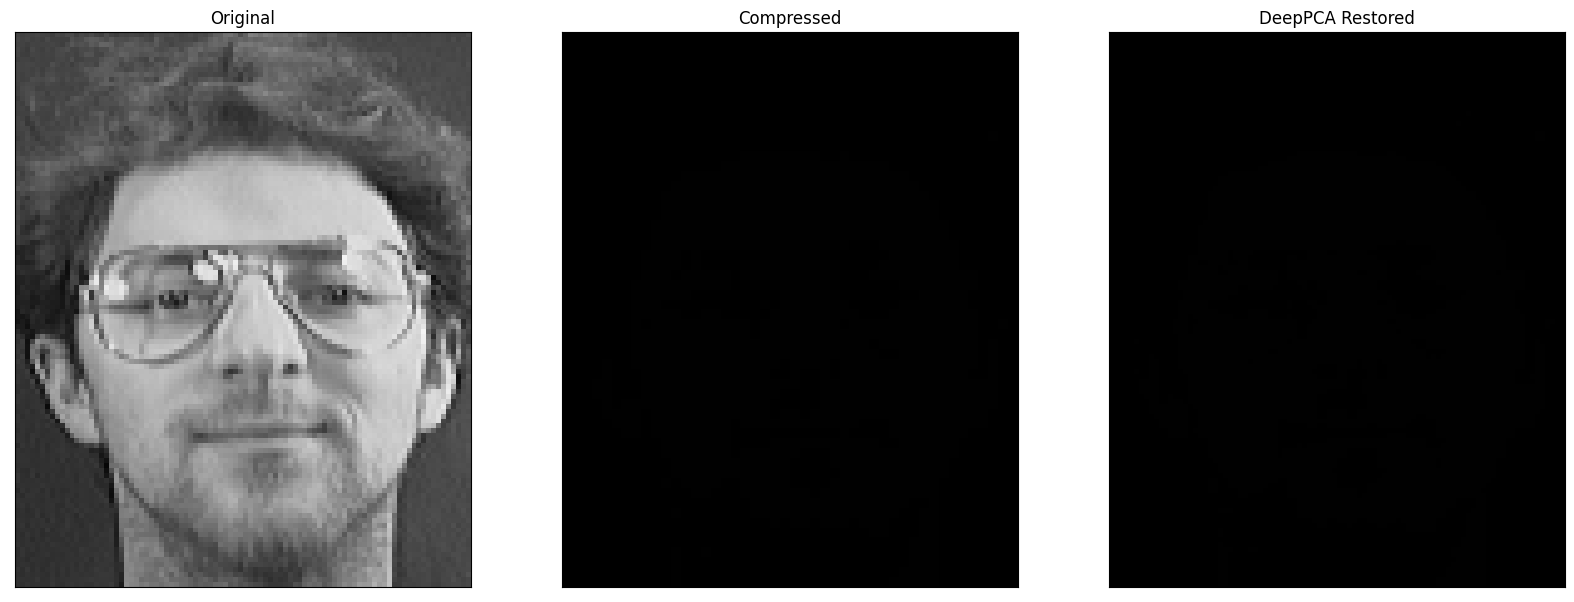

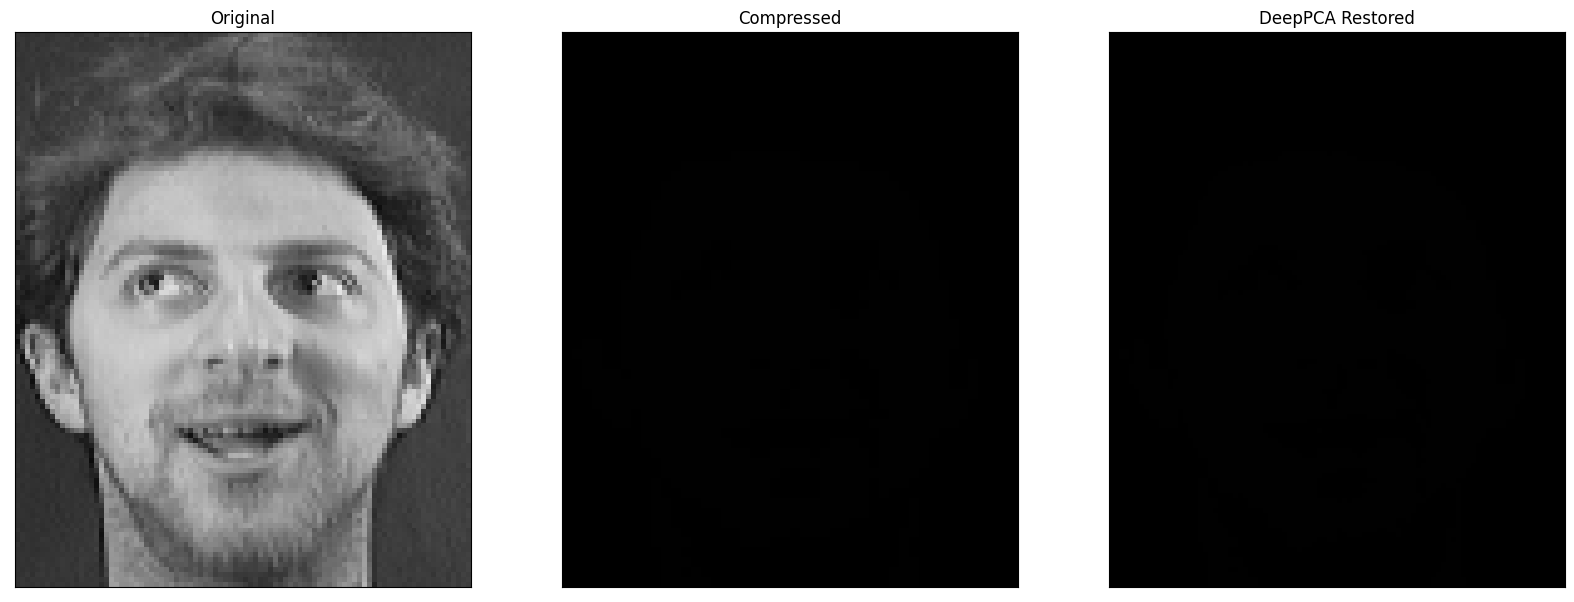

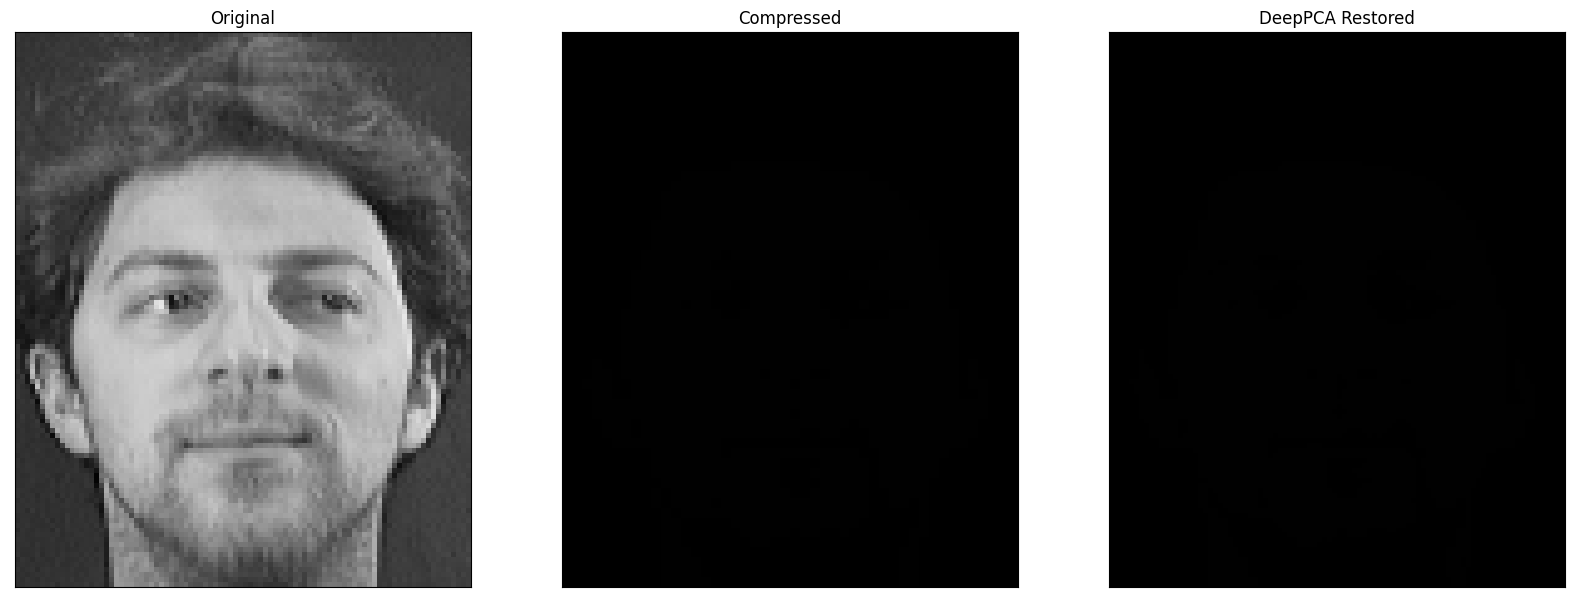

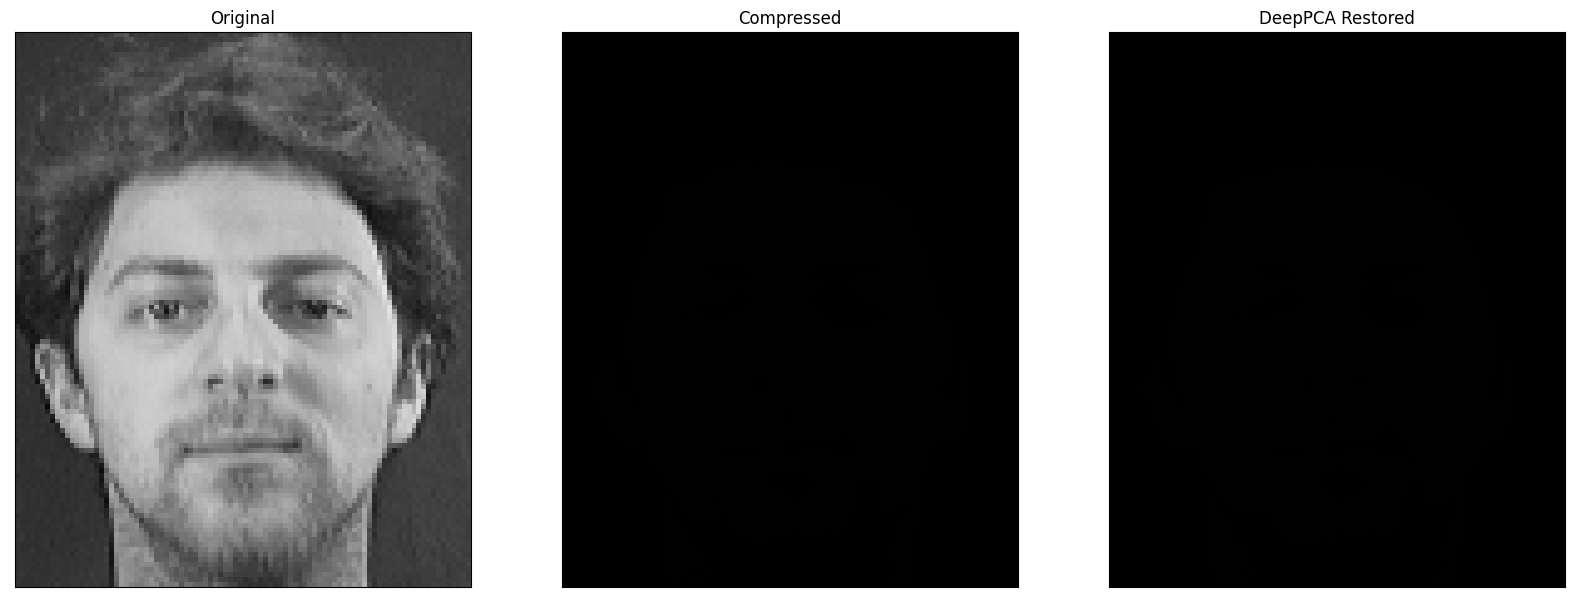

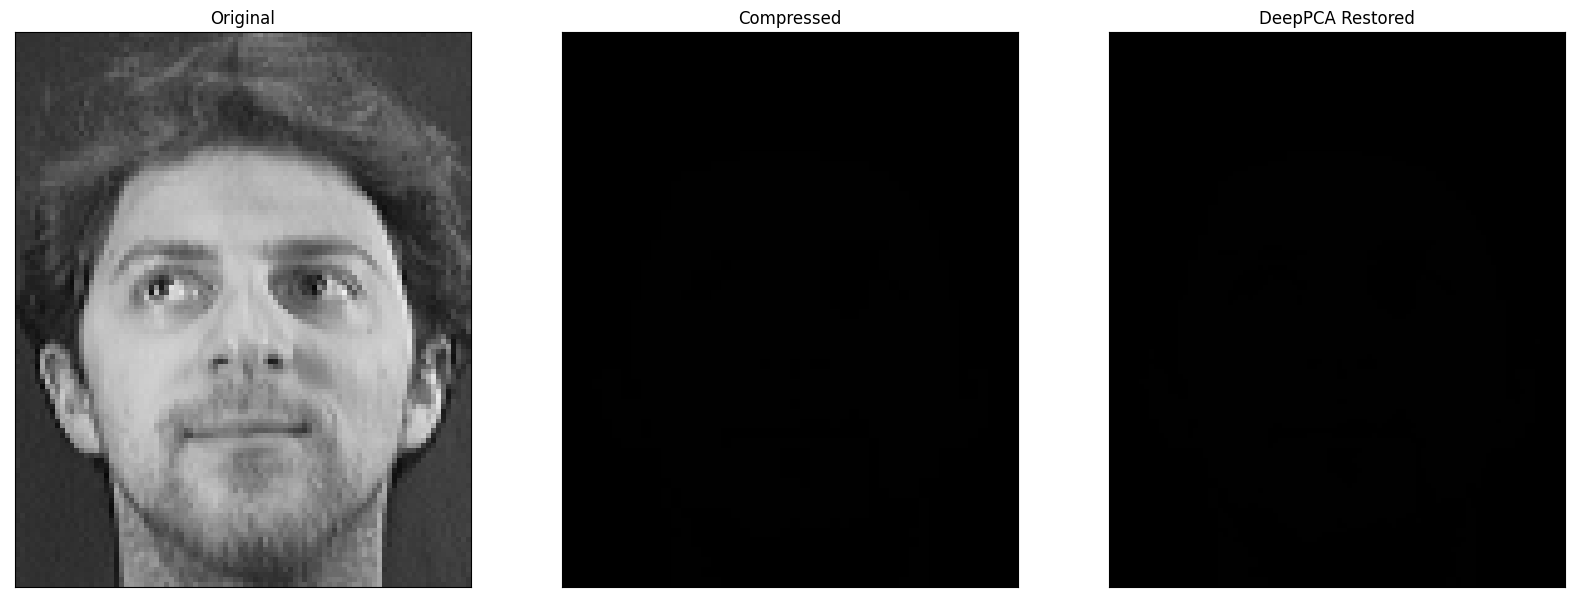

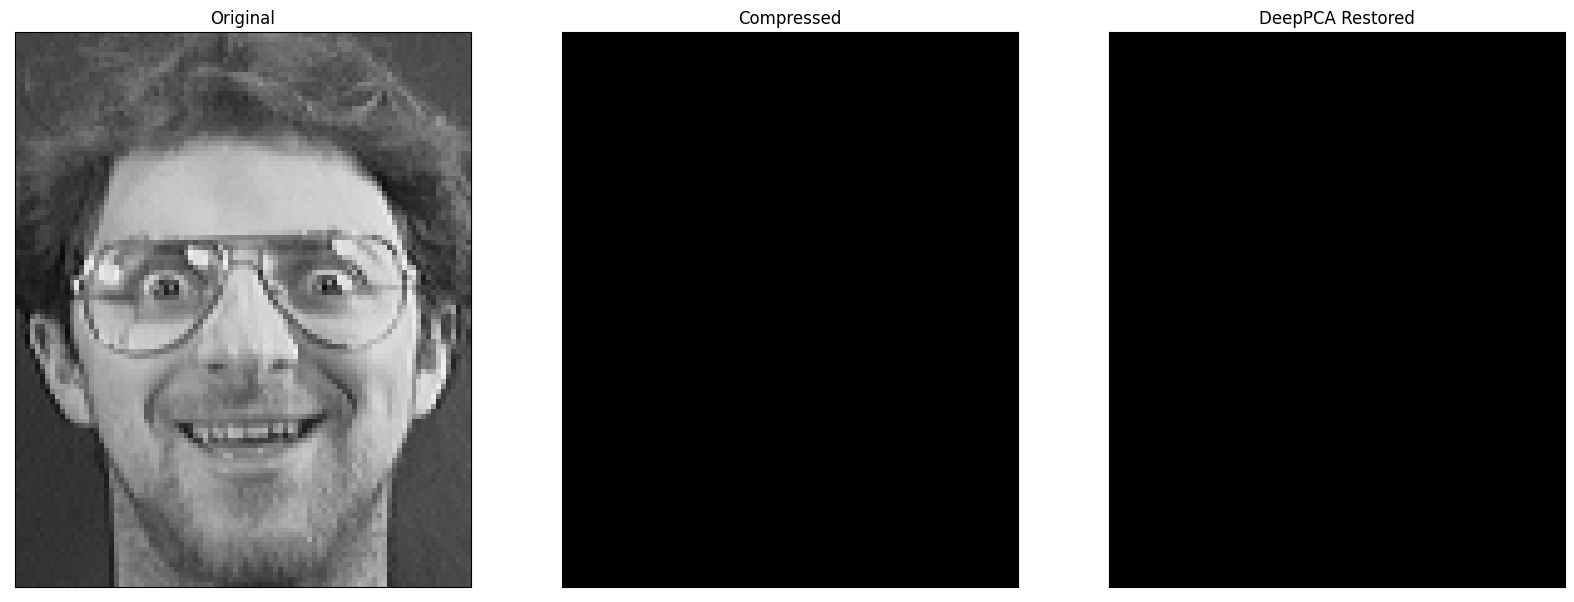

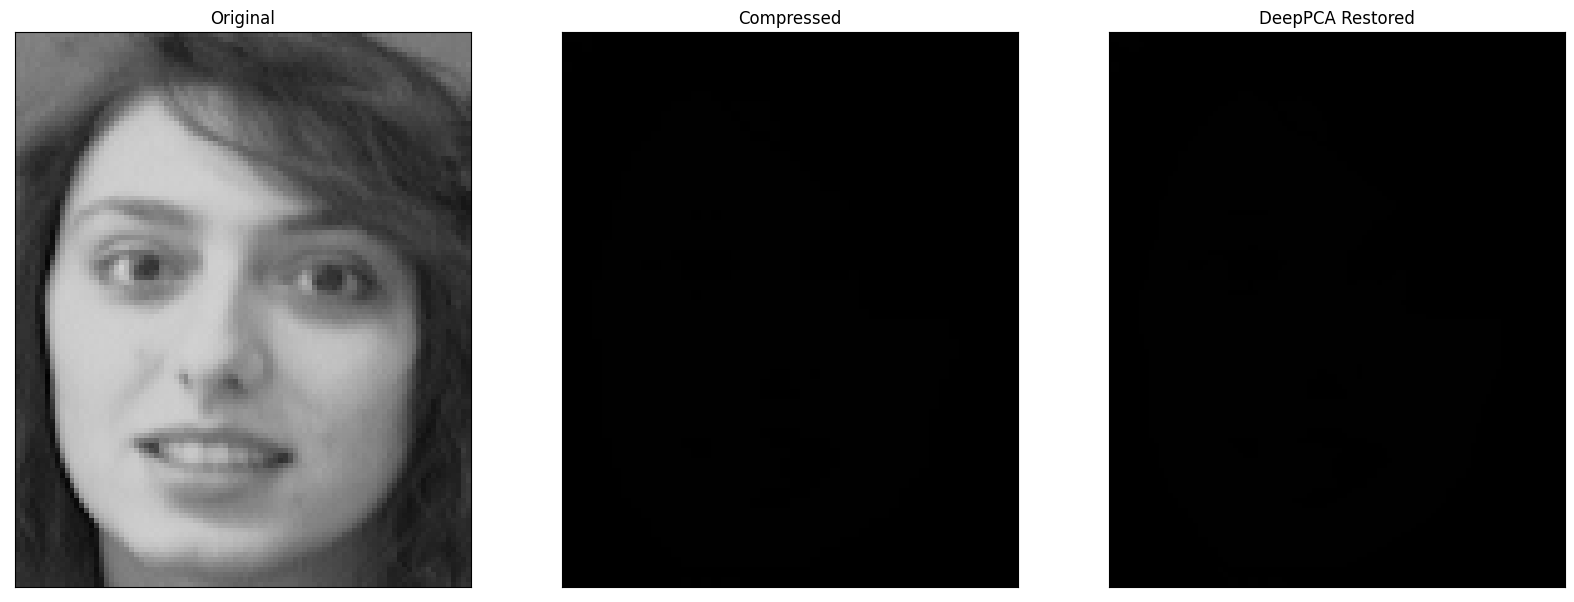

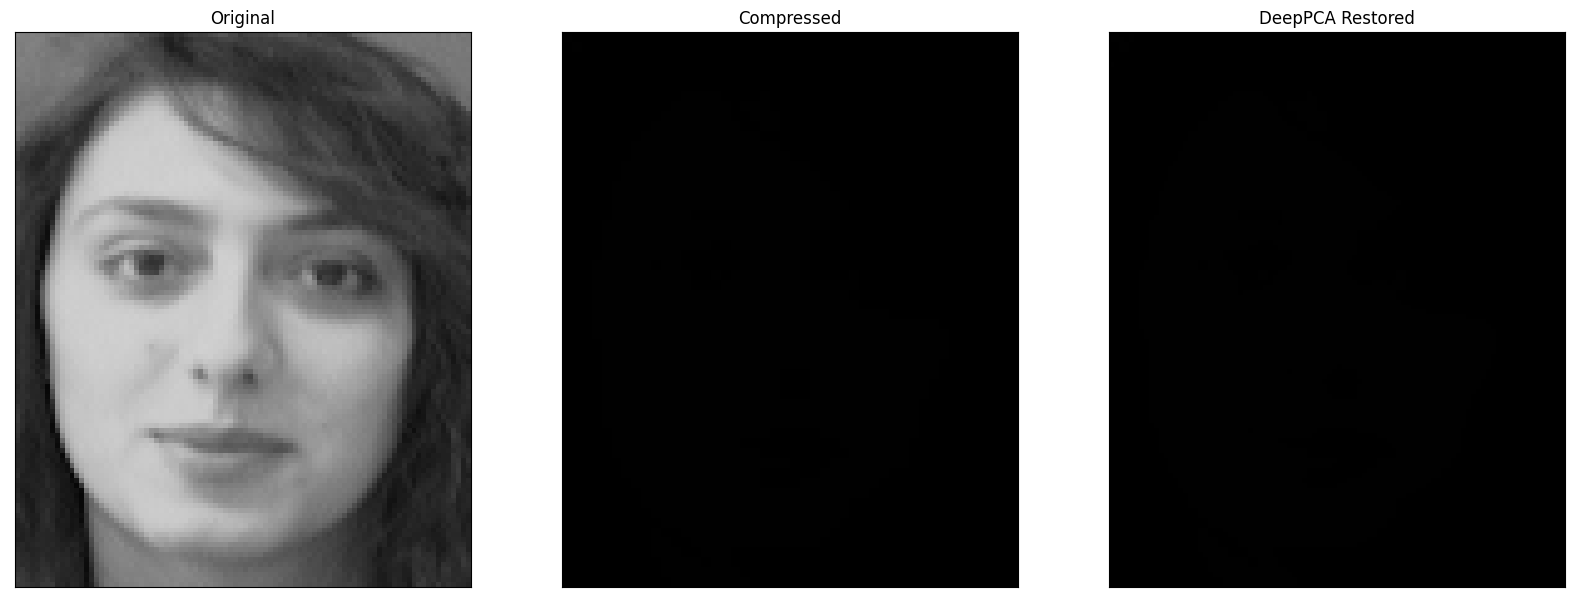

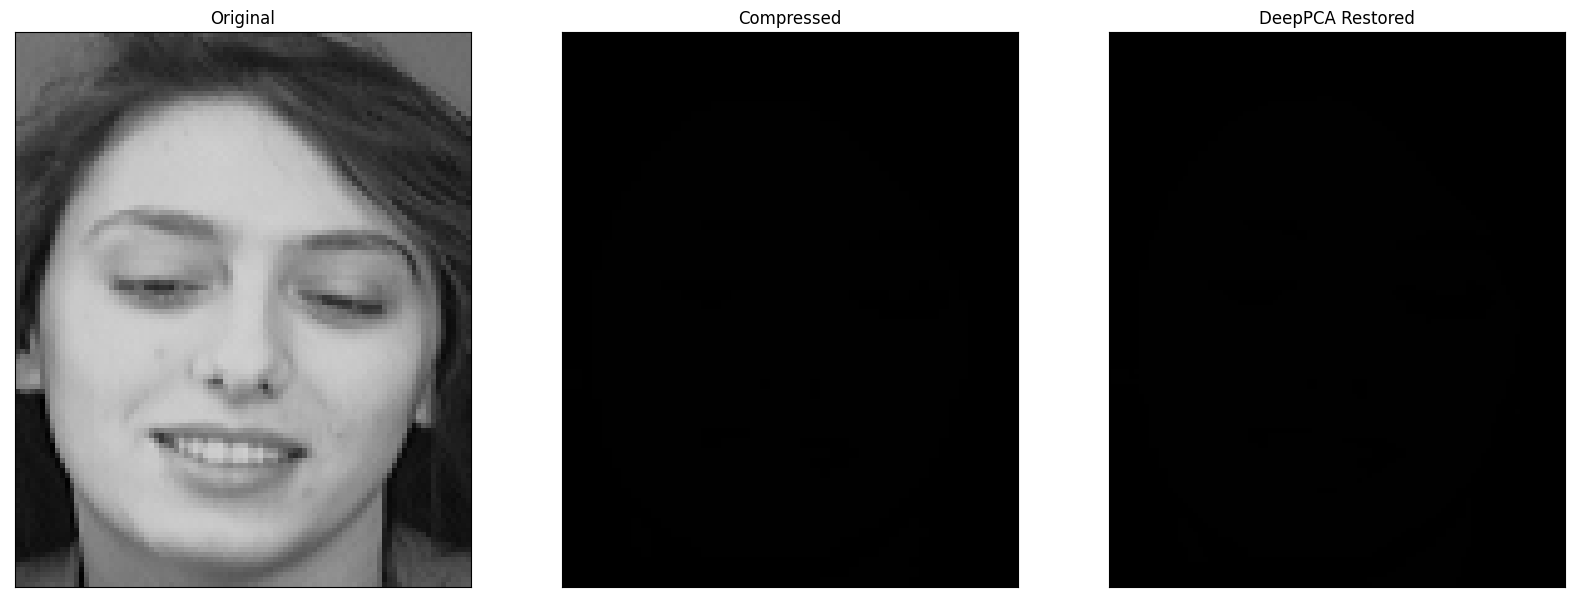

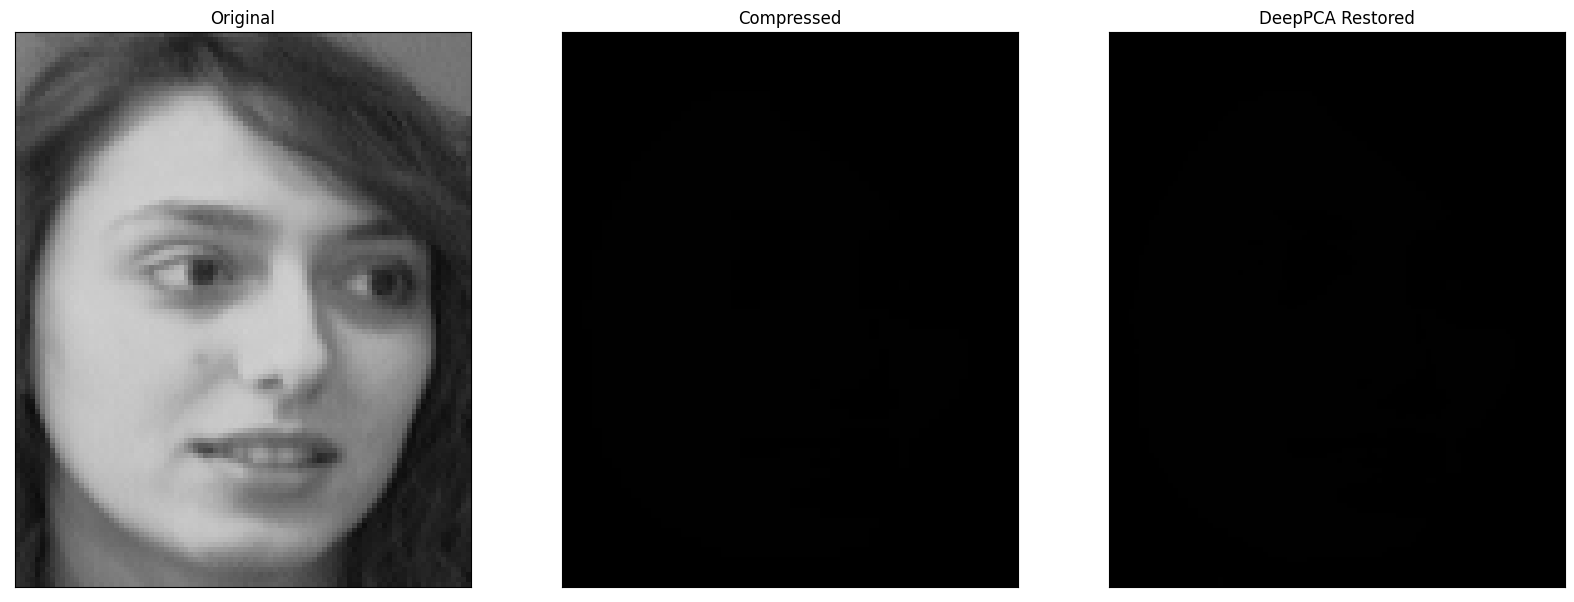

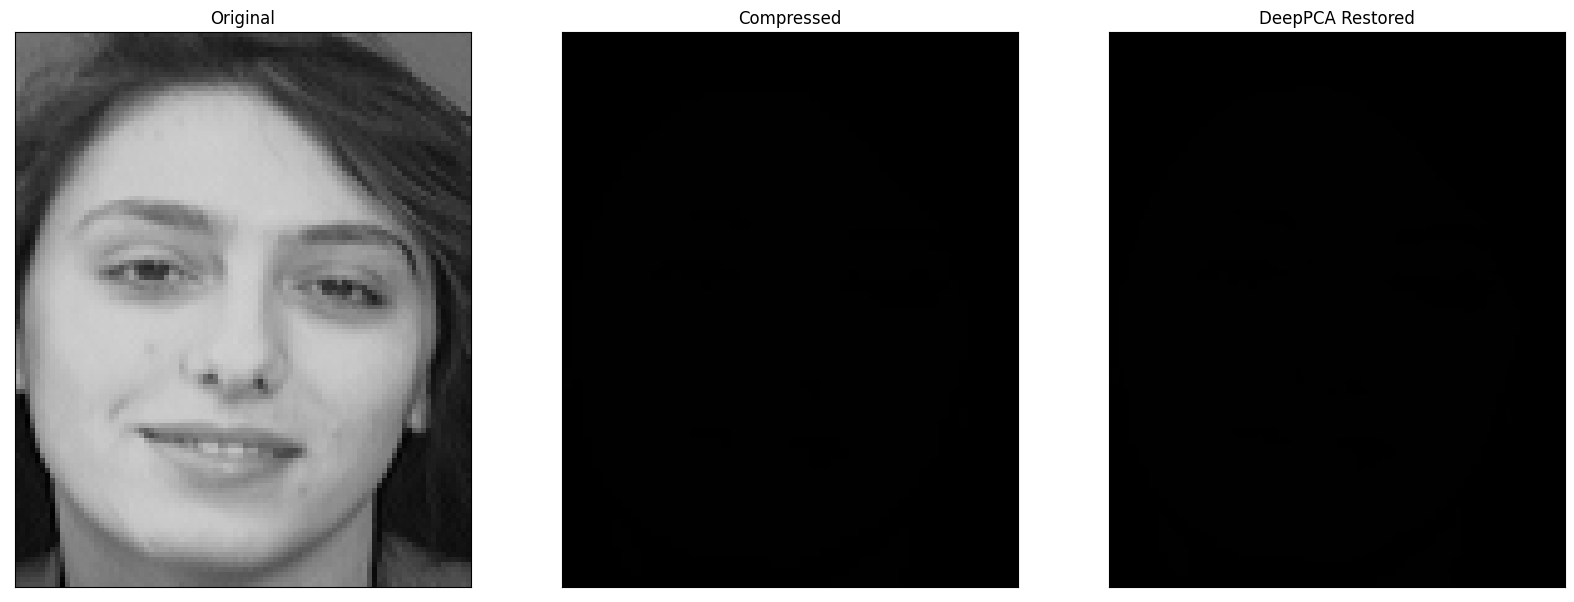

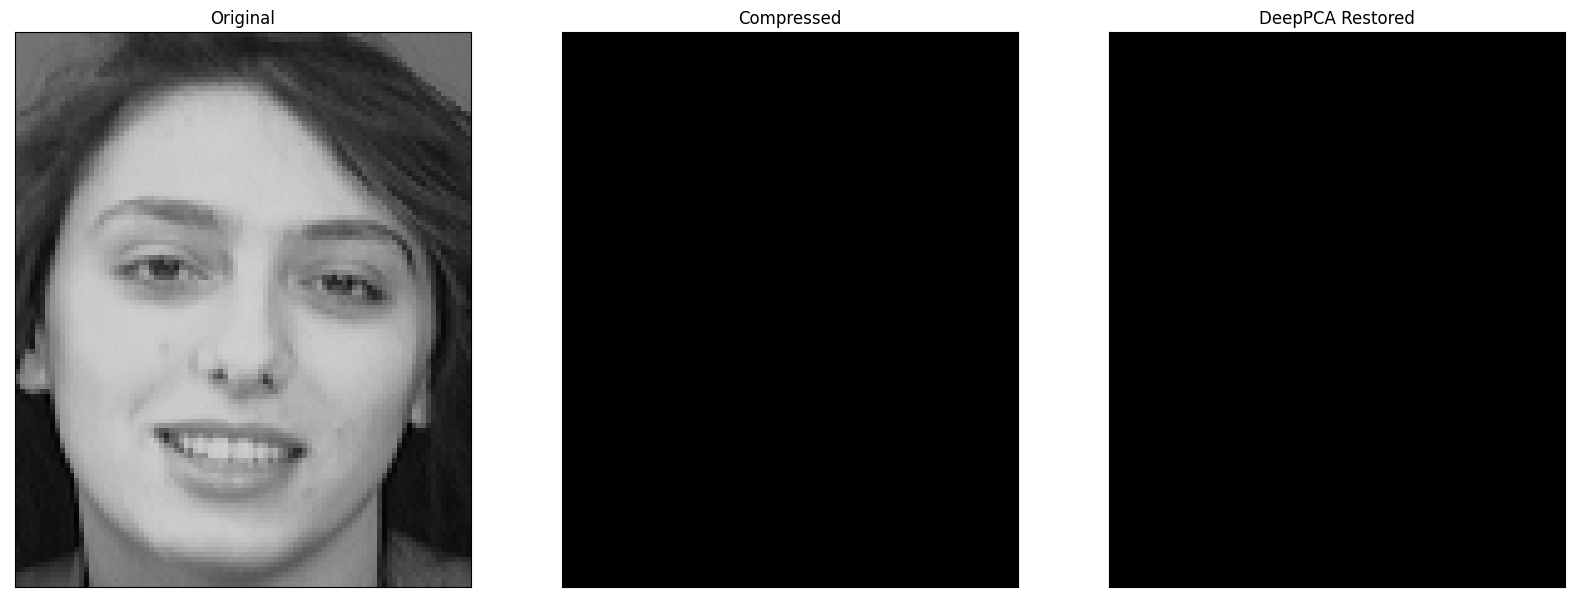

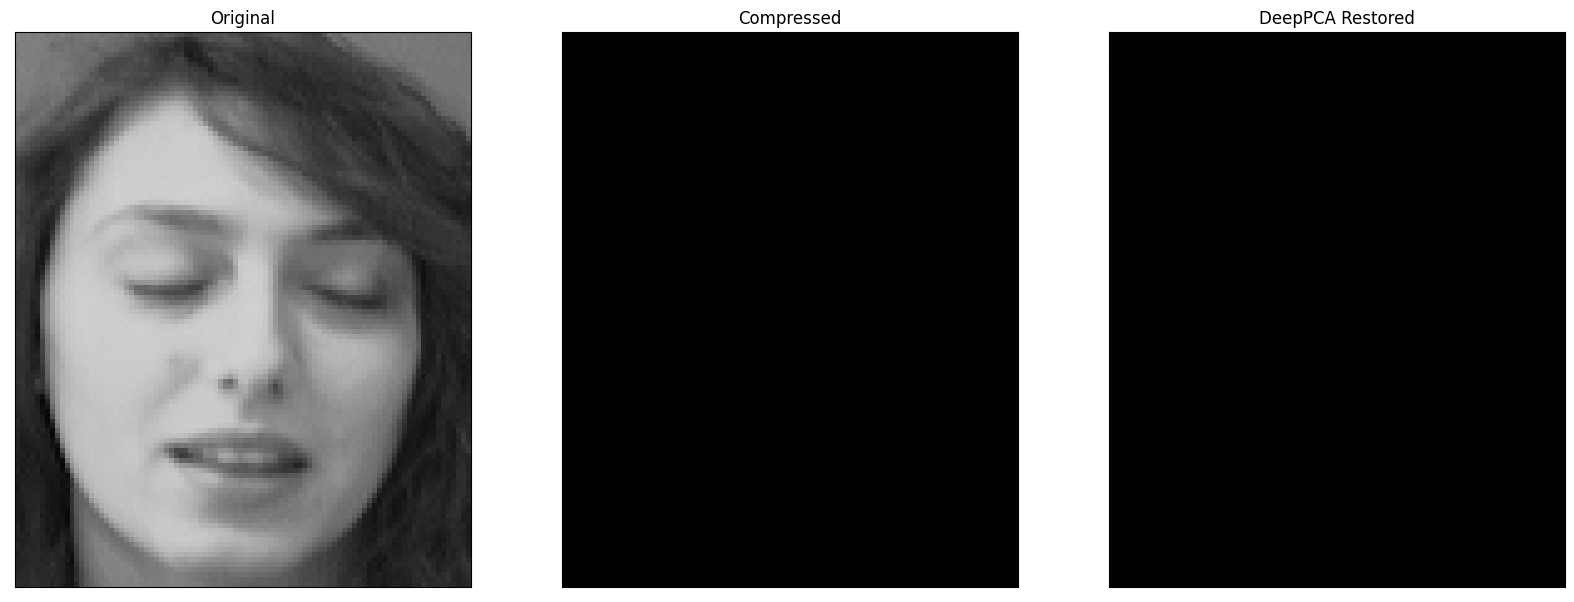

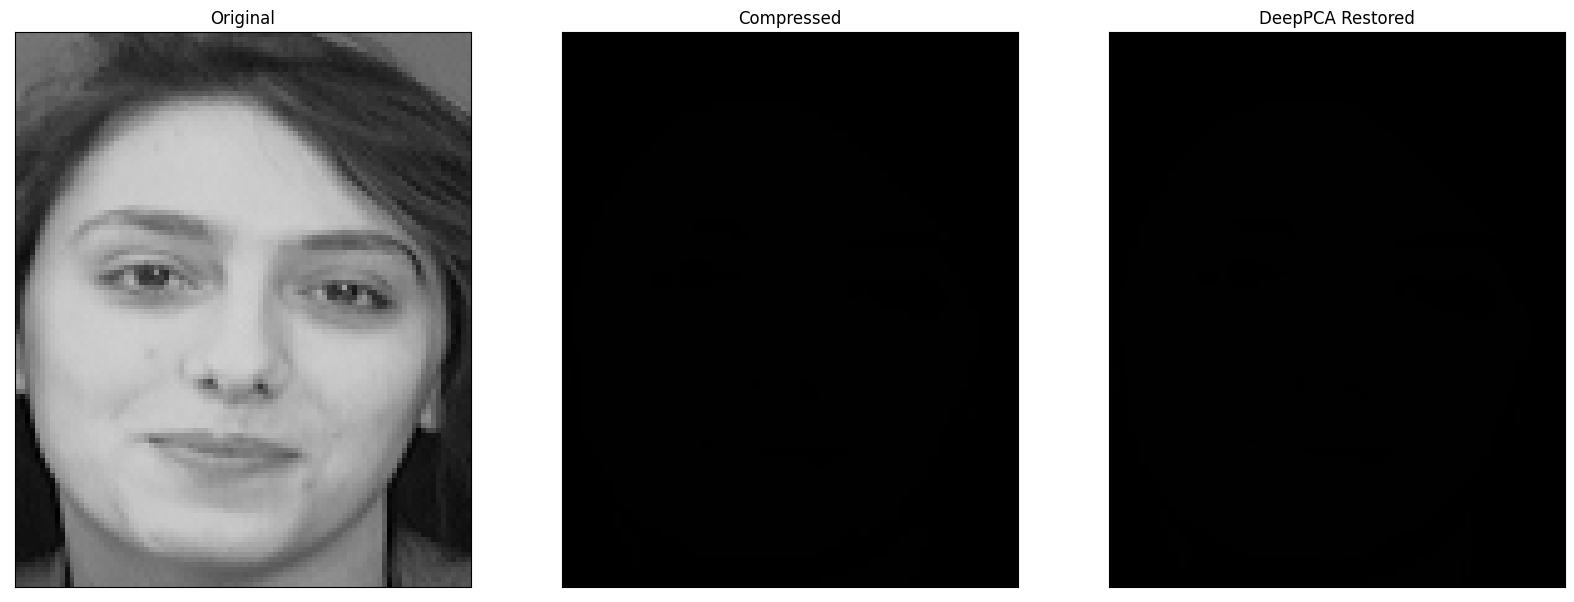

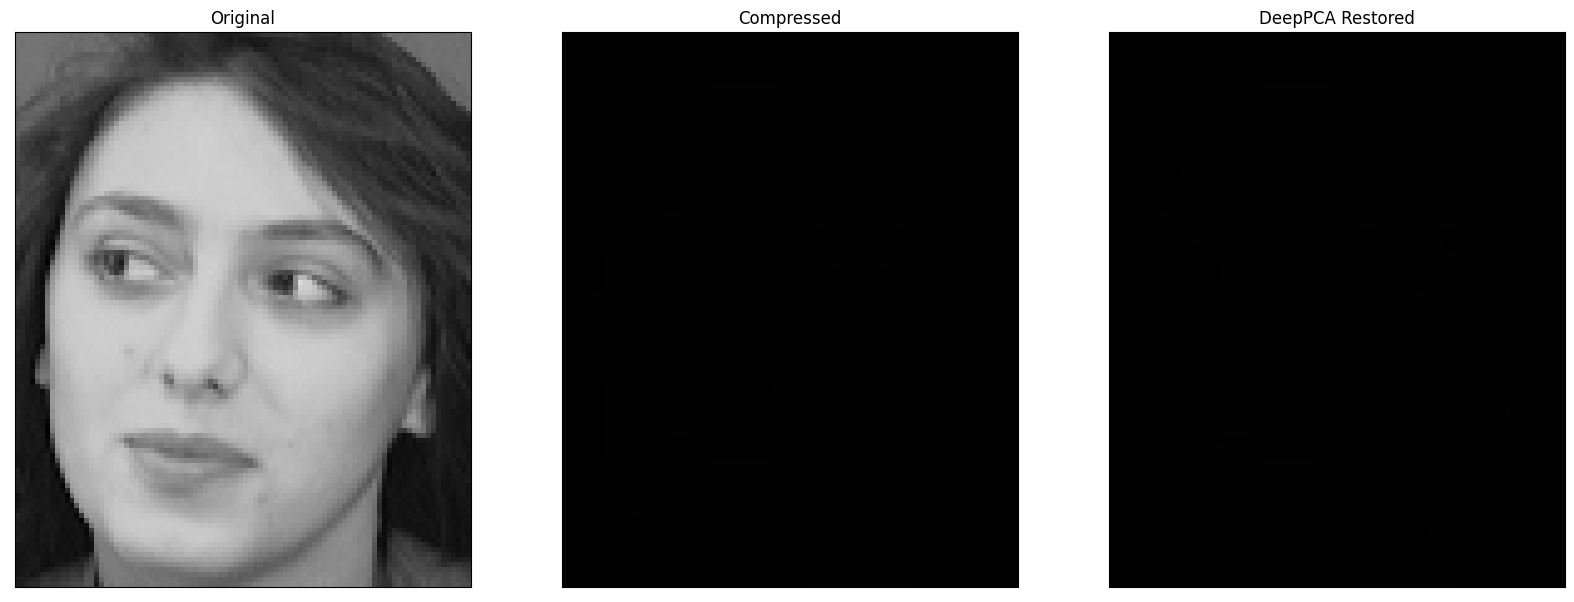

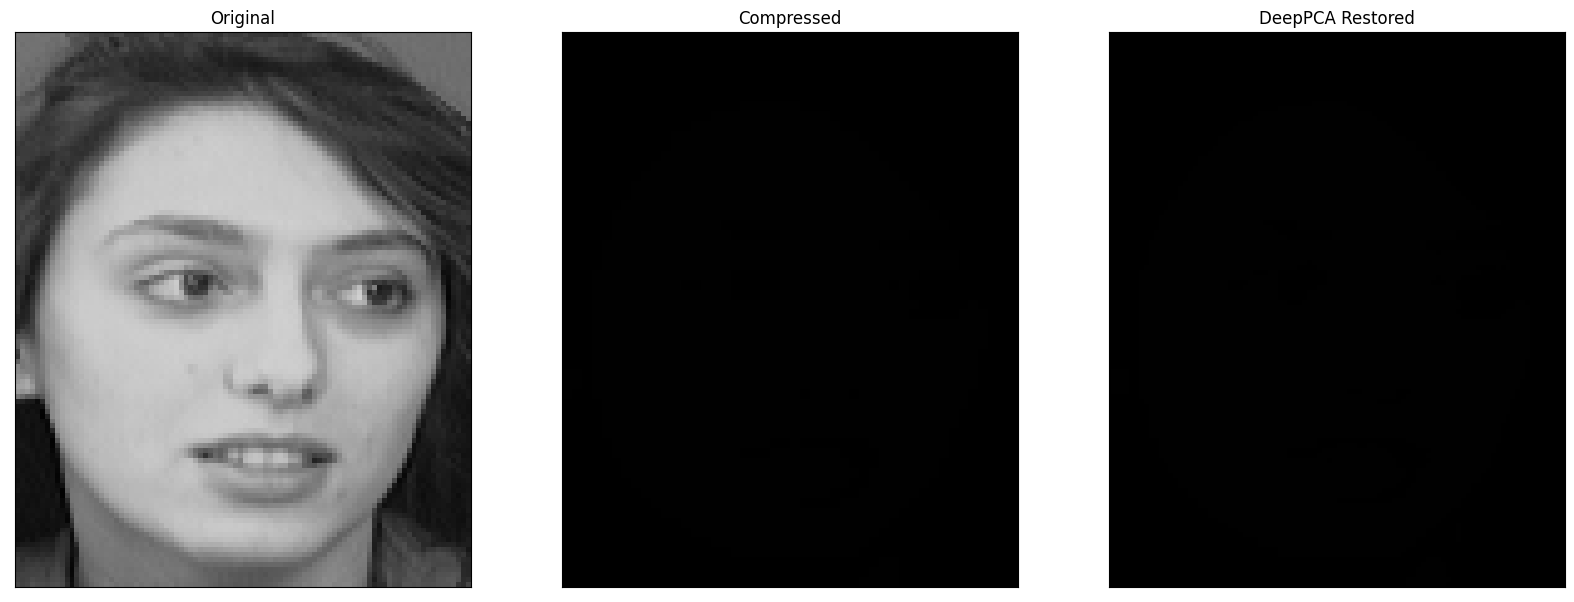

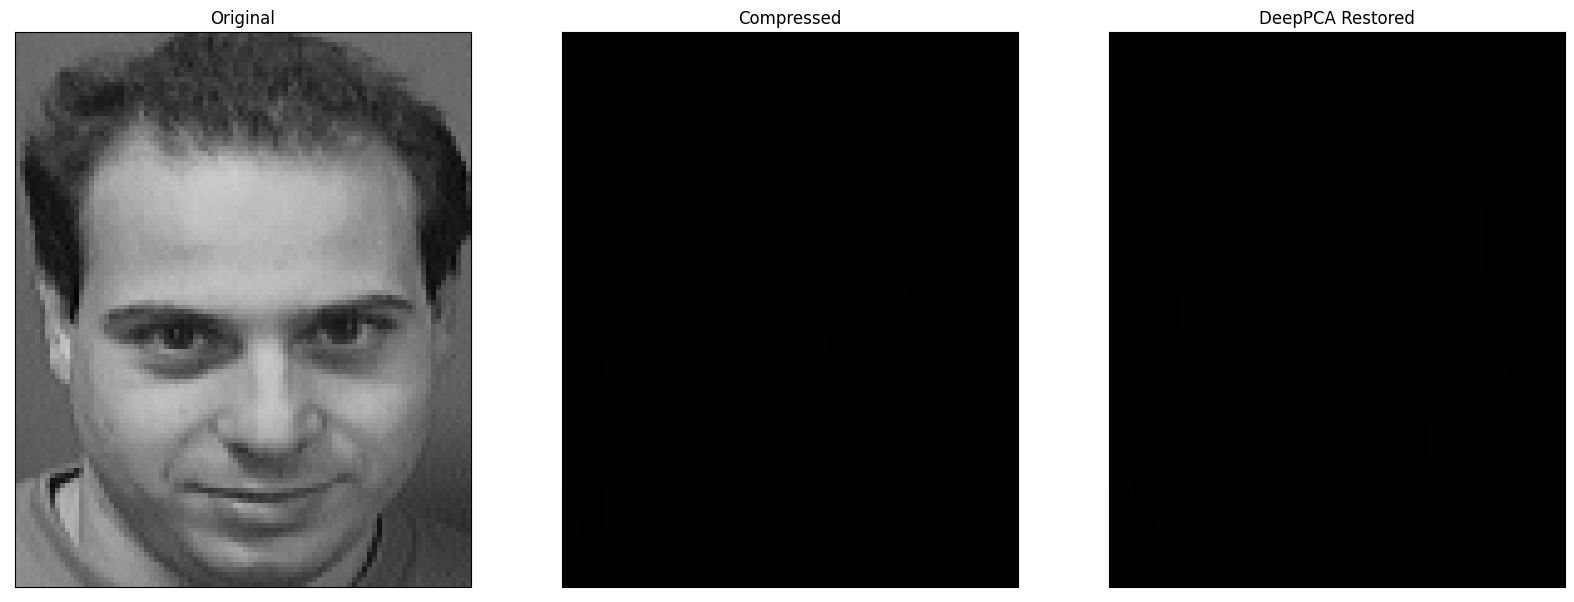

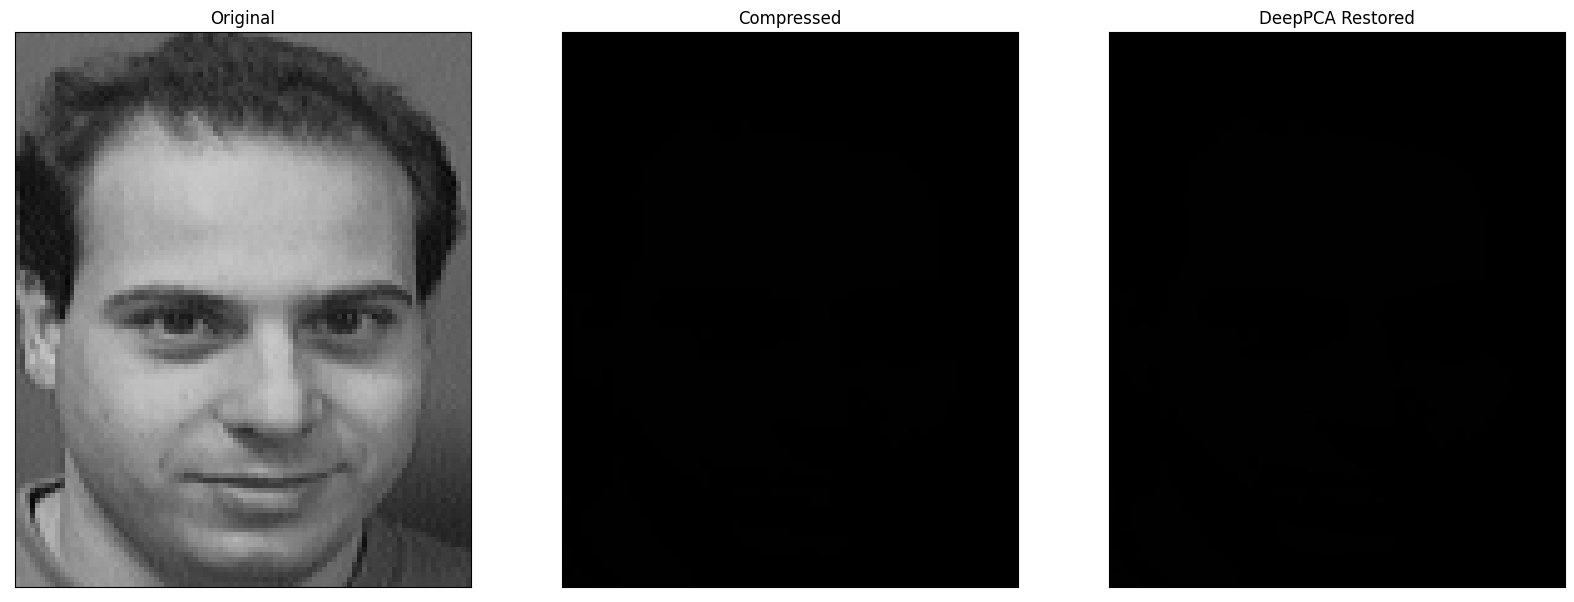

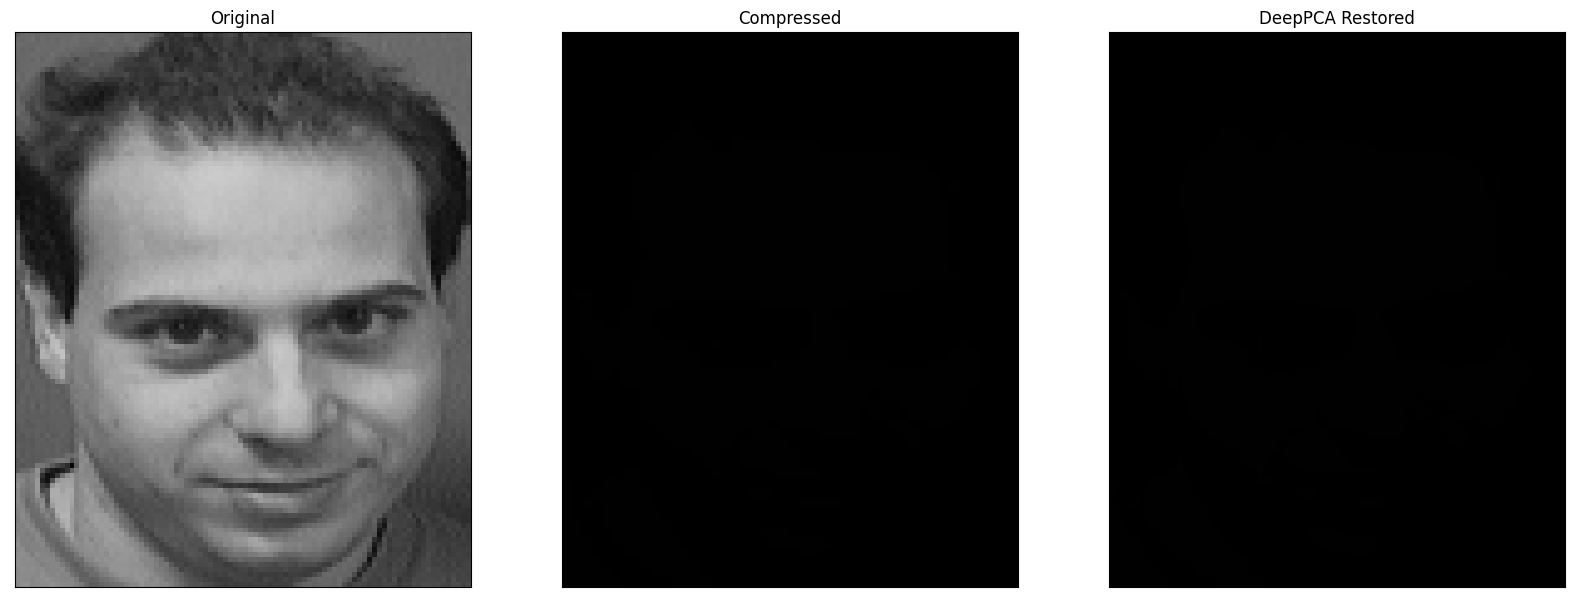

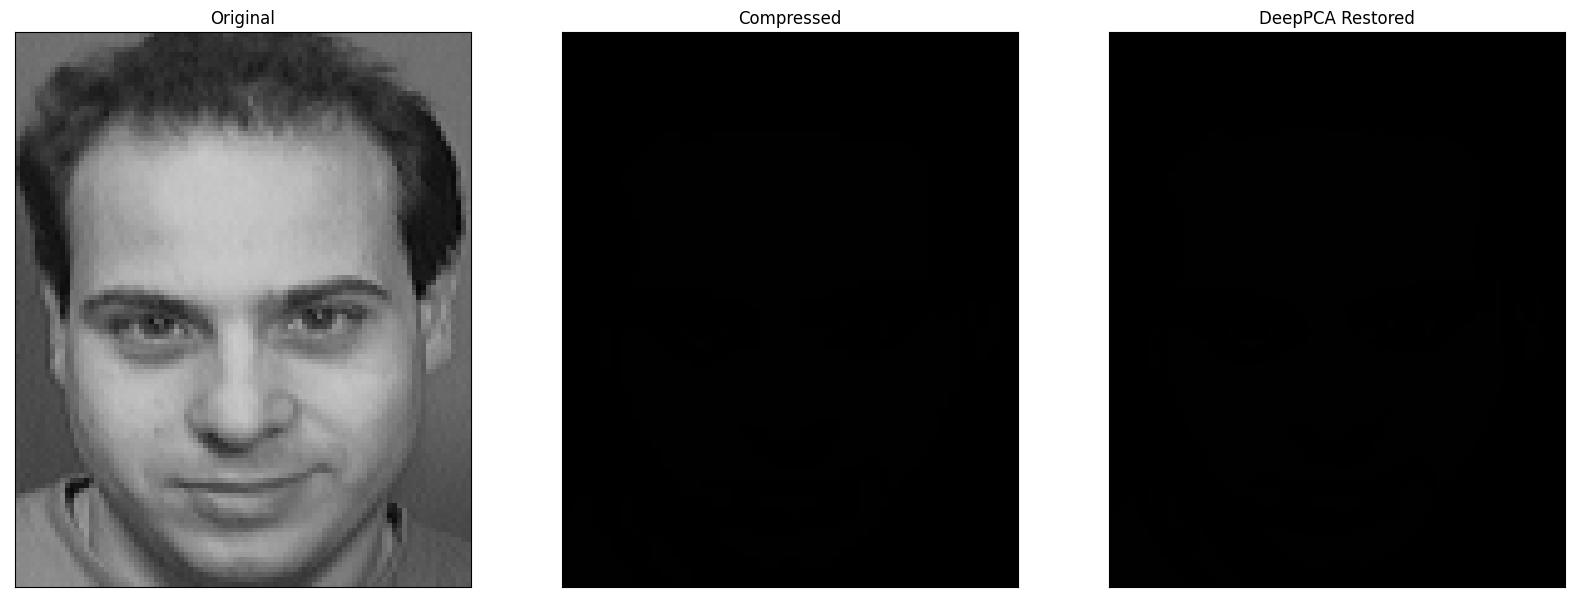

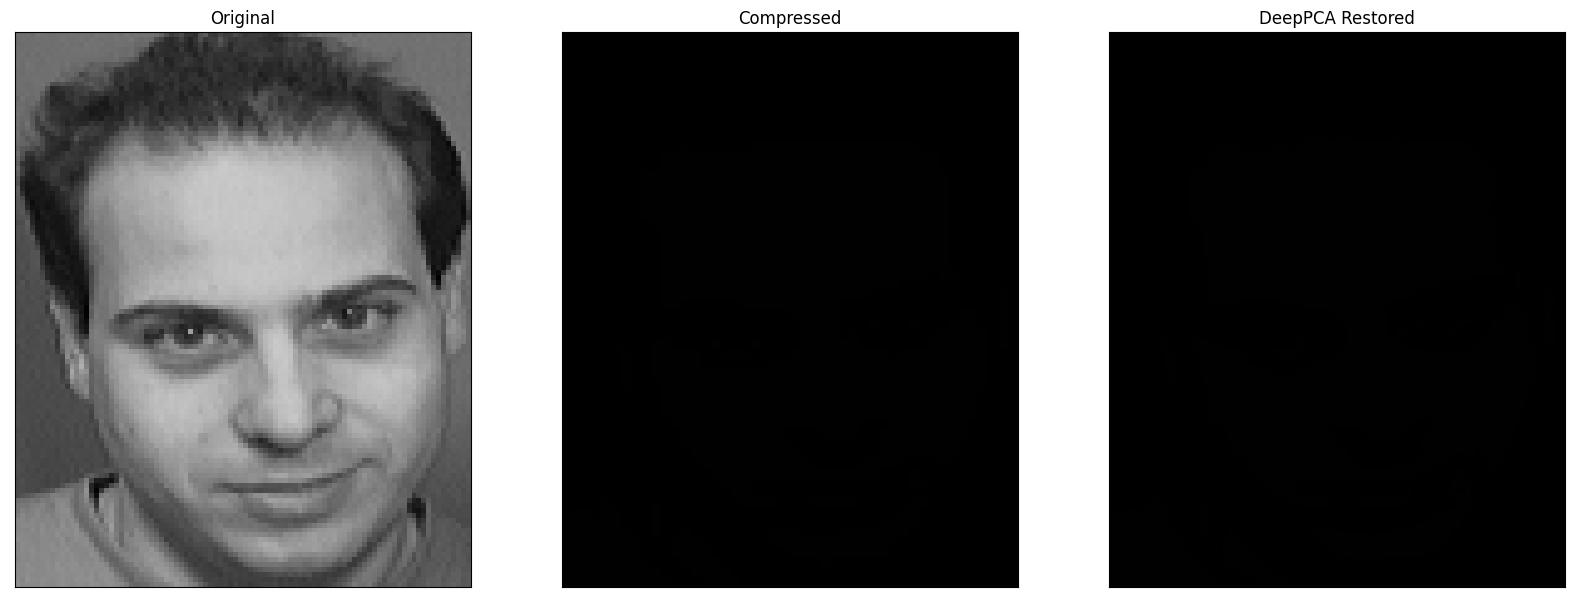

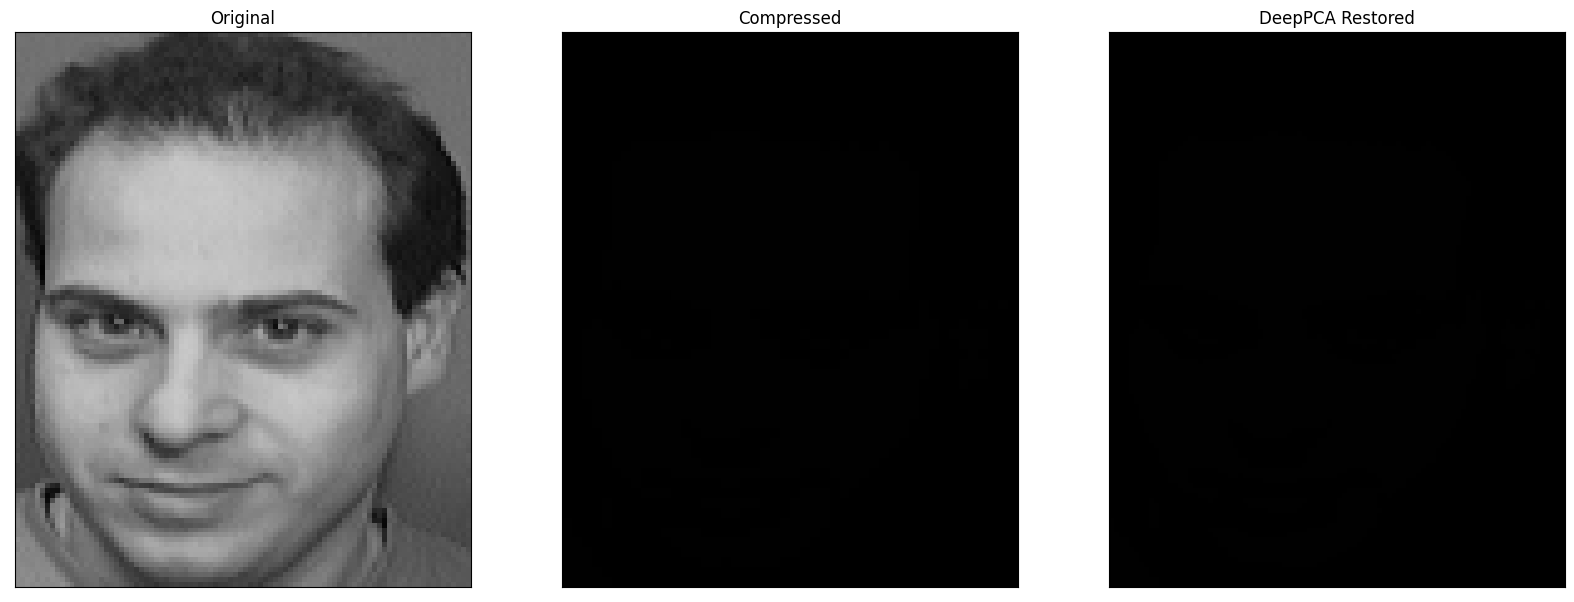

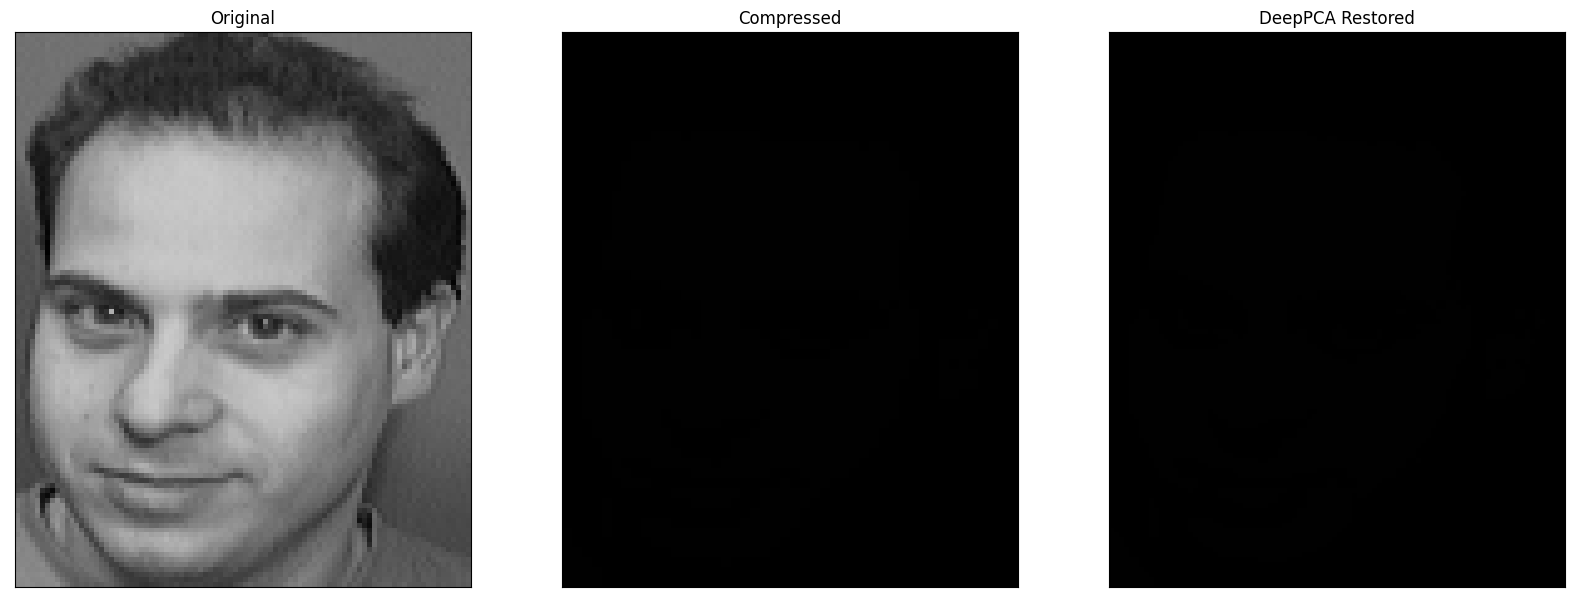

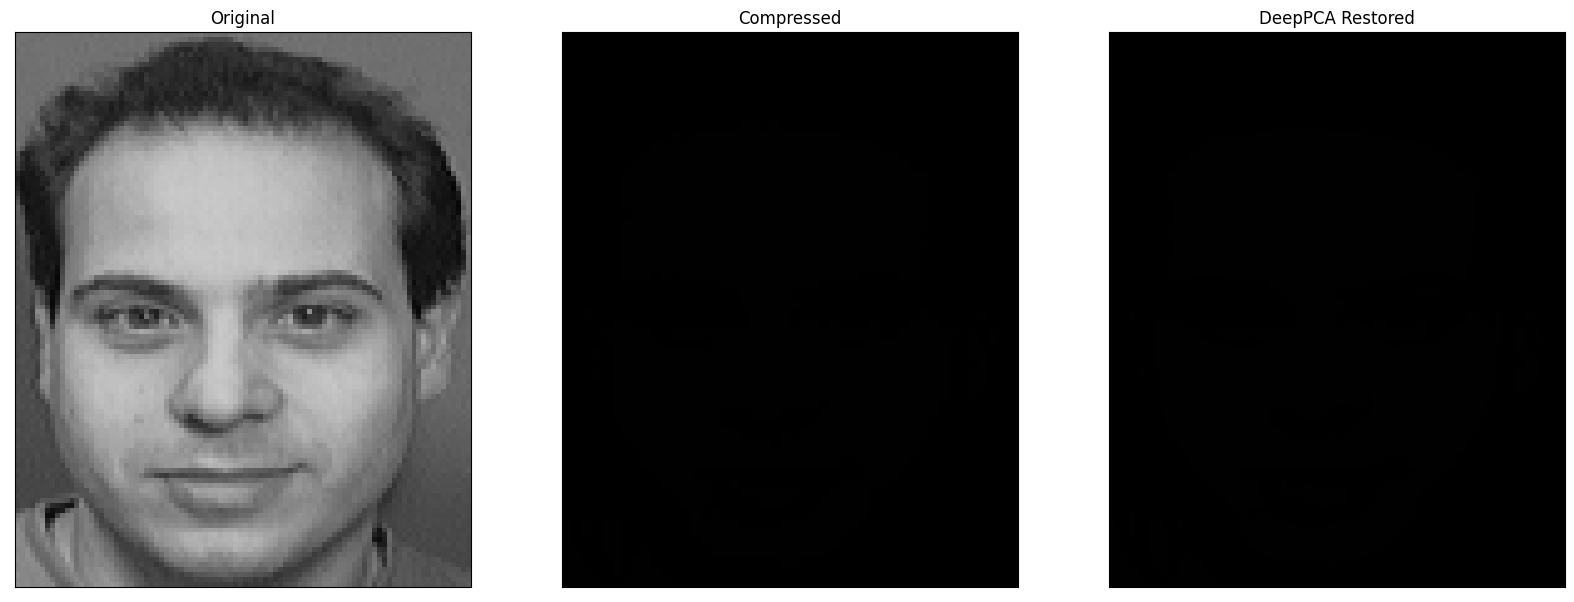

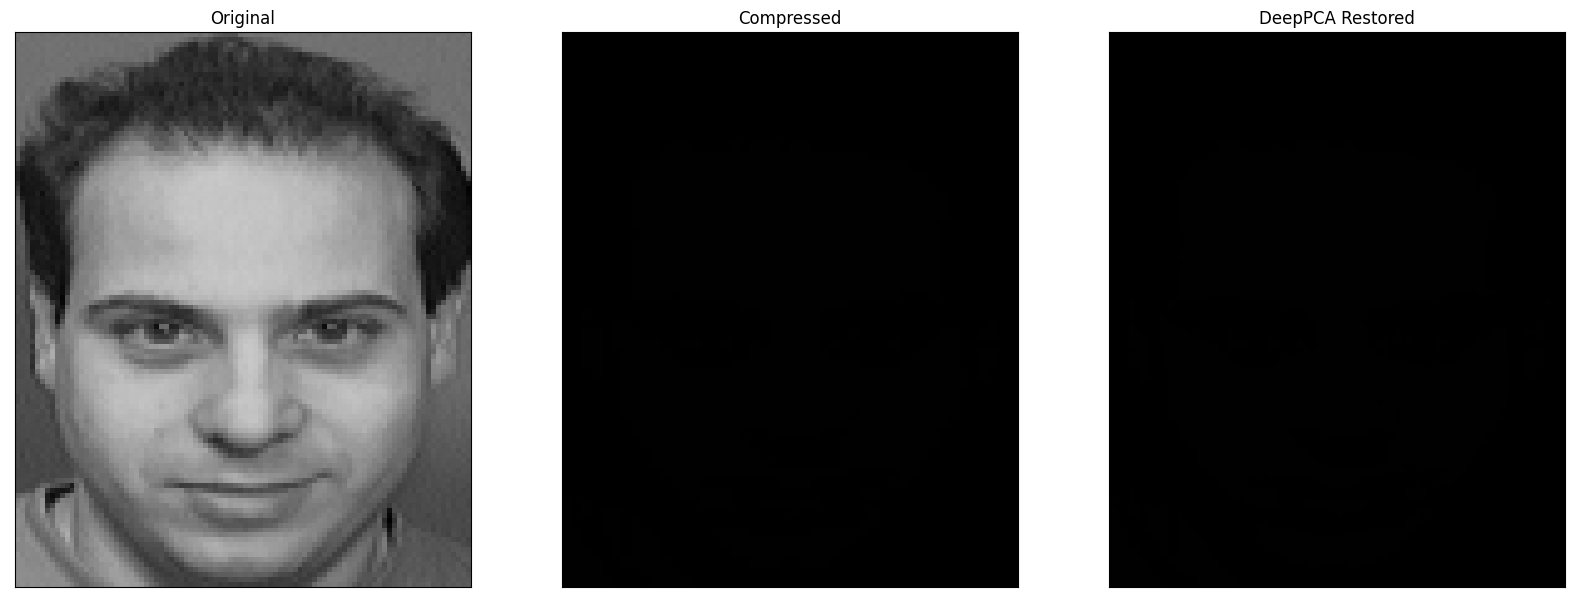

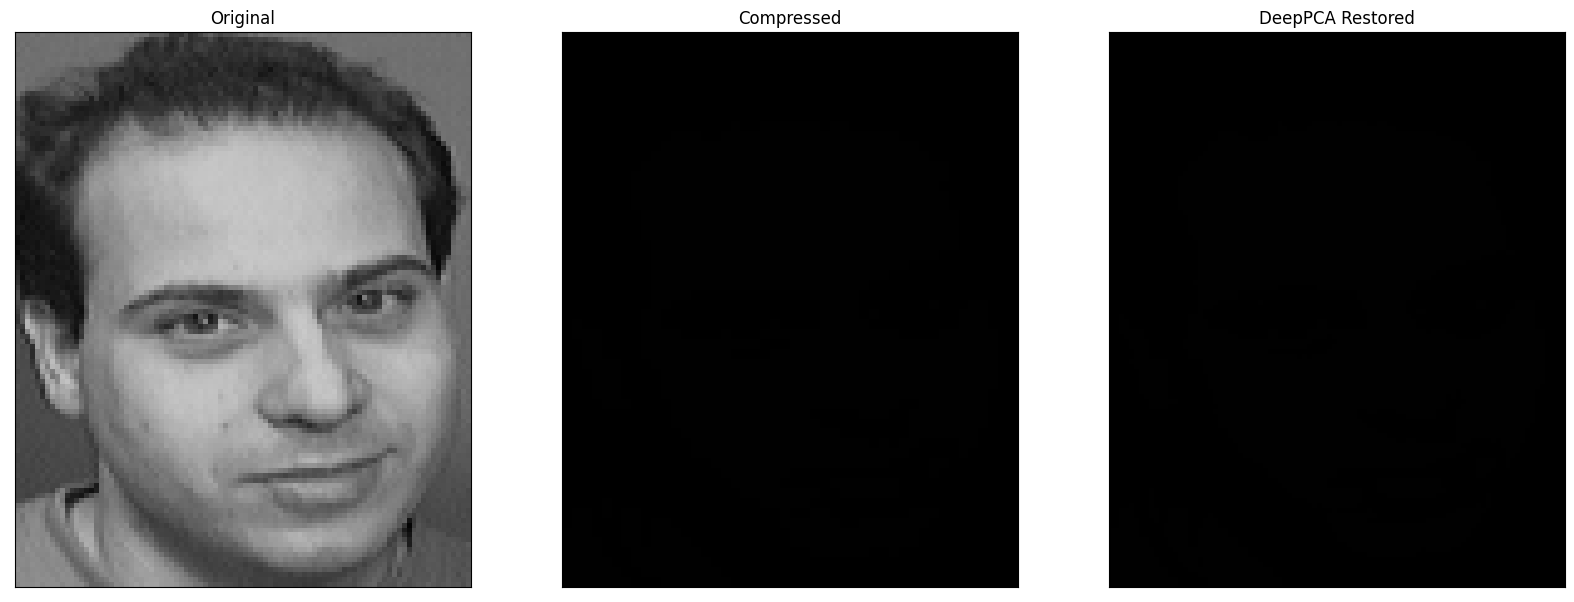

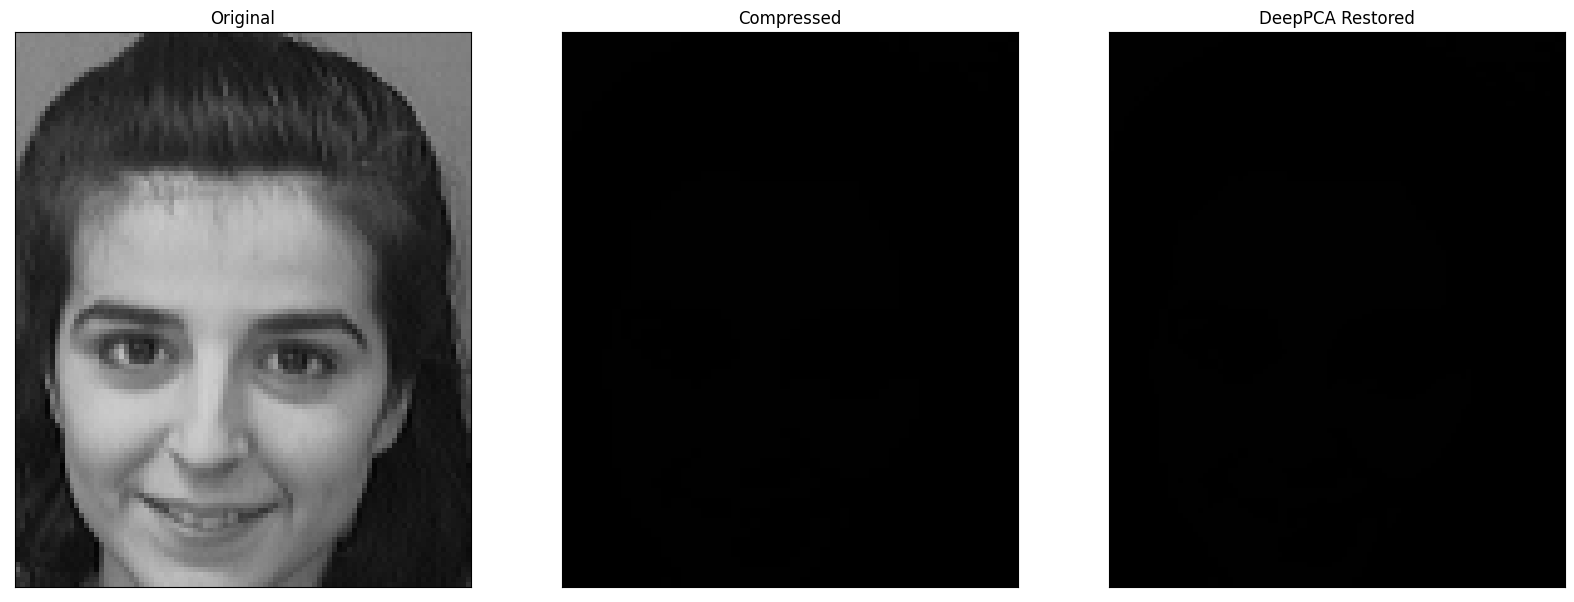

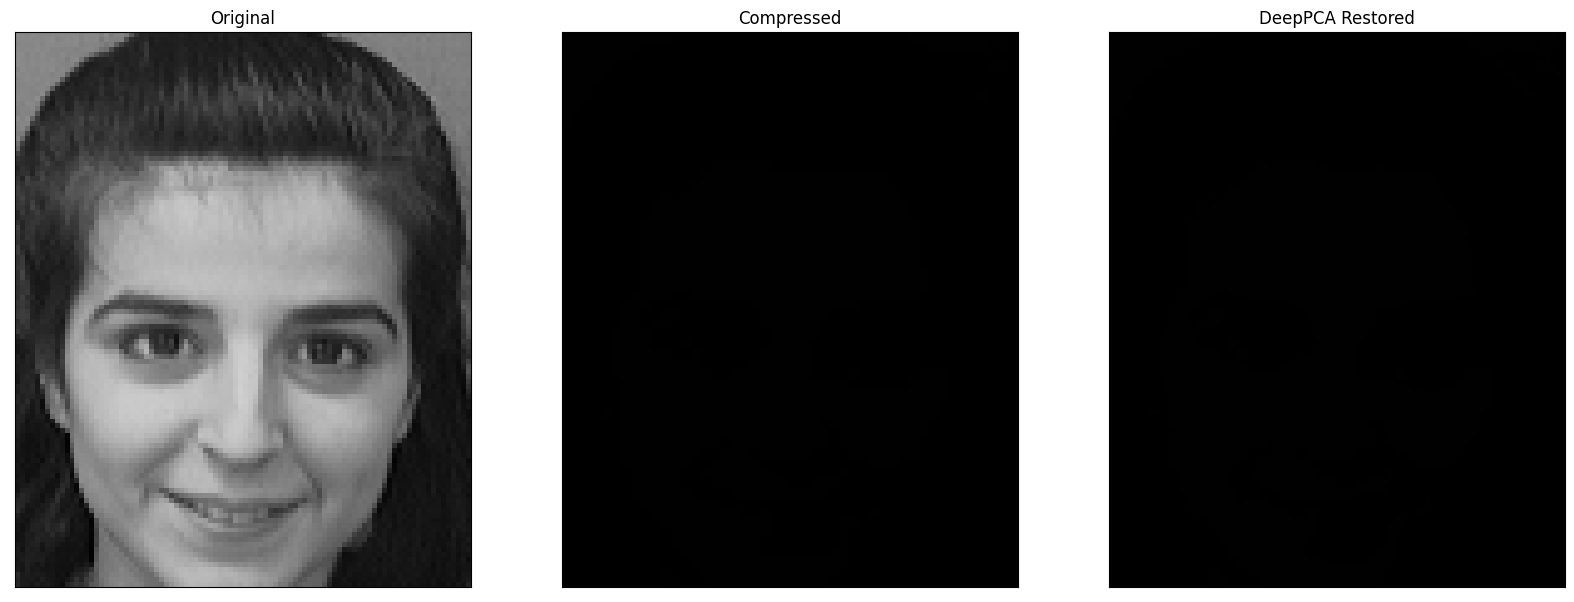

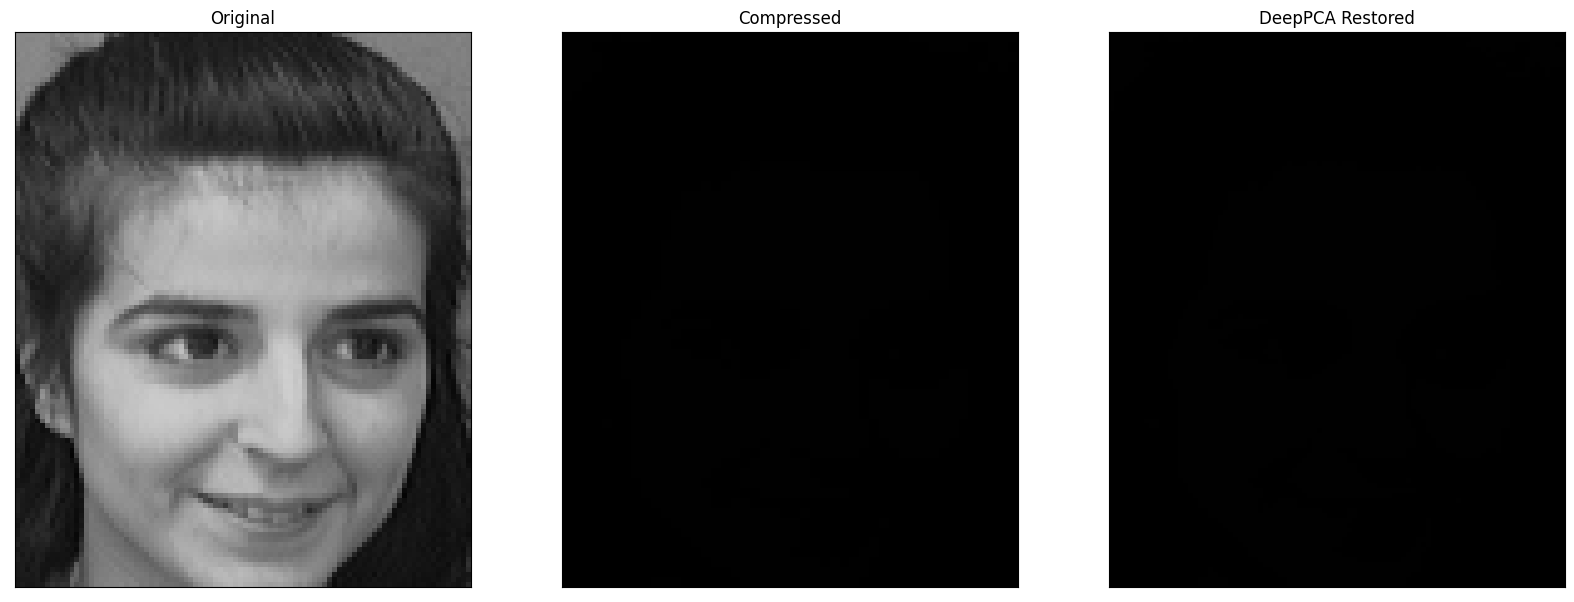

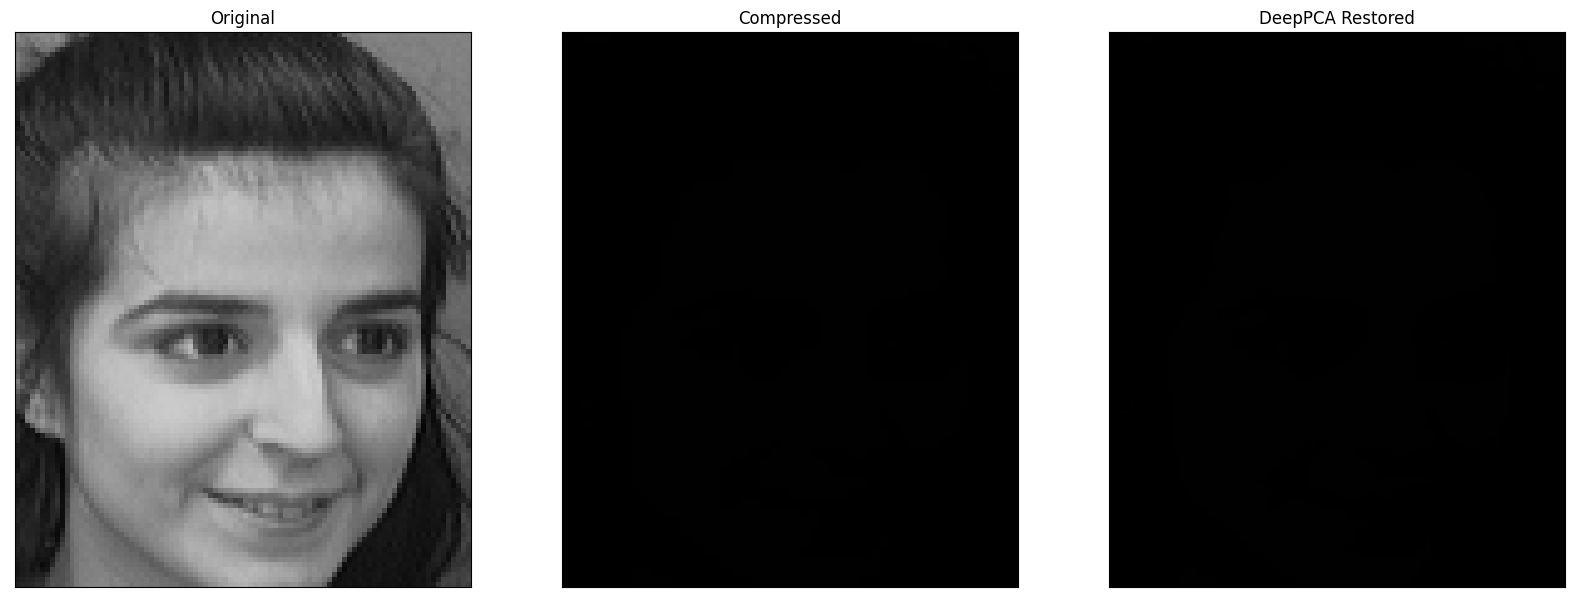

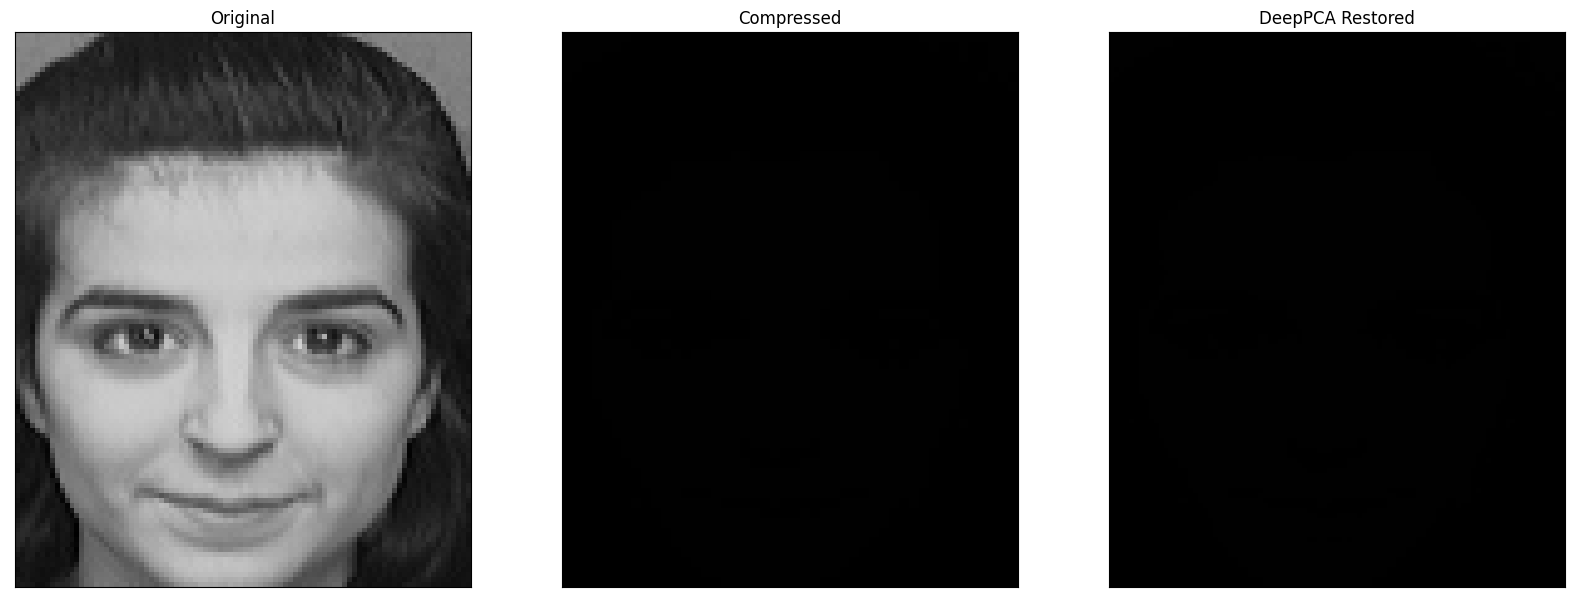

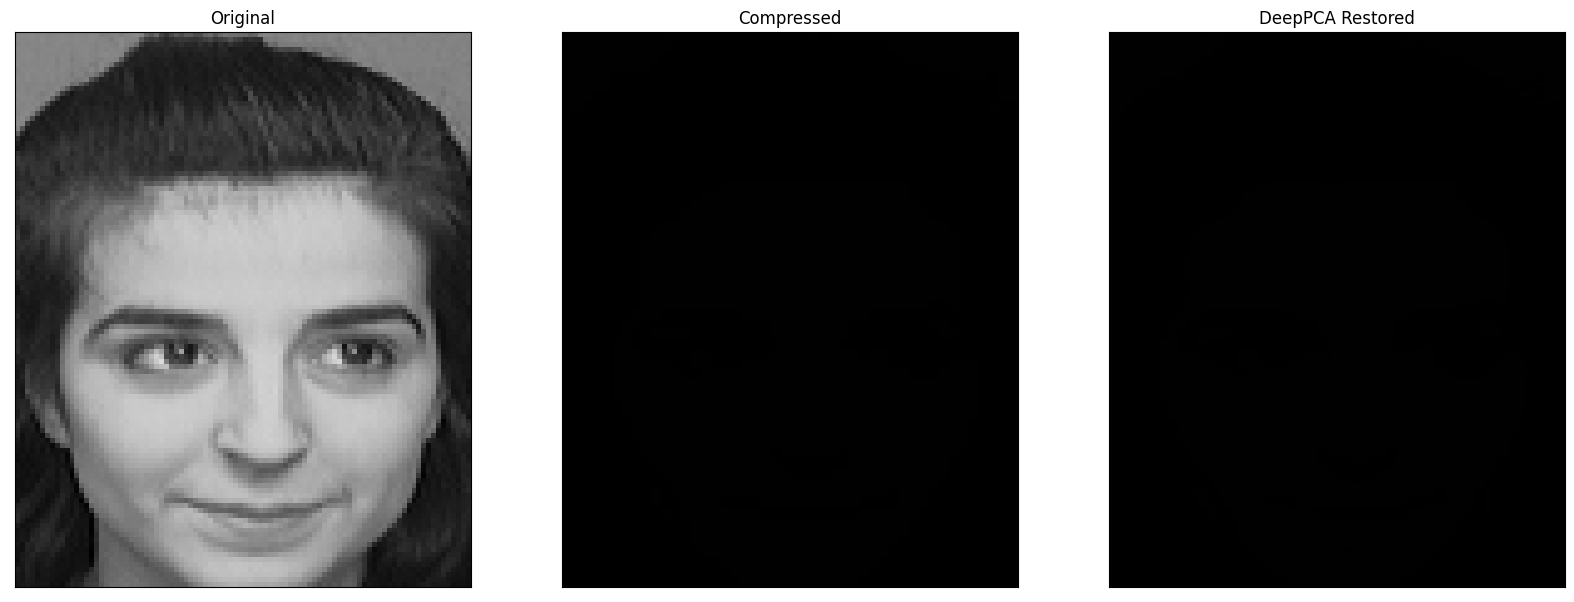

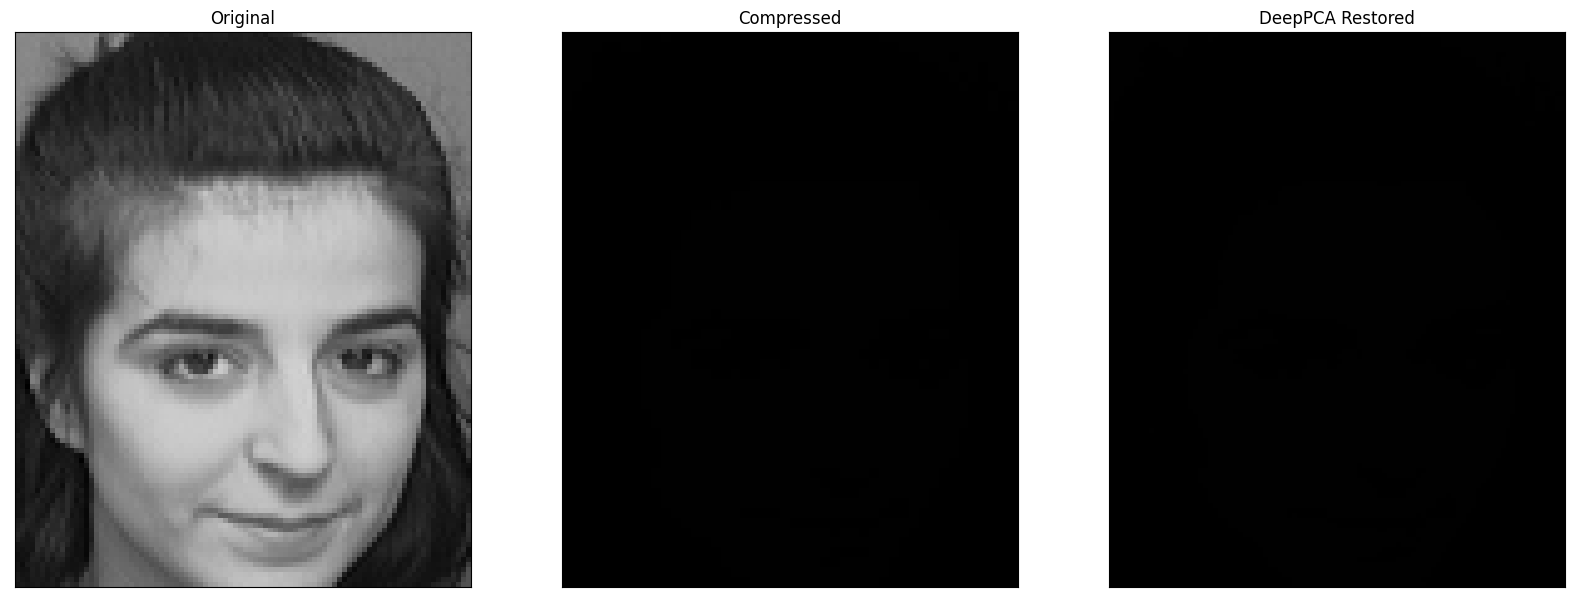

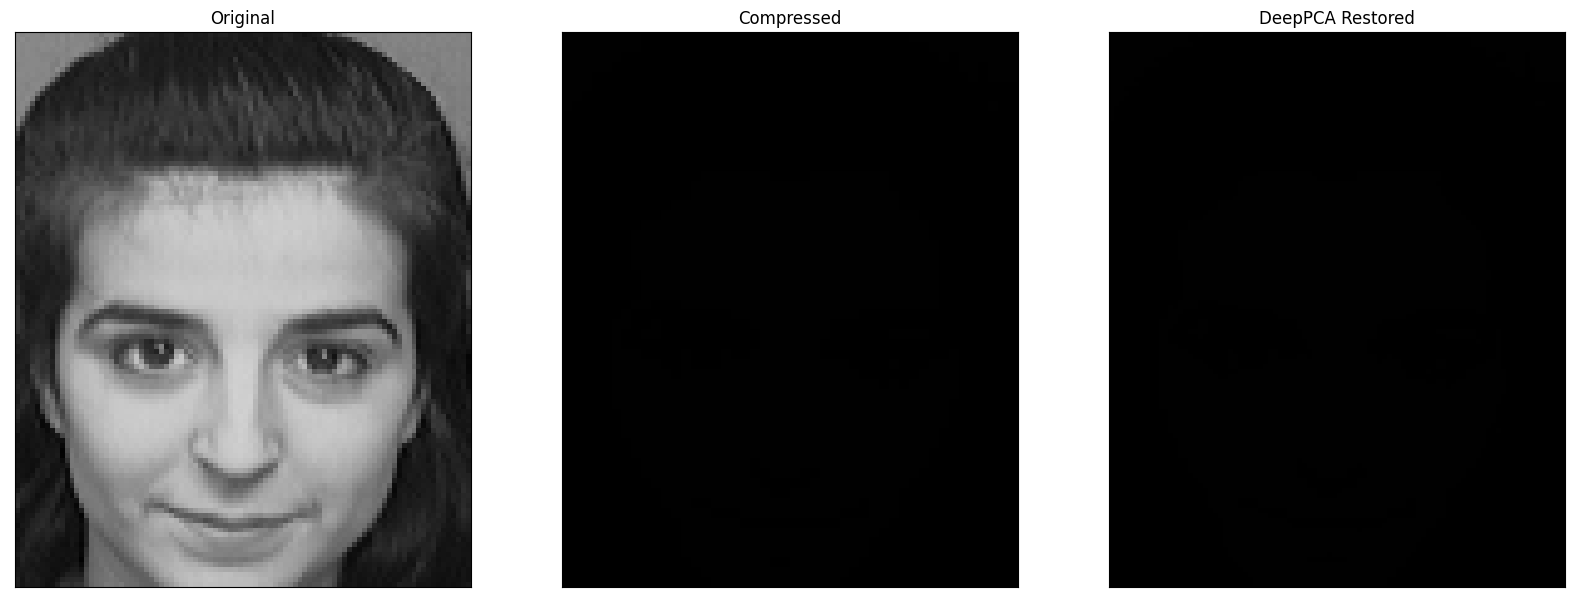

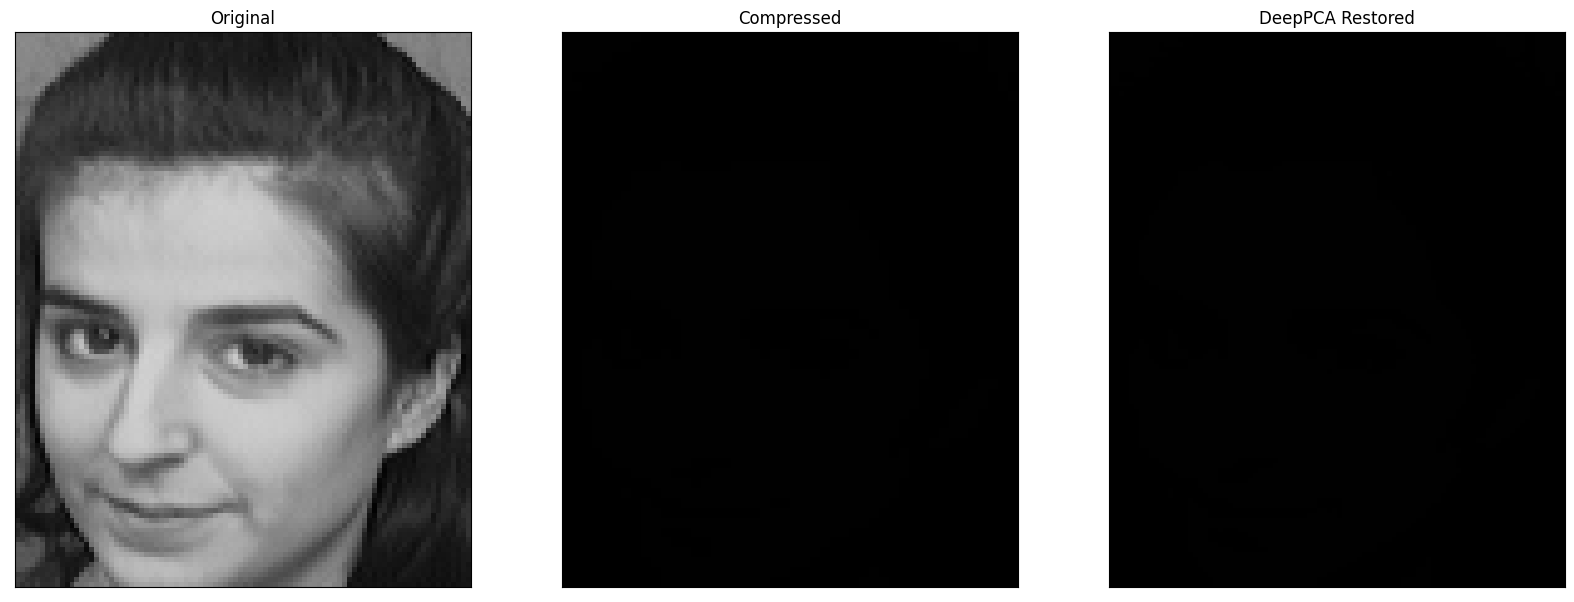

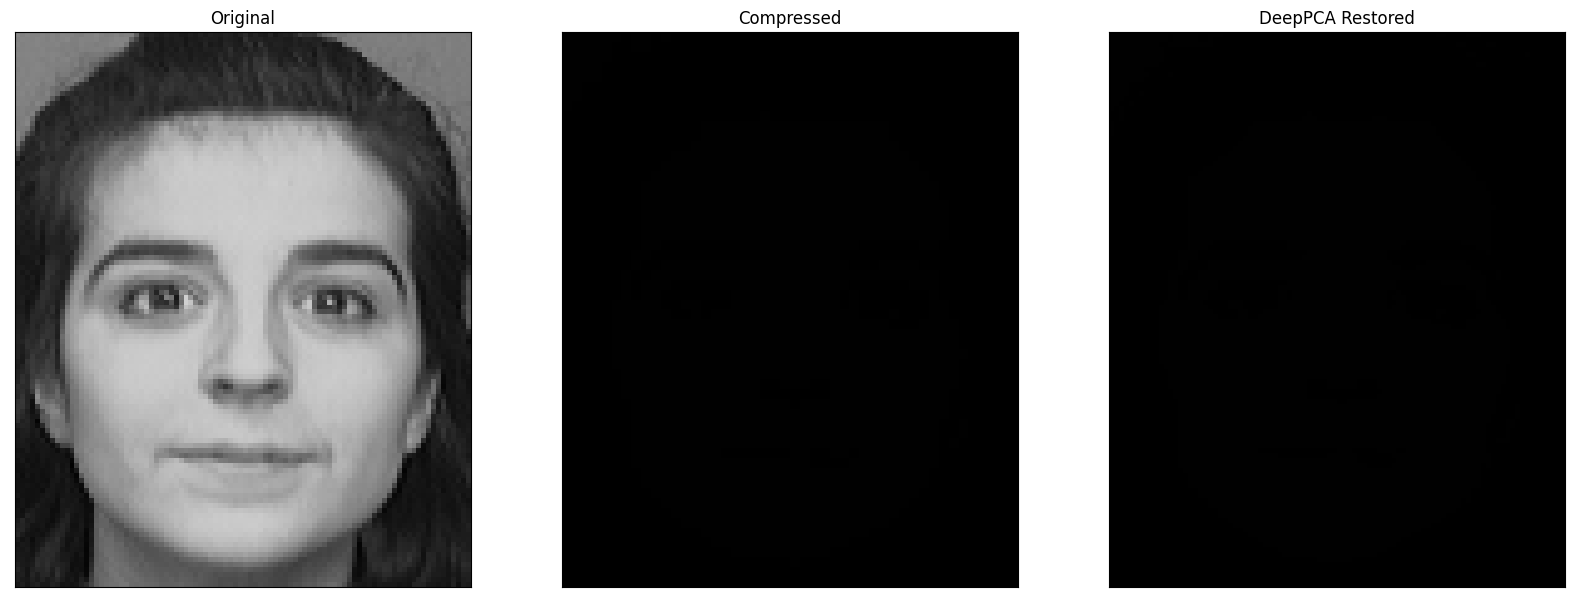

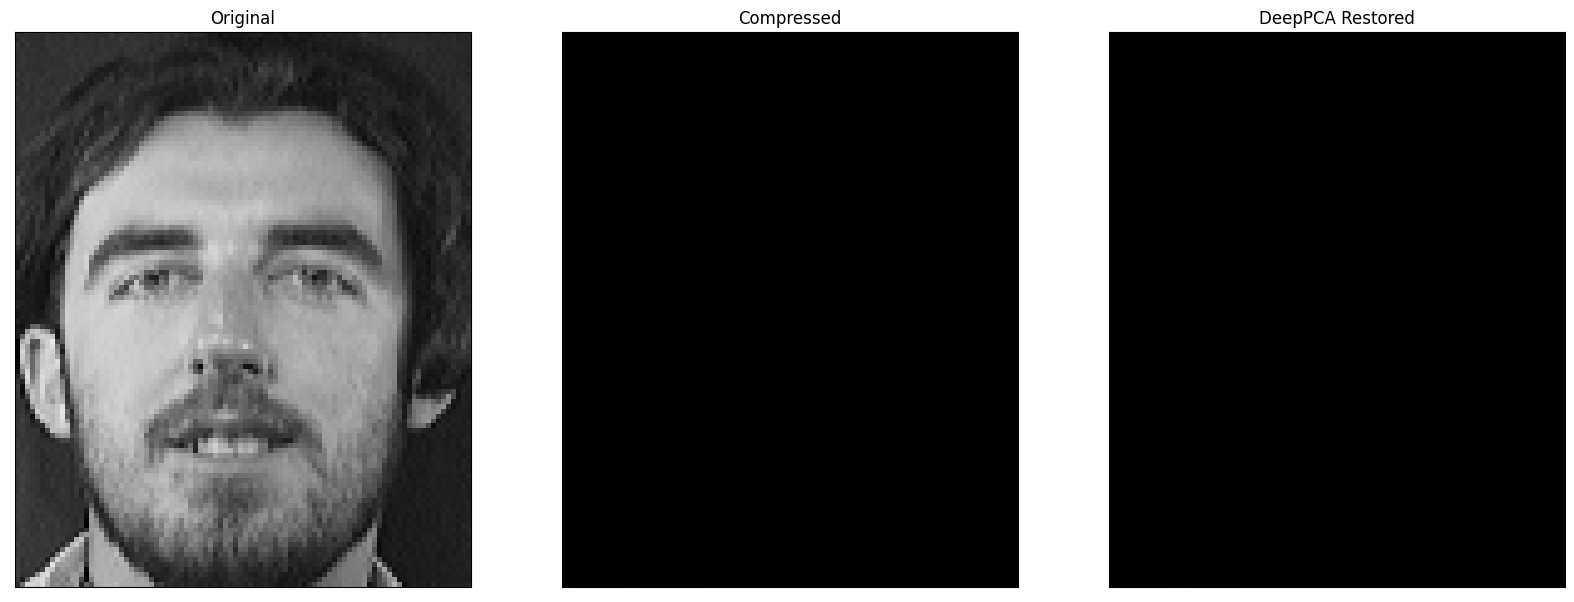

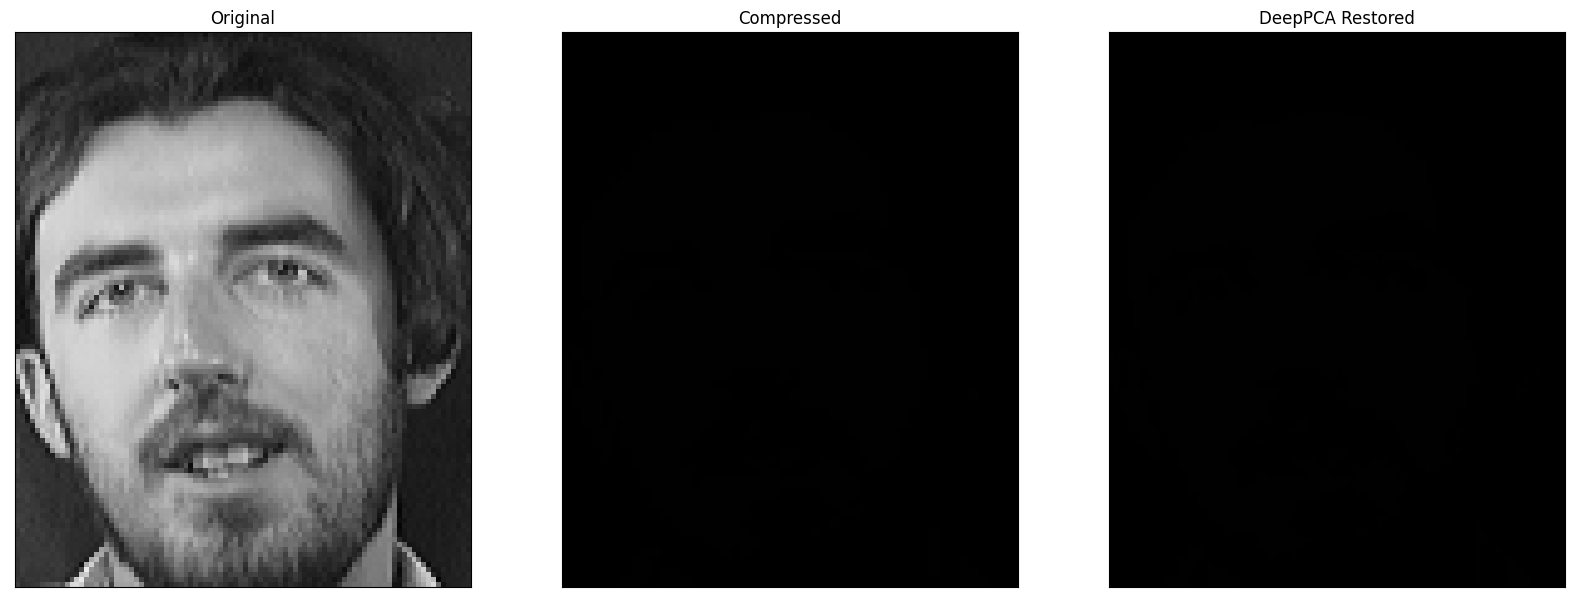

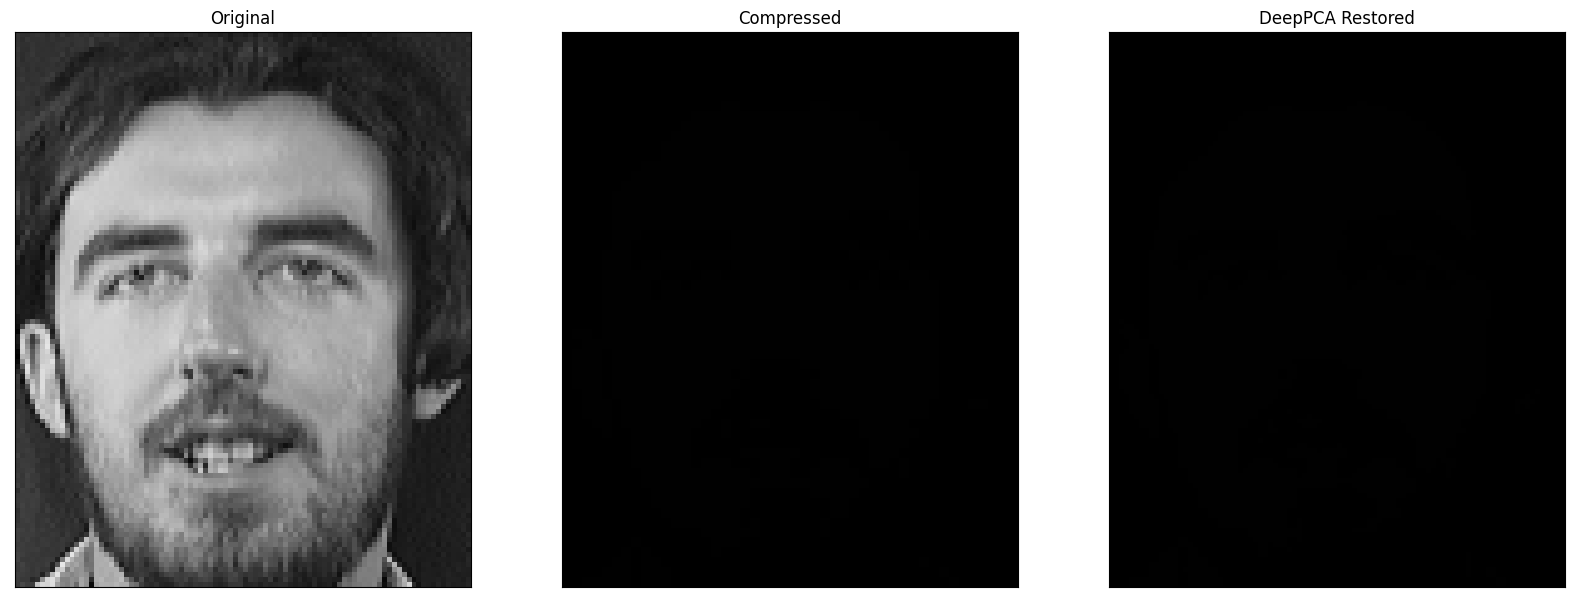

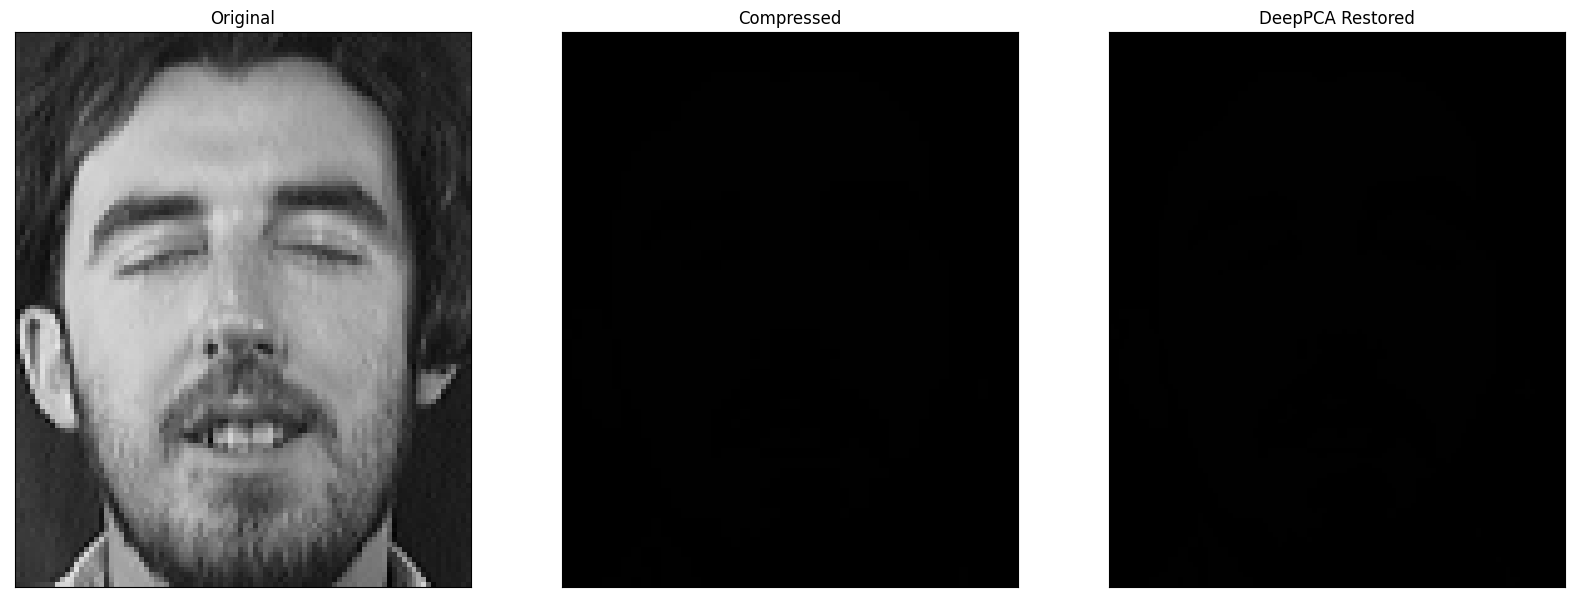

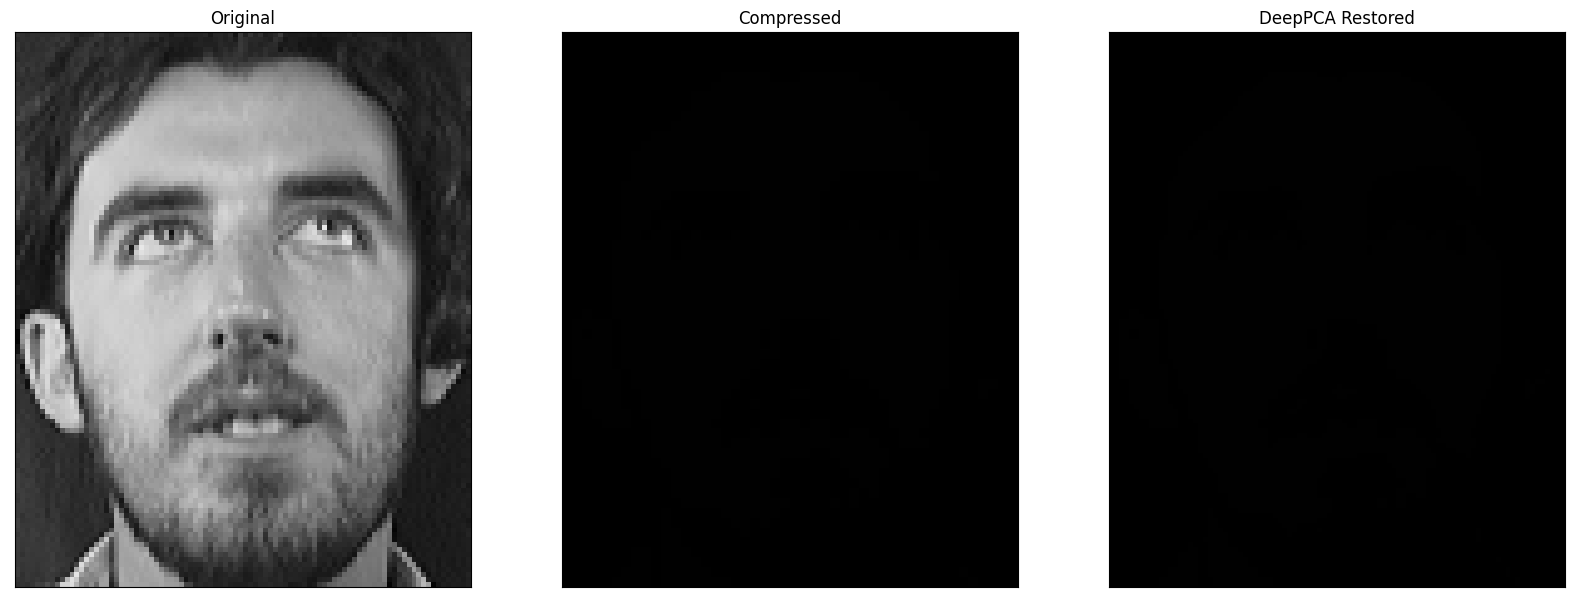

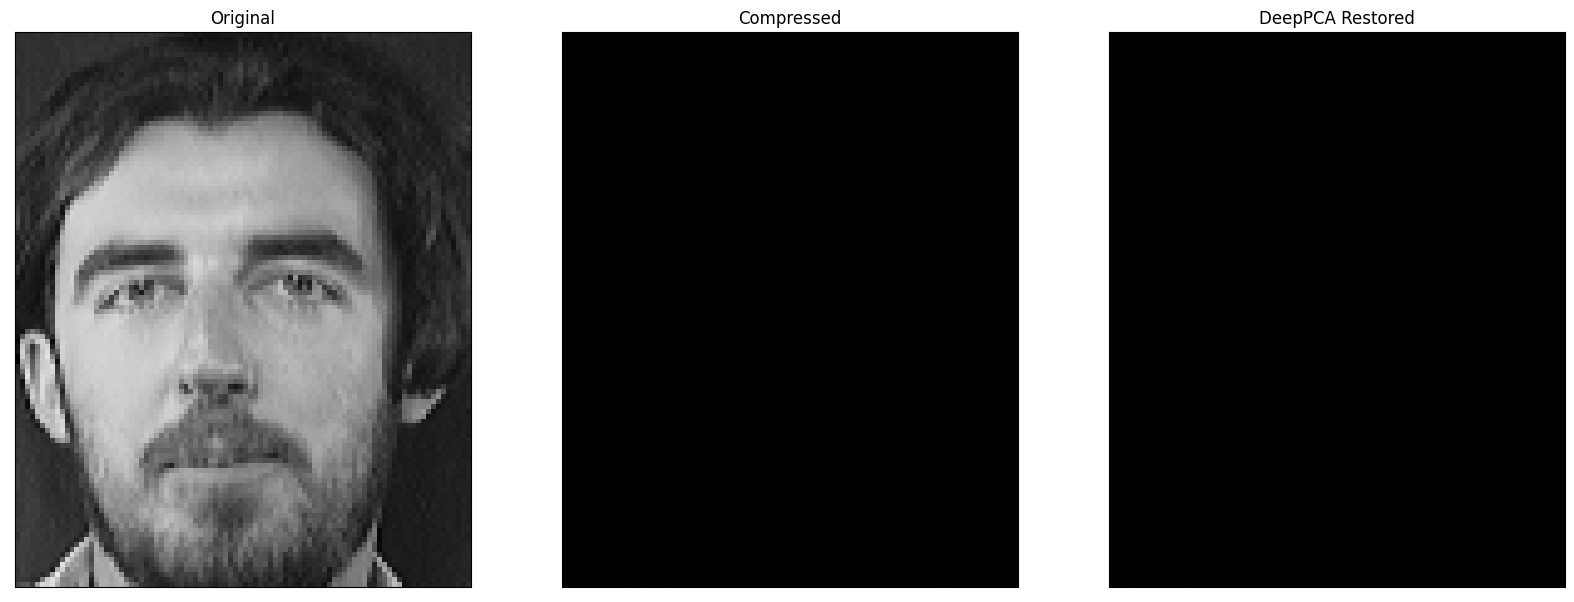

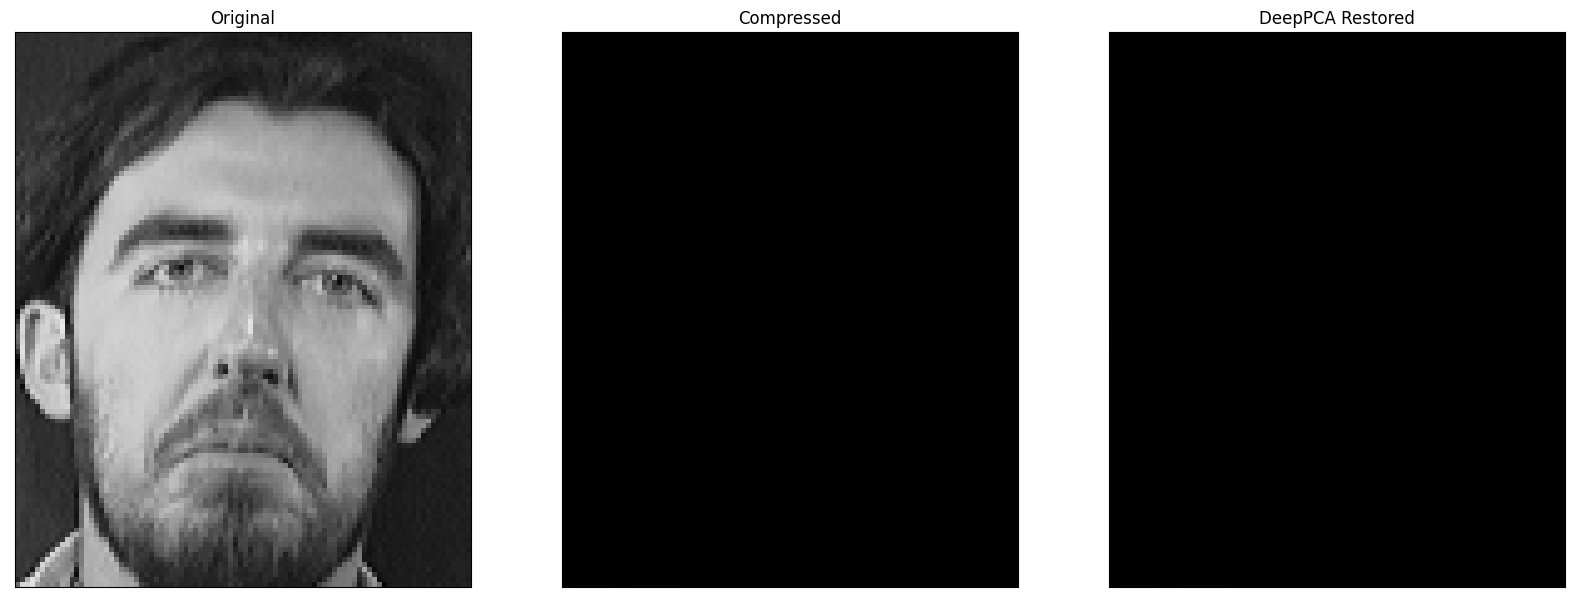

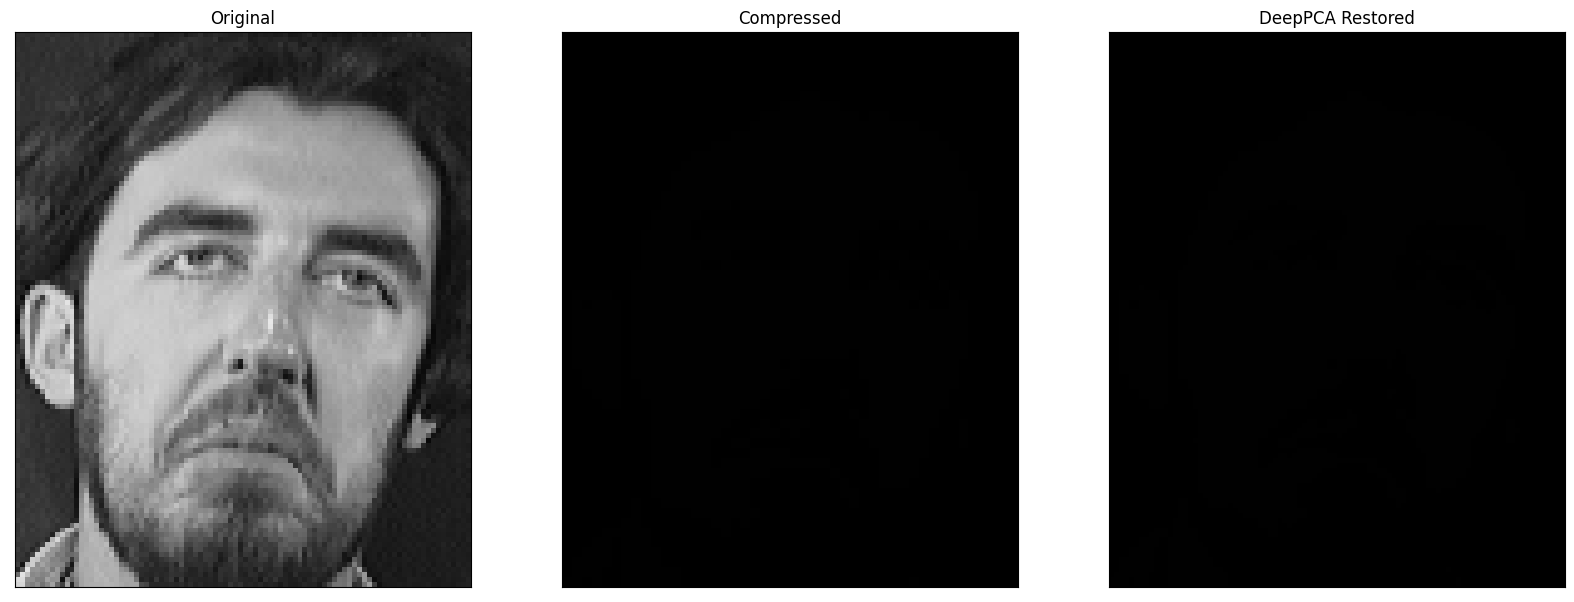

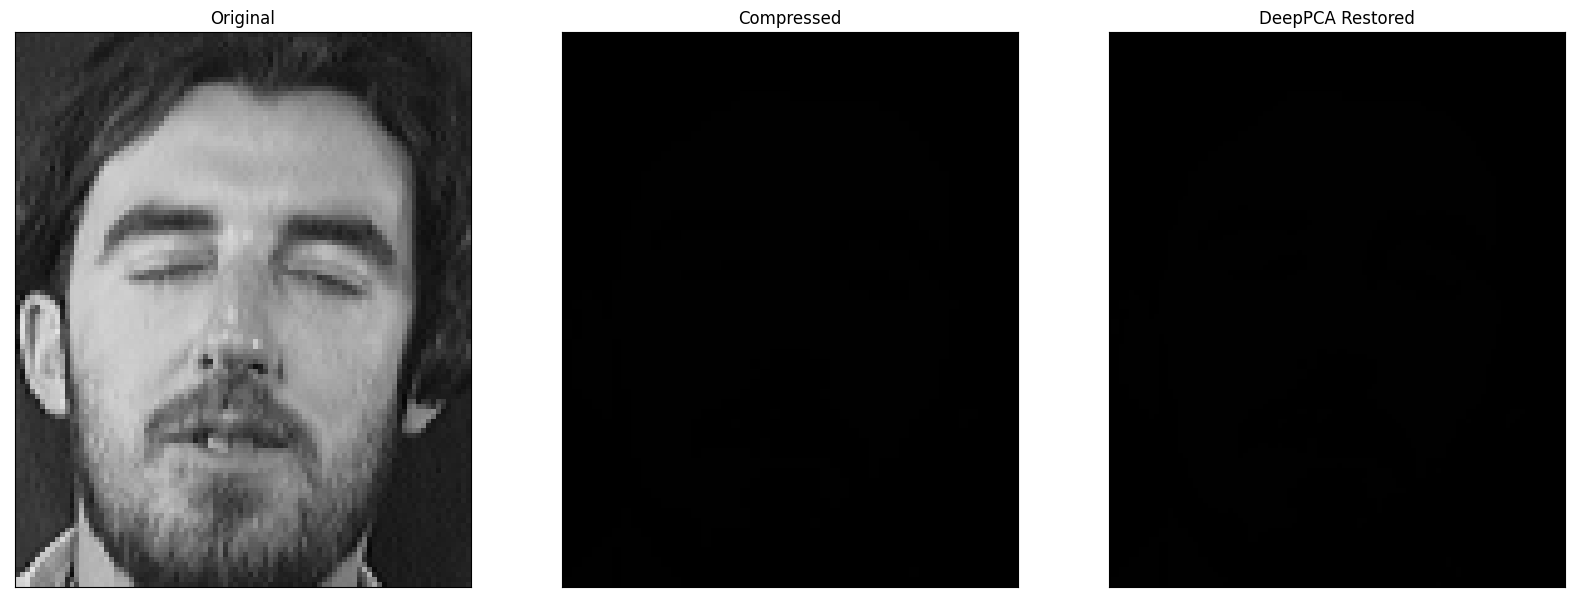

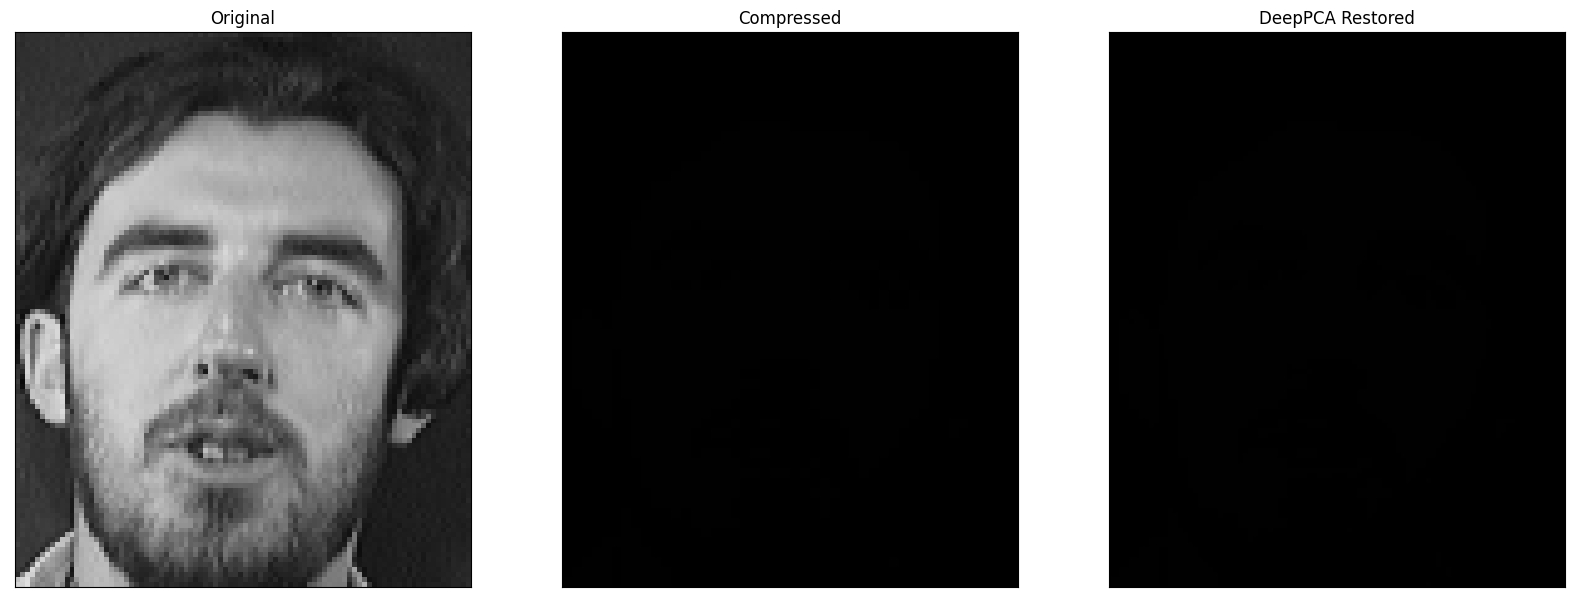

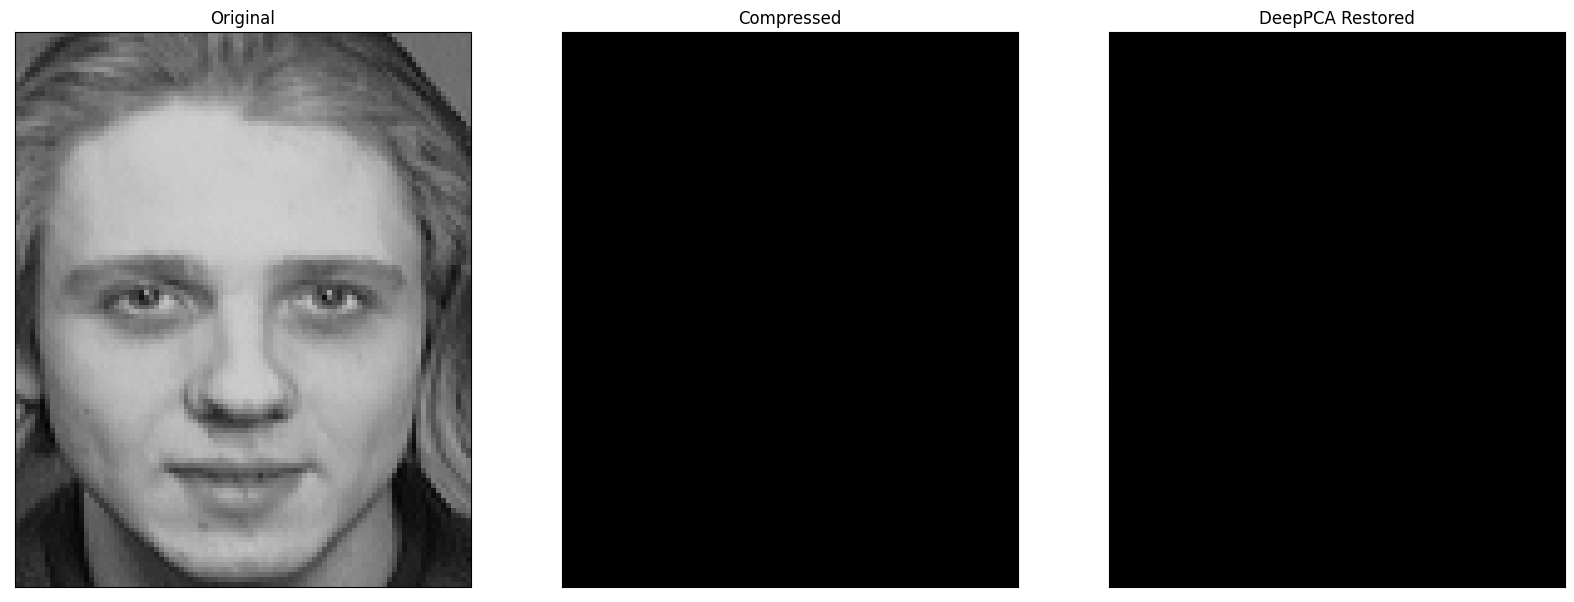

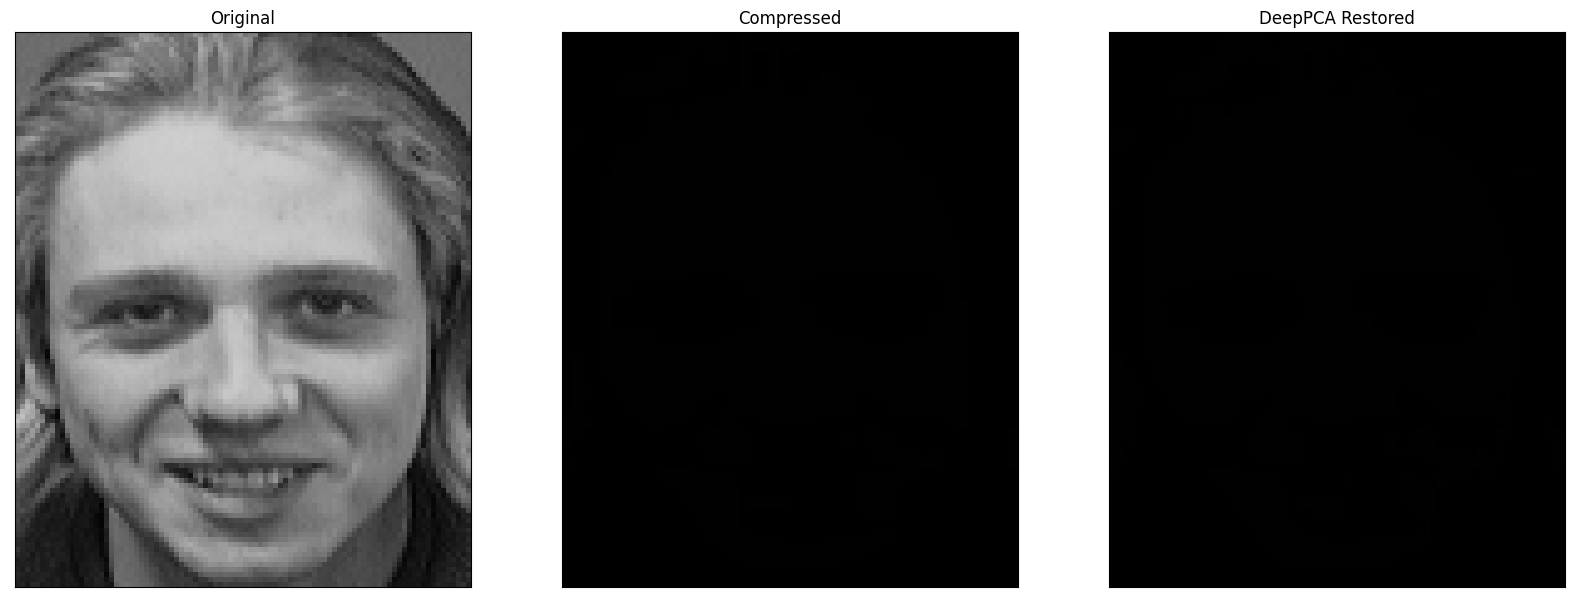

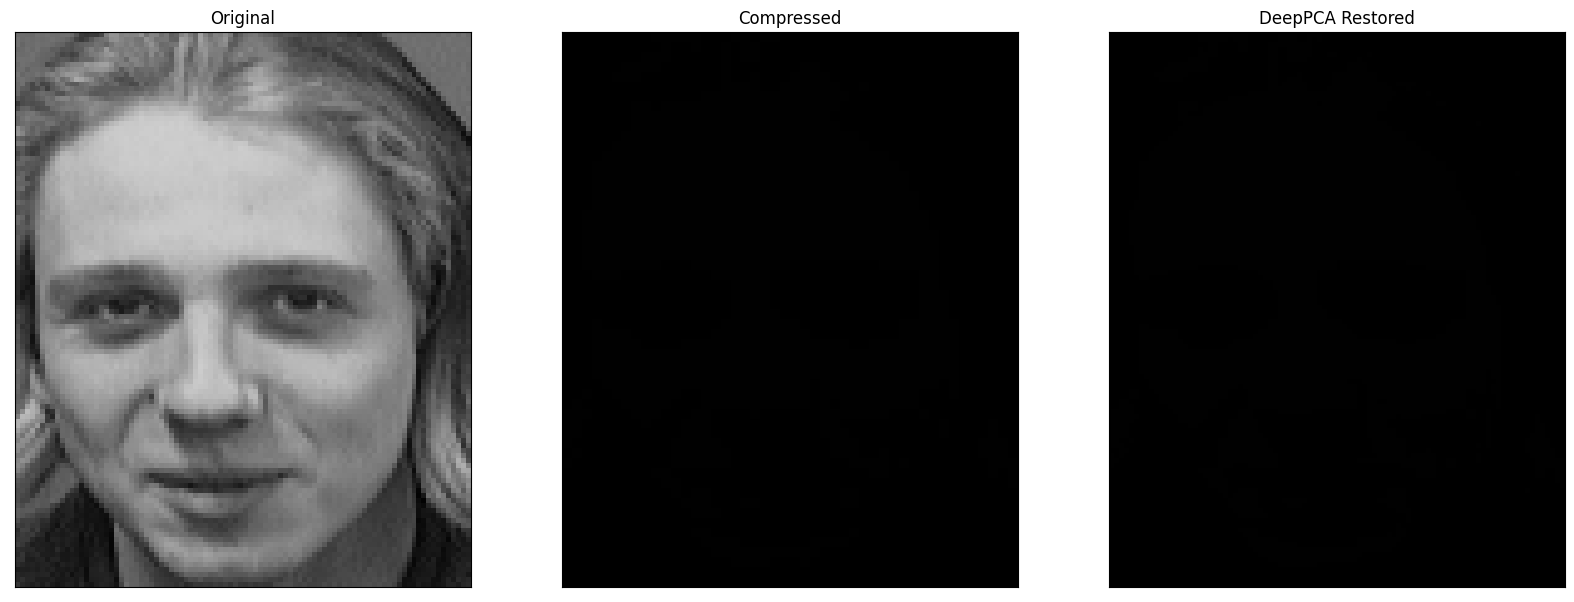

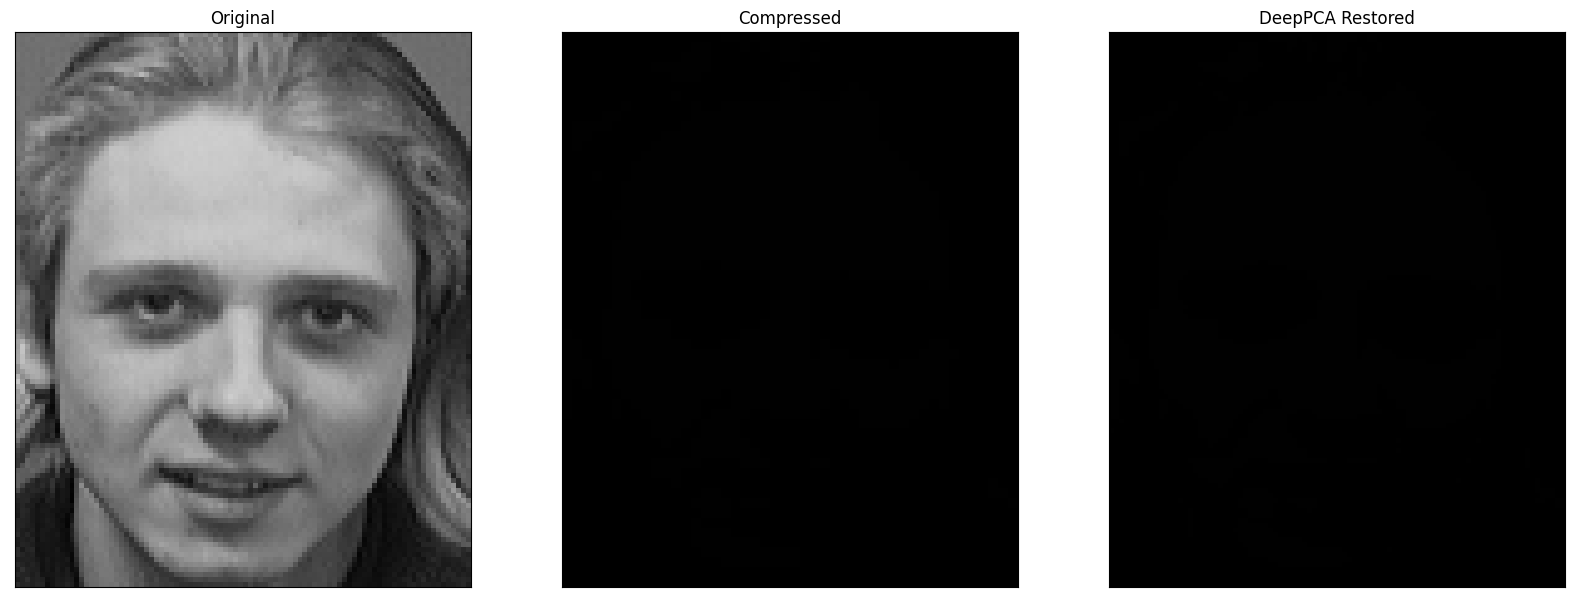

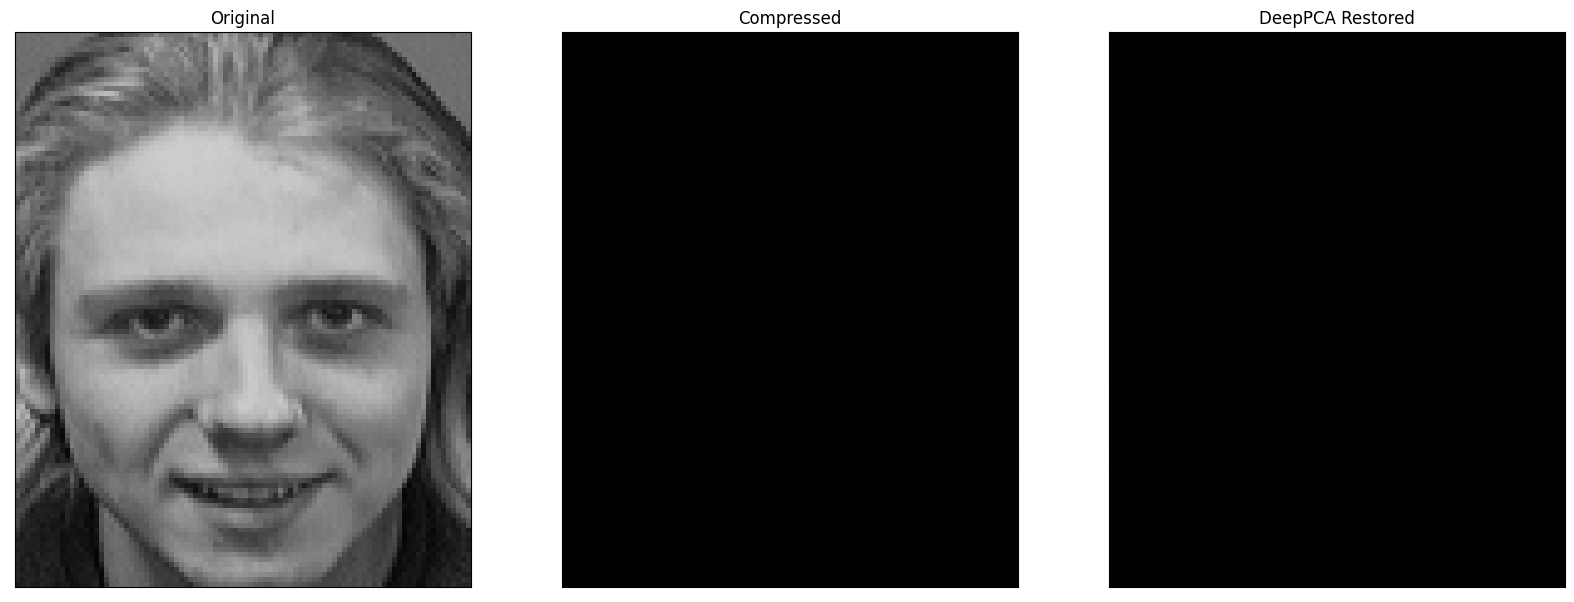

In [23]:
faces = Eigenfaces('./datasets/att_faces_restore')
faces.all_metrics()

In [4]:
%ls


DPCA.py             archive/            requirements.txt    show_results.ipynb
README.md           datasets/           results/            train.py
__pycache__/        model.py            savefig.py          utils.py


In [5]:
plt.rcParams.update({'figure.max_open_warning': 0})

!python savefig.py


Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x800)
Figure(2000x80